# Preliminaries

Authors: Group 13: Fouad Alallah, Raqeeb Rasheed, and Bradley Rey

Purpose: The purpose of this code is to test the average case performance of our algorithms against greedy algorithms.

Remarks: This file is built to be run in a Jupyter kernel for Python 3, and some packages may need to be installed (see dependenices). We have separated the code which allows you to run simulations from the data prep. The origianl file is roughly 5.5 GB and takes a long time to load, split, and prep. Therefor we have included the sub datasets that we use in the simulations which can be loaded and run easily. A single simulation comparison takes a few minutes. The average simulation comparison runs on 20 subsets. Depending on the times worked by the driver, this can take ~30 mins. Directions to run the simulations can be seen in the Simulation section at the bottom.

Dependencies: This file uses some common python packages and some not as common.
                    1. tqdm - this shows progress when iterating through a for loop.
                    2. numpy - data manipulation package
                    3. pandas - used for dataframes
                    4. matplotlib - used to plot results
                    5. geopy - allows us to calculate the distance (with a small bit of error) using lon/latitude

Original Dataset Download Location: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data?select=train.csv

# Setup

Setup imports and load the dataset along with some initial exploration of the data.

In [602]:
# import some needed packages
from tqdm import tqdm # used as a progress bar since dataset is quite large
import numpy as np  # used for data manipulation
import pandas as pd  # allows me to use dataframes which I will load the data set into
import matplotlib.pyplot as plt  # data vis library
import geopy.distance # calculates a rough distance between two long/latitdue points

# view plots in jupyter
%matplotlib inline

# set number of columns in a dataframe I can view
pd.set_option('display.max_rows', 2000)

In [2]:
# load the dataset
df = pd.read_csv("ny_taxi1.csv")  # load the dataset to a dataframe

In [3]:
# show the head of the dataset
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# lets drop the first column 'key' and 'passenger_count' as we won't need them
df.drop(df.columns[[0,7]], axis=1, inplace=True)

In [5]:
# show the head of the dataframe again
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762


In [6]:
# sort the dataset by date
sorted_df = df.sort_values(by='pickup_datetime')

In [7]:
# show the sorted_df
# data goes from january 1st, 2009 to june 30th, 2015
sorted_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
44194380,30.2,2009-01-01 00:00:27 UTC,-73.782104,40.644881,-73.963565,40.676348
880228,15.0,2009-01-01 00:00:46 UTC,-73.953738,40.806762,-73.989427,40.769542
13340185,4.2,2009-01-01 00:00:49 UTC,-73.993185,40.727841,-73.990781,40.730007
661006,5.8,2009-01-01 00:01:04 UTC,-73.995133,40.734111,-73.998232,40.722874
12913471,14.6,2009-01-01 00:01:04 UTC,-73.972484,40.742743,-73.918937,40.764496
...,...,...,...,...,...,...
41030757,24.5,2015-06-30 23:59:46 UTC,-73.987198,40.739059,-73.962769,40.672539
49938742,33.5,2015-06-30 23:59:48 UTC,-73.970360,40.783756,-73.870560,40.709118
14242297,6.0,2015-06-30 23:59:48 UTC,-73.978867,40.750820,-73.989326,40.740780
22749696,9.5,2015-06-30 23:59:52 UTC,-73.944077,40.711658,-73.982857,40.719799


In [79]:
# lets setup a few dataframes that only contain a single day
df_monday = sorted_df.loc[sorted_df['pickup_datetime'].str.contains('2015-06-22')]

In [536]:
# remove rows with non-entries (ie values of 0)
monday_remove_indicies = df_monday[ (df_monday['pickup_longitude'] == 0.000000) | (df_monday['pickup_latitude'] == 0.000000) | (df_monday['dropoff_longitude'] == 0.000000) | (df_monday['dropoff_latitude'] == 0.000000) | (df_monday['fare_amount'] <= 0.00)].index
df_monday.drop(monday_remove_indicies, inplace = True)

In [537]:
df_monday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,13.00,2015-06-22 00:00:04 UTC,-74.007607,40.740982,-73.973381,40.756908,3.388621,10.971554
1,48.54,2015-06-22 00:00:04 UTC,-73.874825,40.774029,-74.016403,40.711124,13.848815,37.122039
2,9.50,2015-06-22 00:00:06 UTC,-73.989044,40.742161,-73.981377,40.764111,2.522041,8.805102
3,13.00,2015-06-22 00:00:08 UTC,-73.987640,40.741772,-73.987930,40.779823,4.225675,13.064186
4,6.50,2015-06-22 00:00:16 UTC,-73.967575,40.763012,-73.983742,40.740936,2.806017,9.515044
...,...,...,...,...,...,...,...,...
18390,7.50,2015-06-22 23:59:29 UTC,-73.978111,40.752460,-73.974892,40.741718,1.223507,5.558769
18391,13.50,2015-06-22 23:59:40 UTC,-73.948837,40.781628,-73.984657,40.744396,5.122681,15.306703
18392,6.50,2015-06-22 23:59:40 UTC,-73.971474,40.755032,-73.957520,40.765404,1.647737,6.619342
18393,9.00,2015-06-22 23:59:40 UTC,-73.967438,40.772041,-73.968712,40.754971,1.898748,7.246870


In [9]:
# repeat for wednesday
df_wednesday = sorted_df.loc[sorted_df['pickup_datetime'].str.contains('2015-06-24')]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
51286869,7.00,2015-06-24 00:00:01 UTC,-73.999649,40.761234,-73.984108,40.775375
45178022,31.04,2015-06-24 00:00:04 UTC,-73.992271,40.742809,-73.890533,40.701870
52863284,12.00,2015-06-24 00:00:14 UTC,-73.948387,40.706848,-73.924080,40.690647
23763223,4.00,2015-06-24 00:00:22 UTC,-73.984360,40.768688,-73.982841,40.771671
1726993,10.00,2015-06-24 00:00:22 UTC,-73.989716,40.739105,-73.983315,40.759136
...,...,...,...,...,...,...
12164195,3.00,2015-06-24 23:59:29 UTC,-74.007256,40.715778,-74.003426,40.719147
7142256,5.50,2015-06-24 23:59:35 UTC,-73.980911,40.751064,-73.990997,40.750511
18050360,6.00,2015-06-24 23:59:39 UTC,-73.981277,40.769070,-73.968086,40.765400
37394028,15.50,2015-06-24 23:59:46 UTC,-73.997147,40.722065,-73.949593,40.773621


In [538]:
wednesday_remove_indicies = df_wednesday[ (df_wednesday['pickup_longitude'] == 0.000000) | (df_wednesday['pickup_latitude'] == 0.000000) | (df_wednesday['dropoff_longitude'] == 0.000000) | (df_wednesday['dropoff_latitude'] == 0.000000) | (df_wednesday['fare_amount'] <= 0.00)].index
df_wednesday.drop(wednesday_remove_indicies, inplace = True)

In [539]:
df_wednesday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,7.00,2015-06-24 00:00:01 UTC,-73.999649,40.761234,-73.984108,40.775375,2.046383,7.615959
1,31.04,2015-06-24 00:00:04 UTC,-73.992271,40.742809,-73.890533,40.701870,9.723791,26.809478
2,12.00,2015-06-24 00:00:14 UTC,-73.948387,40.706848,-73.924080,40.690647,2.730788,9.326970
3,4.00,2015-06-24 00:00:22 UTC,-73.984360,40.768688,-73.982841,40.771671,0.355205,3.388013
4,10.00,2015-06-24 00:00:22 UTC,-73.989716,40.739105,-73.983315,40.759136,2.289168,8.222919
...,...,...,...,...,...,...,...,...
19909,3.00,2015-06-24 23:59:29 UTC,-74.007256,40.715778,-74.003426,40.719147,0.494608,3.736519
19910,5.50,2015-06-24 23:59:35 UTC,-73.980911,40.751064,-73.990997,40.750511,0.853993,4.634981
19911,6.00,2015-06-24 23:59:39 UTC,-73.981277,40.769070,-73.968086,40.765400,1.185957,5.464892
19912,15.50,2015-06-24 23:59:46 UTC,-73.997147,40.722065,-73.949593,40.773621,6.993398,19.983494


In [10]:
# repeat for friday
df_friday = sorted_df.loc[sorted_df['pickup_datetime'].str.contains('2015-06-26')]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
1327326,16.0,2015-06-26 00:00:08 UTC,0.000000,0.000000,0.000000,0.000000
26365179,10.0,2015-06-26 00:00:09 UTC,-73.997871,40.745876,-73.988754,40.727131
31698026,17.0,2015-06-26 00:00:14 UTC,-74.008377,40.735870,-73.977913,40.783470
46102919,5.5,2015-06-26 00:00:14 UTC,-73.992485,40.738049,-73.997292,40.734974
5327321,11.0,2015-06-26 00:00:17 UTC,-74.001884,40.750965,-73.969078,40.788509
...,...,...,...,...,...,...
29311531,11.0,2015-06-26 23:59:45 UTC,-74.008217,40.737698,-73.980820,40.750126
54939804,7.5,2015-06-26 23:59:51 UTC,-73.977234,40.747852,-73.994102,40.728264
2437974,8.0,2015-06-26 23:59:53 UTC,-73.991936,40.759441,-74.006897,40.741604
18508578,24.5,2015-06-26 23:59:54 UTC,-73.991547,40.744617,-73.975449,40.670197


In [540]:
friday_remove_indicies = df_friday[ (df_friday['pickup_longitude'] == 0.000000) | (df_friday['pickup_latitude'] == 0.000000) | (df_friday['dropoff_longitude'] == 0.000000) | (df_friday['dropoff_latitude'] == 0.000000) | (df_friday['fare_amount'] <= 0.00)].index
df_friday.drop(friday_remove_indicies, inplace = True)

In [541]:
df_friday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,10.0,2015-06-26 00:00:09 UTC,-73.997871,40.745876,-73.988754,40.727131,2.219544,8.048861
1,17.0,2015-06-26 00:00:14 UTC,-74.008377,40.735870,-73.977913,40.783470,5.878622,17.196554
2,5.5,2015-06-26 00:00:14 UTC,-73.992485,40.738049,-73.997292,40.734974,0.530488,3.826219
3,11.0,2015-06-26 00:00:17 UTC,-74.001884,40.750965,-73.969078,40.788509,5.005432,15.013579
4,5.0,2015-06-26 00:00:17 UTC,-73.979683,40.748672,-73.984604,40.751881,0.547388,3.868471
...,...,...,...,...,...,...,...,...
21049,11.0,2015-06-26 23:59:45 UTC,-74.008217,40.737698,-73.980820,40.750126,2.694297,9.235742
21050,7.5,2015-06-26 23:59:51 UTC,-73.977234,40.747852,-73.994102,40.728264,2.600388,9.000969
21051,8.0,2015-06-26 23:59:53 UTC,-73.991936,40.759441,-74.006897,40.741604,2.349503,8.373758
21052,24.5,2015-06-26 23:59:54 UTC,-73.991547,40.744617,-73.975449,40.670197,8.375532,23.438829


In [11]:
# repeat for sunday
df_sunday = sorted_df.loc[sorted_df['pickup_datetime'].str.contains('2015-06-28')]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
54652061,2.5,2015-06-28 00:00:06 UTC,-73.874123,40.773720,-73.875870,40.773315
41425494,3.0,2015-06-28 00:00:08 UTC,-73.994408,40.764874,-73.996384,40.763668
53671192,16.0,2015-06-28 00:00:08 UTC,-73.985344,40.723549,-73.988060,40.759624
21829009,24.0,2015-06-28 00:00:09 UTC,-74.008224,40.748932,-73.950912,40.828079
46970159,23.5,2015-06-28 00:00:17 UTC,-73.961876,40.763615,-73.855698,40.751667
...,...,...,...,...,...,...
2310787,15.0,2015-06-28 23:59:30 UTC,-73.995689,40.690578,-74.003143,40.738972
3553995,5.5,2015-06-28 23:59:39 UTC,-73.991409,40.749851,-74.006165,40.743813
50407495,5.5,2015-06-28 23:59:39 UTC,-73.995110,40.739742,-74.002846,40.733814
20294666,14.5,2015-06-28 23:59:47 UTC,-73.994873,40.724792,-73.955811,40.778797


In [542]:
sunday_remove_indicies =df_sunday[ (df_sunday['pickup_longitude'] == 0.000000) | (df_sunday['pickup_latitude'] == 0.000000) | (df_sunday['dropoff_longitude'] == 0.000000) | (df_sunday['dropoff_latitude'] == 0.000000) | (df_sunday['fare_amount'] <= 0.00)].index
df_sunday.drop(sunday_remove_indicies, inplace = True)

In [543]:
df_sunday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,2.5,2015-06-28 00:00:06 UTC,-73.874123,40.773720,-73.875870,40.773315,0.154181,2.885453
1,3.0,2015-06-28 00:00:08 UTC,-73.994408,40.764874,-73.996384,40.763668,0.213907,3.034767
2,16.0,2015-06-28 00:00:08 UTC,-73.985344,40.723549,-73.988060,40.759624,4.012718,12.531796
3,24.0,2015-06-28 00:00:09 UTC,-74.008224,40.748932,-73.950912,40.828079,10.032526,27.581315
4,23.5,2015-06-28 00:00:17 UTC,-73.961876,40.763615,-73.855698,40.751667,9.063607,25.159018
...,...,...,...,...,...,...,...,...
17019,15.0,2015-06-28 23:59:30 UTC,-73.995689,40.690578,-74.003143,40.738972,5.410775,16.026938
17020,5.5,2015-06-28 23:59:39 UTC,-73.991409,40.749851,-74.006165,40.743813,1.415145,6.037864
17021,5.5,2015-06-28 23:59:39 UTC,-73.995110,40.739742,-74.002846,40.733814,0.927569,4.818922
17022,14.5,2015-06-28 23:59:47 UTC,-73.994873,40.724792,-73.955811,40.778797,6.844583,19.611459


In [169]:
# we now have 4 individual day datasets
# df_monday, df_wednesday, df_friday, df_sunday

# lets add columns in each for the distance between pickup and dropoff and the profit
df_monday.loc[:,'ride_distance'] = 0.0
df_wednesday.loc[:,'ride_distance'] = 0.0
df_friday.loc[:,'ride_distance'] = 0.0
df_sunday.loc[:,'ride_distance'] = 0.0
df_monday.loc[:,'profit'] = 0.0
df_wednesday.loc[:,'profit'] = 0.0
df_friday.loc[:,'profit'] = 0.0
df_sunday.loc[:,'profit'] = 0.0

In [96]:
# define a function that will calculate the distance (in kms)
# function will take four values. start latitude and longitude and end latitude and longitude
def calculateDistance (s_lat, s_long, e_lat, e_long):
    return (geopy.distance.geodesic((s_lat, s_long), (e_lat, e_long)).km)

In [185]:
# set the base ride price as well as the rate per km travelled
costPerKm = 2.50
baseRate = 2.50

In [186]:
# iterate through monday and calculate the distance and profit
for index, row in tqdm(df_monday.iterrows()):
    df_monday.at[index,'ride_distance'] = calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])
    df_monday.at[index,'profit'] = (calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])*costPerKm + baseRate)

18395it [00:10, 1761.46it/s]


In [544]:
# with values removed and their original indicies still here lets reset the indicices
df_monday = df_monday.reset_index(drop=True)
df_monday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,13.00,2015-06-22 00:00:04 UTC,-74.007607,40.740982,-73.973381,40.756908,3.388621,10.971554
1,48.54,2015-06-22 00:00:04 UTC,-73.874825,40.774029,-74.016403,40.711124,13.848815,37.122039
2,9.50,2015-06-22 00:00:06 UTC,-73.989044,40.742161,-73.981377,40.764111,2.522041,8.805102
3,13.00,2015-06-22 00:00:08 UTC,-73.987640,40.741772,-73.987930,40.779823,4.225675,13.064186
4,6.50,2015-06-22 00:00:16 UTC,-73.967575,40.763012,-73.983742,40.740936,2.806017,9.515044
...,...,...,...,...,...,...,...,...
18360,7.50,2015-06-22 23:59:29 UTC,-73.978111,40.752460,-73.974892,40.741718,1.223507,5.558769
18361,13.50,2015-06-22 23:59:40 UTC,-73.948837,40.781628,-73.984657,40.744396,5.122681,15.306703
18362,6.50,2015-06-22 23:59:40 UTC,-73.971474,40.755032,-73.957520,40.765404,1.647737,6.619342
18363,9.00,2015-06-22 23:59:40 UTC,-73.967438,40.772041,-73.968712,40.754971,1.898748,7.246870


In [188]:
# iterate through wednesday and repeat
for index, row in tqdm(df_wednesday.iterrows()):
    df_wednesday.at[index,'ride_distance'] = calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])
    df_wednesday.at[index,'profit'] = (calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])*costPerKm + baseRate)

19914it [00:11, 1780.84it/s]


In [545]:
df_wednesday = df_wednesday.reset_index(drop=True)
df_wednesday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,7.00,2015-06-24 00:00:01 UTC,-73.999649,40.761234,-73.984108,40.775375,2.046383,7.615959
1,31.04,2015-06-24 00:00:04 UTC,-73.992271,40.742809,-73.890533,40.701870,9.723791,26.809478
2,12.00,2015-06-24 00:00:14 UTC,-73.948387,40.706848,-73.924080,40.690647,2.730788,9.326970
3,4.00,2015-06-24 00:00:22 UTC,-73.984360,40.768688,-73.982841,40.771671,0.355205,3.388013
4,10.00,2015-06-24 00:00:22 UTC,-73.989716,40.739105,-73.983315,40.759136,2.289168,8.222919
...,...,...,...,...,...,...,...,...
19880,3.00,2015-06-24 23:59:29 UTC,-74.007256,40.715778,-74.003426,40.719147,0.494608,3.736519
19881,5.50,2015-06-24 23:59:35 UTC,-73.980911,40.751064,-73.990997,40.750511,0.853993,4.634981
19882,6.00,2015-06-24 23:59:39 UTC,-73.981277,40.769070,-73.968086,40.765400,1.185957,5.464892
19883,15.50,2015-06-24 23:59:46 UTC,-73.997147,40.722065,-73.949593,40.773621,6.993398,19.983494


In [190]:
# iterate through friday and repeat
for index, row in tqdm(df_friday.iterrows()):
    df_friday.at[index,'ride_distance'] = calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])
    df_friday.at[index,'profit'] = (calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])*costPerKm + baseRate)

21054it [00:11, 1756.12it/s]


In [546]:
df_friday = df_friday.reset_index(drop=True)
df_friday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,10.0,2015-06-26 00:00:09 UTC,-73.997871,40.745876,-73.988754,40.727131,2.219544,8.048861
1,17.0,2015-06-26 00:00:14 UTC,-74.008377,40.735870,-73.977913,40.783470,5.878622,17.196554
2,5.5,2015-06-26 00:00:14 UTC,-73.992485,40.738049,-73.997292,40.734974,0.530488,3.826219
3,11.0,2015-06-26 00:00:17 UTC,-74.001884,40.750965,-73.969078,40.788509,5.005432,15.013579
4,5.0,2015-06-26 00:00:17 UTC,-73.979683,40.748672,-73.984604,40.751881,0.547388,3.868471
...,...,...,...,...,...,...,...,...
21008,11.0,2015-06-26 23:59:45 UTC,-74.008217,40.737698,-73.980820,40.750126,2.694297,9.235742
21009,7.5,2015-06-26 23:59:51 UTC,-73.977234,40.747852,-73.994102,40.728264,2.600388,9.000969
21010,8.0,2015-06-26 23:59:53 UTC,-73.991936,40.759441,-74.006897,40.741604,2.349503,8.373758
21011,24.5,2015-06-26 23:59:54 UTC,-73.991547,40.744617,-73.975449,40.670197,8.375532,23.438829


In [192]:
# iterate through sunday and repeat
for index, row in tqdm(df_sunday.iterrows()):
    df_sunday.at[index,'ride_distance'] = calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])
    df_sunday.at[index,'profit'] = (calculateDistance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude'])*costPerKm + baseRate)

17024it [00:09, 1787.05it/s]


In [547]:
df_sunday = df_sunday.reset_index(drop=True)
df_sunday

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_distance,profit
0,2.5,2015-06-28 00:00:06 UTC,-73.874123,40.773720,-73.875870,40.773315,0.154181,2.885453
1,3.0,2015-06-28 00:00:08 UTC,-73.994408,40.764874,-73.996384,40.763668,0.213907,3.034767
2,16.0,2015-06-28 00:00:08 UTC,-73.985344,40.723549,-73.988060,40.759624,4.012718,12.531796
3,24.0,2015-06-28 00:00:09 UTC,-74.008224,40.748932,-73.950912,40.828079,10.032526,27.581315
4,23.5,2015-06-28 00:00:17 UTC,-73.961876,40.763615,-73.855698,40.751667,9.063607,25.159018
...,...,...,...,...,...,...,...,...
16988,15.0,2015-06-28 23:59:30 UTC,-73.995689,40.690578,-74.003143,40.738972,5.410775,16.026938
16989,5.5,2015-06-28 23:59:39 UTC,-73.991409,40.749851,-74.006165,40.743813,1.415145,6.037864
16990,5.5,2015-06-28 23:59:39 UTC,-73.995110,40.739742,-74.002846,40.733814,0.927569,4.818922
16991,14.5,2015-06-28 23:59:47 UTC,-73.994873,40.724792,-73.955811,40.778797,6.844583,19.611459


# Experimental Average Case

We will test our algorithms against two greedy algorithms. These greedy algorithms will make decisions based simply on the closest pickup location and the the most profit.

## Helper Functions

These helper functions contain algorithms that help run the simulations

In [603]:
# create a Ride class that will let us store Rides in a list with pertanent information
class Ride:
  def __init__(self, startTime, pickupLat, pickupLong, dropoffLat, dropoffLong, distance,  profit):
    self.startTime = startTime
    self.pickupLat = pickupLat
    self.pickupLong = pickupLong
    self.dropoffLat = dropoffLat
    self.dropoffLong = dropoffLong
    self.distance = distance
    self.profit = profit

In [604]:
# this function takes the daily dataset and restricts it to only contain rides within the time window of the driver
def getSimulationData (data, startTime, endTime):
    # copy data into a new dataframe object so as not to alter the original
    returnDataFrame = data.copy(deep=True)
    # iterate through all rows in dataframe
    for index, row in tqdm(returnDataFrame.iterrows()):
        # if time is not within our start and end time then drop
        if (returnDataFrame.at[index,'pickup_datetime'] < (startTime) or returnDataFrame.at[index,'pickup_datetime'] >= endTime):
            returnDataFrame.drop(index, inplace=True)
    # return the restricted dataset
    return returnDataFrame

In [605]:
# this function gets the next set of rides that will show to the driver based on the threshold defined when starting the simulation
def getNextRides (data, currTime, threshold):
    currThreshold = 0 # value to test when we've gotten our threshold of rides
    returnList = [] # return list of rides
    # iterate through all rows of the simulation dataset
    for index, row in (data.iterrows()):
        # if we haven't reached our threshold and pickup time is after or equal to the current time
        if (currThreshold < threshold and data.at[index,'pickup_datetime'] >= (currTime)):
            # create a ride object and add it to the list
            ride = Ride(data.at[index,'pickup_datetime'], data.at[index,'pickup_latitude'], data.at[index,'pickup_longitude'], data.at[index,'dropoff_latitude'], data.at[index,'dropoff_longitude'], data.at[index,'ride_distance'], data.at[index,'profit'])
            returnList.append(ride)
            currThreshold = currThreshold + 1
            
    return returnList 

In [628]:
# this function hands the list of rides to the appropriate algorithm for the current simulation along with needed values
def chooseRide (nextRides, alg, currLat, currLong, startLat, startLong, currRadius, minRadius, maxRadius, currProgress, minRating):
    nextRide = None # online algorithms can choose to reject rides. If not set then we return none
    returnRadius = None # some algorithms dont use a radius calculation
    
    if (alg == 'greedyProfit'):
        nextRide = greedyProfit(nextRides)
    elif (alg == 'greedyClosest'):
        nextRide = greedyClosest(nextRides, currLat, currLong)
    elif (alg == 'closeToHome'):
        nextRide, returnRadius = closeToHome(nextRides, startLat, startLong, minRadius, maxRadius, currProgress, minRating)
    elif (alg == "closeToCurr"):
        nextRide = closeToCurr(nextRides, currLat, currLong, startLat, startLong, minRadius, minRating)
    elif (alg == "rating"):
        nextRide = rating (nextRides, currLat, currLong, minRating)
    # else double radius alg
    else:
        nextRide, returnRadius = doubleRadius (nextRides, startLat, startLong, currRadius, minRating)
        
    return nextRide, returnRadius

In [607]:
# this function turns a seconds value into an hour:minute:seconds string
# it used to determine the new time after serving a ride or after rejecting rides
def addTimes(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d:%02d" % (hour, min, sec)

In [608]:
# this function sets a new time from the string value that the time is currently and the distance/speed that is travelled when taking a ride
# function will return a string in the same format as in the dataset with the new time
def getNewTime (currTime, speed, costDistance, profitDistance):
    # setup return value
    returnTime = ""
    # split the currTime value
    splitTime = currTime.split() # splits currTime into 3 strings. [calendar date, time, timezone]
    time = splitTime[1].split(":") # splits the currTime value into [hours, minutes, seconds]
    # convert the times from curr time into all seconds for easy calculation later
    hours = float(time[0])*60*60 # currTime hours in seconds
    mins = float(time[1])*60 # currTime minutes in seconds
    seconds = float(time[2]) # currTime seconds
    # calculate the time the newly accepted ride will take
    rideTime = (costDistance*speed + profitDistance*speed)*60 # the time it will take to complete the ride from accept to dropoff in seconds
    # calculate the new time it will be after the ride is completed (takes into account the current time and the ride time)
    newTime = addTimes (rideTime + hours + mins + seconds)
    # format the string for return
    returnTime = splitTime[0] + " " + newTime + " " + splitTime[2]
    
    return returnTime

In [609]:
# this function gets the total number of seconds from the string time value/hours,mins,secs
def getSeconds (time):
     # split the time value
    splitTime = time.split() # splits currTime into 3 strings. [calendar date, time, timezone]
    times = splitTime[1].split(":") # splits the currTime value into [hours, minutes, seconds]
    # convert the times from curr time into all seconds for easy calculation later
    hours = float(times[0])*60*60 # currTime hours in seconds
    mins = float(times[1])*60 # currTime minutes in seconds
    seconds = float(times[2]) # currTime seconds
    
    return (hours+mins+seconds)

In [610]:
# this function handles when the driver chooses to reject a set of rides
def skipRides (currTime):
    # setup return value
    returnTime = ""
    currSeconds = getSeconds(currTime)
    # split the currTime value
    splitTime = currTime.split() # splits currTime into 3 strings. [calendar date, time, timezone]
    # calculate the new time
    newTime = addTimes (1 + currSeconds)
    # return the time as the formatted value with date-time-timezone for comparison with dataset
    returnTime = splitTime[0] + " " + newTime + " " + splitTime[2]
    
    return returnTime

In [611]:
# this function serves the ride and sets updated values in our simulation
# return values in order of 'totalProfit, totalDistance, profitDistance, costDistance, currLat, currLong, currTime' 
def serveRide (nextRide, totalProfit, totalDistance, profitDistance, costDistance, currLat, currLong, currTime, speed):
    # the summed simulation profit to return
    returnProfit = totalProfit + nextRide.profit
    
    # profit distance
    newProfitDistance = calculateDistance (nextRide.pickupLat, nextRide.pickupLong, nextRide.dropoffLat, nextRide.dropoffLong) # the distance with a passenger in the car for the new ride
    returnProfitDistance = profitDistance + newProfitDistance # the summed distance with passengers in the car to return
    
    # cost distanct
    newCostDistance = calculateDistance(currLat, currLong, nextRide.pickupLat, nextRide.pickupLong) # the distance to pick up the passenger for the new ride
    returnCostDistance = costDistance + newCostDistance # the summed distance travelled without a passenger in the car to return
    
    # total distance
    returnTotalDistance = totalDistance + newProfitDistance + newCostDistance # total distance travelled from the beginning of the day to return
    
    # new lat/longitude
    returnLat = nextRide.dropoffLat # the drop off latitude which is the car's new current position after the ride is complete to return
    returnLong = nextRide.dropoffLong # the drop off longitude which is the car's new current position after the ride is complete to return
    
    # new time
    returnTime = getNewTime(nextRide.startTime, speed, newCostDistance, newProfitDistance) # the new current day time at the end of the ride to return
    
    return (returnProfit, returnTotalDistance, returnProfitDistance, returnCostDistance, returnLat, returnLong, returnTime)

In [612]:
# this function gets a ride rating for a ride
def getRideRating (ride, currLat, currLong):
    # set up return val as a float so it does not round if put directly into the return statement
    returnVal = 0.0
    # ratios for which the time to pickup (t0) and time from pickup to dropff (t1) affect the rating
    c0 = 1
    c1 = 1
    # calculate the distances that will be travelled
    t0 = calculateDistance(currLat, currLong, ride.pickupLat, ride.pickupLong)
    t1 = calculateDistance(ride.pickupLat, ride.pickupLong, ride.dropoffLat, ride.dropoffLong)
    # total distance travelled
    w = t0 + t1
    # dropoff distance - pickup distance (looking for a positive value so we are doing more with a passenger)
    v = t1*c1 - t0*c0
    # ratio of net distance over gross distance
    returnVal = v/w
    
    return returnVal

In [613]:
# this function prints information out about a ride to display during simulation
def printRide (ride, currLat, currLong, speed):
    splitTime = ride.startTime.split()
    print ('Ride Info -> StartTime: ' + str(splitTime[1]) + " - PickupDistance: " + str(round(calculateDistance(currLat, currLong, ride.pickupLat, ride.pickupLong),2)) + " - DropoffDistance: " + str(round(calculateDistance(ride.pickupLat, ride.pickupLong, ride.dropoffLat, ride.dropoffLong),2)) + " - TotalTime: " + str(round(ride.distance*speed + calculateDistance(currLat, currLong, ride.pickupLat, ride.pickupLong)*speed,2)) + " - Profit: " + str(round(ride.profit,2)))

In [614]:
# this function gets the current progress (percentage) in the 'work' day for the driver
# will return a value [0,1] which corresponds to a percentage/100 of the progress 
def getProgress (currTime, startTime, endTime):
    returnProgress = 0.0
    # get the seconds for curr, start, and end time
    currSeconds = getSeconds(currTime)
    startSeconds = getSeconds(startTime)
    endSeconds = getSeconds(endTime)
    
    # get the total number of seconds that the driver will work for
    totalTime = endSeconds - startSeconds
    
    # return the current number of seconds worked over the total number to be worked
    return ((currSeconds-startSeconds)/totalTime)   

In [615]:
# this function gets the current radius to use against if statements to determine if rides are valid for the driver
def getCurrRadius (minRadius, maxRadius, currProgress):
    returnRadius = 0.0
    # calculate how much progress is left to go
    currProgressInverse = 1 - currProgress
    # get a radius value that is a function of the inverse progress
    returnRadius = maxRadius * currProgressInverse
    
    # dont let the minimum radius go smaller than the set minimum radius
    if (returnRadius < minRadius):
        returnRadius = minRadius
        
    return returnRadius

In [616]:
# function that plots the values of the simulation for all algorithms
def plotComparison (plot_df):
    
    # Setting the positions and width for the bars
    pos = list(range(len(plot_df['greedyProfit']))) 
    width = 0.1

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(15,5))

    plt.bar(pos, 
            #using df['pre_score'] data,
            plot_df['greedyProfit'], 
            # of width
            width, 
            # with alpha 0.5
            alpha=0.9, 
            # with color
            color='#db6057')

    plt.bar([p + width for p in pos], 
            #using df['mid_score'] data,
            plot_df['greedyClosest'],
            # of width
            width, 
            # with alpha 0.5
            alpha=0.9, 
            # with color
            color='#dbc357')
    
    plt.bar([p + width*2 for p in pos], 
            #using df['mid_score'] data,
            plot_df['doubleRadius'],
            # of width
            width, 
            # with alpha 0.5
            alpha=0.9, 
            # with color
            color='#90db57')

    plt.bar([p + width*3 for p in pos], 
            #using df['post_score'] data,
            plot_df['closeToHome'], 
            # of width
            width, 
            # with alpha 0.5
            alpha=0.9, 
            # with color
            color='#57d2db')

    plt.bar([p + width*4 for p in pos], 
            #using df['post_score'] data,
            plot_df['closeToCurr'], 
            # of width
            width, 
            # with alpha 0.5
            alpha=0.9, 
            # with color
            color='#576fdb')
    
    plt.bar([p + width*5 for p in pos], 
            #using df['post_score'] data,
            plot_df['rating'], 
            # of width
            width, 
            # with alpha 0.5
            alpha=0.9, 
            # with color
            color='#af74db')

    # Set the x and y axis label
    ax.set_xlabel('Profit and Distances', fontsize='18', fontweight='bold')
    ax.set_ylabel('Profit - $ and Distance - kms', fontsize='18', fontweight='bold')

    # Set the chart's title
    ax.set_title('Simulation Results', fontsize='22', fontweight='bold')

    # Set the position of the x ticks
    ax.set_xticks([p + 2.5 * width for p in pos])

    # Set the labels for the x ticks and y ticks font size
    ax.set_xticklabels(["Total Profit", "Total Distance", "Cost Distance", "Profit Distance"], fontsize='15')
    plt.yticks(fontsize=15) 
    
    # horizontal lines for easier reading
    ax.yaxis.grid()

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*6)
    plt.ylim([0, 300])

    # Adding the legend, save the plot in high res, and show the plot
    plt.legend(['GreedyProfit', 'GreedyClosest', 'DoubleRadius', 'CloseToHome', 'CloseToCurrent', 'RideRating'], loc='upper right')
    plt.savefig('simulation.png', dpi=300)
    plt.show()

## Algorithms

In [617]:
# RideRating:
# calculates the rating and compares to a minimum rating value to choose rides
# if none meet the min rating then no ride is chosen
# if multiple meet requirement then highest rating is chosen

def rating (nextRides, currLat, currLong, minRating):
    returnRide = None # ride to return, can be None
    rating = 0 # current best rating value
    
    # iterate through nextRides list 
    for i in range (len(nextRides)):
        # get the ride rating
            tempRating = getRideRating(nextRides[i], currLat, currLong)
            # if we have a higher rated ride and it meets the minimum then choose it and set returnRide
            if (tempRating > rating and tempRating > minRating):
                returnRide = nextRides[i]
                rating = tempRating
                    
    return returnRide

In [618]:
# CloseToCurrent:
# analyzes rides that are within the min radius of the current location and has dropoff within min radius of home
# if these requirements are met then we use the rating to compare rides and choose the best

def closeToCurr (nextRides, currLat, currLong, startLat, startLong, minRadius, minRating):
    returnRide = None # ride to return, can be none
    rating = 0 # current best rating value of a ride
    
    # iterate through nextRides list 
    for i in range (len(nextRides)):
        # if the pickup is within a min radius of the driver
        if (calculateDistance(currLat, currLong, nextRides[i].pickupLat, nextRides[i].pickupLong) < minRadius):
            # and if the distance to the dropoff is within the set radius from start/home
            if (calculateDistance(startLat, startLong, nextRides[i].dropoffLat, nextRides[i].dropoffLong) < minRadius):
                # get the ride rating
                tempRating = getRideRating(nextRides[i], startLat, startLong)
                # if we have a higher rated ride then choose it and set new best ride
                if (tempRating > rating and tempRating > minRating):
                    returnRide = nextRides[i]
                    rating = tempRating
                    
    return returnRide
                    

In [619]:
# DoubleRadius:
# uses a doubling technique to exdpand the radius if rides are not present in the current radius
# otherwise performs similar to closeToHome but instead has the radius which can grow rather than keeping at minimum

def doubleRadius (nextRides, startLat, startLong, radius, minRating):
    returnRide = None # ride to return, can be none
    rating = 0 # best rating value of ride
    currRadius = radius # current radius
    
    # iterate through nextRides list 
    for i in range (len(nextRides)):
        # if pickup is within current radius of start/home
        if (calculateDistance(startLat, startLong, nextRides[i].pickupLat, nextRides[i].pickupLong) < currRadius):
            # and if the distance to the dropoff is within the current radius
            if (calculateDistance(startLat, startLong, nextRides[i].dropoffLat, nextRides[i].dropoffLong) < currRadius):
                # get the ride rating
                tempRating = getRideRating(nextRides[i], startLat, startLong)
                # if we have a higher rated ride and it meets the min then choose it and set ride and new best rating
                if (tempRating > rating and tempRating > minRating):
                    returnRide = nextRides[i]
                    rating = tempRating
    
    # if we have not found a ride then let's double and recheck
    if (returnRide is None):
        currRadius = currRadius*2
        # iterate through nextRides list again to check if we have found a ride now
        for i in range (len(nextRides)):
            if (calculateDistance(startLat, startLong, nextRides[i].pickupLat, nextRides[i].pickupLong) < currRadius):
                # and if the distance to the dropoff is within the set radius
                if (calculateDistance(startLat, startLong, nextRides[i].dropoffLat, nextRides[i].dropoffLong) < currRadius):
                    # get the ride rating
                    tempRating = getRideRating(nextRides[i], startLat, startLong)
                    # if we have a higher rated ride then choose it
                    if (tempRating > rating and tempRating > minRating):
                        returnRide = nextRides[i]
                        rating = tempRating
    
    
    # return whether we have found a ride or not at this point
    return returnRide, currRadius
        
    

In [620]:
# CloseToHome:
# checks for rides that have pickup and dropoff within the current radius based on the progress during the day
# the radius will be larger at the beginning and shrink towards the start/home location as time goes on

def closeToHome (nextRides, startLat, startLong, minRadius, maxRadius, currProgress, minRating):
    returnRide = None # return ride, can be none
    rating = 0.0 # current best rating
    currRadius = None
    
    # iterate through nextRides list 
    for i in range (len(nextRides)):
        # get the current radius to use at the current progress amount
        currRadius = getCurrRadius(minRadius, maxRadius, currProgress)
        # if pickup distance is within current radius based on progress
        if (calculateDistance(startLat, startLong, nextRides[i].pickupLat, nextRides[i].pickupLong) < currRadius):
            # and if the distance to the dropoff is within the current radius based on progress
            if (calculateDistance(startLat, startLong, nextRides[i].dropoffLat, nextRides[i].dropoffLong) < currRadius):
                # get the ride rating
                tempRating = getRideRating(nextRides[i], startLat, startLong)
                # if we have a higher rated ride and it beats the minrating then choose it
                if (tempRating > rating and tempRating > minRating):
                    returnRide = nextRides[i]
                    rating = tempRating
                
    return returnRide, currRadius

In [621]:
# GreedyProfit:
# will pick and return a ride based on the highest profit available
def greedyProfit (nextRides):
    # initiate return value to first in the list
    returnRide = nextRides[0]
    # iterate through nextRides list 
    for i in range (len(nextRides)):
        # if not the first ride (as that has already been set and we are now comparing to it)
        if (i>0):
            # if new ride has a larger profit then it is our new best
            if (nextRides[i].profit > returnRide.profit):
                returnRide = nextRides[i]
                
    return returnRide

In [622]:
# GreedyClosest:
# will choose a ride based on which has the closest pickup location from the driver's current location
def greedyClosest (nextRides, currLat, currLong):
    # initiate return value to first in the list
    returnRide = nextRides[0]
    # iterate through nextRides list 
    for i in range (len(nextRides)):
        # if not the first ride in list (as we have already set it and are comparing to the first)
        if (i>0):
            # get distance for new ride
            distanceToPickupNew = calculateDistance (currLat, currLong, nextRides[i].pickupLat, nextRides[i].pickupLong)
            # get distance of current closest ride
            distanceToPickupPrevious = calculateDistance (currLat, currLong, returnRide.pickupLat, returnRide.pickupLong)
            # if new ride is closer then set the new ride
            if (distanceToPickupNew < distanceToPickupPrevious):
                returnRide = nextRides[i]
                
    return returnRide

## Simulations

In [623]:
# this function simulates a given dataset on one specific algorithm

# paramters: 
# alg: the algorithm which will be used for the simulation
# data: the dataset which will be used for the simulation
# startTime: the start time that the driver will begin accepting rides
# endTime: the end time that the driver will have to have dropped their last passenger off by
# startLat: the latititude of the start location
# startLong: the longitude of the start location
# speed: the speed at which the driver travels on average in mins/km
# nextRideThreshold: this is an int that tells me how many rides to show at a time
# minRadius: the minimum radius used
# maxRadius: the maximum radius used
# minRating: min rating value needed in rating algs

def simulation (alg, data, startTime, endTime, startLat, startLong, speed, nextRideThreshold, minRadius, maxRadius, minRating):
    # setup vars
    totalProfit = 0.0 # total profit made by the driver
    totalDistance = 0.0 # total distance driven by the driver
    profitDistance = 0.0 # total distance driven with a passenger in the car
    costDistance = 0.0 # total distance driven without a passenger in the car
    currLong = startLong # driver's current longitutde
    currLat = startLat # driver's current latitude
    currTime = startTime # the current time in the day
    finalRideList = [] # list with all rides accepted
    currProgress = 0.0 # current progress in the total time T (0-1 ie 0.5 means 50% done)
    finalValues = [] # list of final values to later plot
    currRadius = minRadius # the current radius for rides which is set to the min at the beginning
    
    # while there is still time left to serve rides
    while (currTime < endTime):
        # get next set of rides
        nextRides = getNextRides(data, currTime, nextRideThreshold)
        # if there are rides in the list
        if (len(nextRides) > 0):
            # get current progress in the total time the driver is working
            currProgress = getProgress(currTime, startTime, endTime)
            # pick a next ride
            nextRide, currRadius = chooseRide(nextRides, alg, currLat, currLong, startLat, startLong, currRadius, minRadius, maxRadius, currProgress, minRating)
            # if an actual ride chosen and is not None (online algs can reject rides)
            if (nextRide):
                # print the progress, current radius being used (can be none as some dont concern with radius), and the ride chosen
                print ("CurrentProgress: " + str(round(currProgress*100.0,2)) + "%")
                print ("Current Radius: " + str(currRadius) + " kms")
                printRide (nextRide, currLat, currLong, speed) # print so we can see
                # calculate new updated values (essentially serve the ride chosen)
                totalProfit, totalDistance, profitDistance, costDistance, currLat, currLong, currTime = serveRide(nextRide, totalProfit, totalDistance, profitDistance, costDistance, currLat, currLong, currTime, speed)
                # append the ride to a final ride list
                finalRideList.append(nextRide)
            # else we skip this set of rides and still need to set a new currTime
            else:
                currTime = skipRides(nextRides[len(nextRides)-1].startTime)
        # if nextRides list was empty it means we have hit the end of the dataset and can break out of the loop
        else:
            break
        
    # simulation should be done, lets review some details
    print ("\nSimulation " + alg + " Results:")
    print ("Ride Count: " + str(len(finalRideList)))
    print ("Total Profit: " + str(round(totalProfit,2)))
    print ("Total Distance: " + str(round(totalDistance,2)))
    print ("Non-paid Distance: " + str(round(costDistance,2)))
    print ("Paid Distance: " + str(round(profitDistance,2)))
    print ("Distance from Home: " + str(round(calculateDistance(startLat, startLong, currLat, currLong),2)))
    
    # lets put the reviewd variables in the finalValues list to return from the simulation for plotting later
    finalValues.append(round(totalProfit,2))
    finalValues.append(round(totalDistance+calculateDistance(startLat, startLong, currLat, currLong),2)) # total distance plus the distance to go to start/home
    finalValues.append(round(costDistance+calculateDistance(startLat, startLong, currLat, currLong),2)) # cost distance plus the distance to go to start/home
    finalValues.append(round(profitDistance,2))
    
    return finalValues

In [624]:
# function that handles running/comparing all algorithms on a given data set for given start and end times
# this function essentially calls simulation once for each algorithm

# paramters: 
# data: the dataset which will be used for the simulation
# startTime: the start time that the driver will begin accepting rides
# endTime: the end time that the driver will have to have dropped their last passenger off by
# speed: the speed at which the driver travels on average in mins/km
# nextRideThreshold: this is an int that tells me how many rides to show at a time
# minRadius: the minimum radius used
# maxRadius: the maximum radius used
# minRating: min rating value needed in rating algs

def compareSimulations(data, startTime, endTime, speed, nextRideThreshold, minRadius, maxRadius,  minRating):
    values = [] # list to hold final values of each simulation to later plot
    
    # get the simulation dataset restricted by start and end time
    simulation_data = getSimulationData (data, startTime, endTime)
    # set the start/home latitude and longitude using the mean values of pickup location in the simulation dataset
    startLat = simulation_data['pickup_latitude'].mean()
    startLong = simulation_data['pickup_longitude'].mean()
    
    # list of all algs we want to test
    algsToCompare = ['greedyProfit', 'greedyClosest', 'doubleRadius', 'closeToHome', 'closeToCurr', 'rating']
    
    # for each algorithm we run the simulation
    for i in range(len(algsToCompare)):
        print ('Starting Simulation ' + algsToCompare[i] + " ->")
        # run the individual simulation for current algorithm and append the list of results to our list of all results
        values.append(simulation (algsToCompare[i], simulation_data, startTime, endTime, startLat, startLong, speed, nextRideThreshold, minRadius, maxRadius, minRating))
        print ('Finished Simulation ' + algsToCompare[i] + ".\n")
        print ('-----------------------------------------------------------------------------------------------------------------\n')
        
    print ('\nEnd of Comparing Algorithms')
    print ("Overview")
    # put the list of results lists into a dataframe and trasnpose (transpose due to how I plot)
    overview_df = pd.DataFrame(values, index = ['greedyProfit', 'greedyClosest', 'doubleRadius', 'closeToHome', 'closeToCurr', 'rating'], columns = ['totalProfit', 'totalDistance', 'costDistance', 'profitDistance'])
    overview_df = overview_df.transpose()
    print(overview_df)
    
    # plot the results of all algorithms on the single simulation dataset for start and end time
    plotComparison(overview_df)
    
    print ('-----------------------------------------------------------------------------------------------------------------')
    print ('-----------------------------------------------------------------------------------------------------------------\n')
    
    return (values)

In [625]:
# function that tests many simulations to obtain average results for reporting in the paper
# this function calls compareSimulations for many sub datasets and start and end times

# paramters: 
# speed: the speed at which the driver travels on average in mins/km
# nextRideThreshold: this is an int that tells me how many rides to show at a time
# minRadius: the minimum radius used
# maxRadius: the maximum radius used
# minRating: min rating value needed in rating algs

def averageComparison (dataToUse, dates, times, speed, nextRideThreshold, minRadius, maxRadius,  minRating):
    listToAverage = [] # final list of averaged results
    
    # setup what we will use to simulate
    # this provides a total of 20 simulations for each algorithm
    #dataToUse = [df_monday, df_wednesday, df_friday, df_sunday] # data sets we have
    #dates = ['2015-06-22', '2015-06-24', '2015-06-26', '2015-06-28'] # dates that correspond to the datasets we have
    timeZone = 'UTC' # time zone is included in the format of the time in the datasets
    #times = ['00:00:00 03:00:00', '08:00:00 12:00:00', '12:00:00 16:00:00', '12:00:00 20:00:00', '16:00:00 22:00:00'] # times we want to test. Each is 'startTime endTime'
    
    # iterate through datasets and times. Thus each data set gets tested on each start and end time
    # for all the dataset and time combinations
    for i in range(len(dataToUse)):
            # for all the times we want to test
            for j in range(len(times)):
                # put together the start and end times in the proper format
                startEnd = times[j].split()
                startTime = dates[i] + " " + startEnd[0] + " " + timeZone
                endTime = dates[i] + " " + startEnd[1] + " " + timeZone
                
                print("Simulating on " + dates[i] + ", starting at " + startEnd[0] + ", and ending at " + startEnd[1])
                # run compareSimulations on the current dataset and start and end times
                listToAverage.append(compareSimulations(dataToUse[i], startTime, endTime, speed, nextRideThreshold, minRadius, maxRadius,  minRating))
    
    # all simulations should now have been run for each algorithm
    print ("\nEnd of All Simulations")
    print ('-----------------------------------------------------------------------------------------------------------------')
    print ('-----------------------------------------------------------------------------------------------------------------')
    print ('-----------------------------------------------------------------------------------------------------------------\n')
    
    # average all results so we can plot just the averages rather than indivisual results
    listToPlot = [] # list that we will send to the plotting alg
    currAlg = 0 # current alg we want to get results of (0-5 possible algs). Numbers used so we can index into listToAverage
    currVal = 0 # current value we are going after (0-3 poosible values calculated). Again numbers to index
    # temp values which we can add all results for given alg and recorded value. Then we will divide by total number to get average and store
    totalProfit = 0.0
    totalDistance = 0.0
    costDistance = 0.0
    profitDistance = 0.0
    
    # listToAverage looks like below where each row is a specific simulation and each list in each row is the results of one algorithm
    # [[a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p],[q,r,s,t],[u,v,w,x]],
    #  [a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p],[q,r,s,t],[u,v,w,x]],
    #  [a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p],[q,r,s,t],[u,v,w,x]],
    #  [a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p],[q,r,s,t],[u,v,w,x]],
    #  [a,b,c,d],[e,f,g,h],[i,j,k,l],[m,n,o,p],[q,r,s,t],[u,v,w,x]],...]
    # we need to average all letters that are the same. The below code iterates such that we get all similar letter values
     
    
    # for the total number of values to average
    for i in range(len(listToAverage[0])*len(listToAverage[0][1])):
        # for each simulation we want to get one specific value which we add up and at the end of all simulations average
        for j in range(len(listToAverage)):
            # check current value we are trying to average
            if (currVal == 0):
                totalProfit = totalProfit + listToAverage[j][currAlg][currVal]
            elif (currVal == 1):
                totalDistance = totalDistance + listToAverage[j][currAlg][currVal]
            elif (currVal == 2):
                costDistance = costDistance + listToAverage[j][currAlg][currVal]
            else:
                profitDistance = profitDistance + listToAverage[j][currAlg][currVal]
        # we've gotten all values, now lets average for whichever we are currently looking at        
        if (currVal == 0):
            totalProfit = totalProfit/len(listToAverage)
        elif (currVal == 1):
            totalDistance = totalDistance/len(listToAverage)
        elif (currVal == 2):
            costDistance = costDistance/len(listToAverage)
        else:
            profitDistance = profitDistance/len(listToAverage)
                
        # if new alg (we now have averaged 4 values for whatever alg we were looking at)
        if (((i+1) % 4) == 0):
            # iterate to next alg and set the current value back to the first
            currAlg = currAlg + 1
            currVal = 0
            # append the average values to a list and append that new list to the final averaged list
            tempList = []
            tempList.append(totalProfit)
            tempList.append(totalDistance)
            tempList.append(costDistance)
            tempList.append(profitDistance)
            listToPlot.append(tempList)
            # reset variables
            totalProfit = 0.0
            totalDistance = 0.0
            costDistance = 0.0
            profitDistance = 0.0
            
        # else same alg just iterate the value we are looking at
        else:
            # new value
            currVal = currVal + 1
            
    # get list into a dataframe that is ready for plotting and transpose (just how I wrote plotting function)
    plot_df = pd.DataFrame(listToPlot, index = ['greedyProfit', 'greedyClosest', 'doubleRadius', 'closeToHome', 'closeToCurr', 'rating'], columns = ['totalProfit', 'totalDistance', 'costDistance', 'profitDistance'])
    plot_df = plot_df.transpose()
    # print averaged results so we have values as there is not a lot of room on the graph
    print('Averaged Results')
    print(plot_df)
    
    # get plot
    print('\nPlotting Results')
    plotComparison(plot_df)
    

# Testing

Here we will describe how you can run simulations to test the code and the tests we ran which we reported in our project report.

## Individual Simulation

To run an individual simulation on one algorithm use the following:

```python
simulation (alg, data, startTime, endTime, startLat, startLong, speed, nextRideThreshold, minRadius, maxRadius, minRating)
```

Where variables to choose from include:
```python
alg = ['greedyProfit', 'greedyClosest', 'doubleRadius', 'closeToHome', 'closeToCurr', 'rating'] # choose one and copy in # (type = string)
data = [df_monday, df_wednesday, df_friday, df_sunday] # choose one and copy in
# for times choose 2015-06-22 for monday, 2015-06-24 for wednesday, 2015-06-26 for friday, and 2015-06-28 for sunday
# 24 hour time format. Choose any times you want (such that end time is later than start time) which is in format hour:min:seconds
startTime = "2015-06-2x xx:xx:xx UTC" # (type = string)
endTime = "2015-06-2x xx:xx:xx UTC" # (type = string)
# for latitude and longitude change data to whichever specific dataset/day you chose earlier
startLat = data['pickup_latitude'].mean()
startLong = data['pickup_longitude'].mean()
speed = x # choose any positive value, speed is in mins/km (type = int)
nextRideThreshold = x # choose any positive value which will show x rides to the driver at a time (type = int)
minRadius = x # any positive value greater than 0 (type = int)
maxRadius = x # any positive value greater than minRadius (type = int)
minRating = x # any value for which you want ratings to be higher (to be competitive this should be above 0) (type = float)
```

In [631]:
# individual simulation example
simulation('rating', df_monday, "2015-06-22 12:00:00 UTC", "2015-06-22 17:00:00 UTC", df_monday['pickup_latitude'].mean(), df_monday['pickup_longitude'].mean(), 3, 5, 2, 5, 0.1)

CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:17 - PickupDistance: 1.1 - DropoffDistance: 2.05 - TotalTime: 9.46 - Profit: 7.62
CurrentProgress: 3.24%
Current Radius: None kms
Ride Info -> StartTime: 12:10:06 - PickupDistance: 1.18 - DropoffDistance: 6.38 - TotalTime: 22.68 - Profit: 18.45
CurrentProgress: 11.19%
Current Radius: None kms
Ride Info -> StartTime: 12:33:47 - PickupDistance: 0.92 - DropoffDistance: 4.18 - TotalTime: 15.3 - Profit: 12.95
CurrentProgress: 16.36%
Current Radius: None kms
Ride Info -> StartTime: 12:49:38 - PickupDistance: 0.42 - DropoffDistance: 0.81 - TotalTime: 3.69 - Profit: 4.53
CurrentProgress: 17.77%
Current Radius: None kms
Ride Info -> StartTime: 12:53:37 - PickupDistance: 1.21 - DropoffDistance: 4.37 - TotalTime: 16.74 - Profit: 13.42
CurrentProgress: 23.45%
Current Radius: None kms
Ride Info -> StartTime: 13:10:47 - PickupDistance: 1.87 - DropoffDistance: 2.41 - TotalTime: 12.84 - Profit: 8.53
CurrentProgress: 28.02%
Cu

[245.49, 104.09, 17.9, 86.2]

## Compare Simulations

To run all algorithms on a desired data set and for desired start and end times use:

```python
compareSimulations(data, startTime, endTime, speed, nextRideThreshold, minRadius, maxRadius,  minRating):
```

Where variables to choose from include:
```python
data = [df_monday, df_wednesday, df_friday, df_sunday] # choose one and copy in
# for times choose 2015-06-22 for monday, 2015-06-24 for wednesday, 2015-06-26 for friday, and 2015-06-28 for sunday
# 24 hour time format. Choose any times you want (such that end time is later than start time) which is in format hour:min:seconds
startTime = "2015-06-2x xx:xx:xx UTC" # (type = string)
endTime = "2015-06-2x xx:xx:xx UTC" # (type = string)
speed = x # choose any positive value, speed is in mins/km (type = int)
nextRideThreshold = x # choose any positive value which will show x rides to the driver at a time (type = int)
minRadius = x # any positive value greater than 0 (type = int)
maxRadius = x # any positive value greater than minRadius (type = int)
minRating = x # any value for which you want ratings to be higher (to be competitive this should be above 0) (type = float)
```

18365it [00:23, 777.70it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:15 - PickupDistance: 1.82 - DropoffDistance: 2.73 - TotalTime: 13.65 - Profit: 9.32
CurrentProgress: 4.63%
Current Radius: None kms
Ride Info -> StartTime: 12:13:58 - PickupDistance: 11.28 - DropoffDistance: 8.91 - TotalTime: 60.59 - Profit: 24.78
CurrentProgress: 24.85%
Current Radius: None kms
Ride Info -> StartTime: 13:15:02 - PickupDistance: 9.43 - DropoffDistance: 3.74 - TotalTime: 39.52 - Profit: 11.86
CurrentProgress: 38.18%
Current Radius: None kms
Ride Info -> StartTime: 13:54:43 - PickupDistance: 5.78 - DropoffDistance: 4.4 - TotalTime: 30.56 - Profit: 13.5
CurrentProgress: 48.42%
Current Radius: None kms
Ride Info -> StartTime: 14:25:27 - PickupDistance: 2.61 - DropoffDistance: 3.96 - TotalTime: 19.69 - Profit: 12.4
CurrentProgress: 55.04%
Current Radius: None kms
Ride Info -> StartTime: 14:45:14 - PickupDistance: 3.63 - DropoffDistance: 3.81 - TotalTime: 22.33 - 

CurrentProgress: 7.18%
Current Radius: 4.640833333333333 kms
Ride Info -> StartTime: 12:21:45 - PickupDistance: 3.88 - DropoffDistance: 1.86 - TotalTime: 17.22 - Profit: 7.16
CurrentProgress: 13.27%
Current Radius: 4.336388888888889 kms
Ride Info -> StartTime: 12:39:55 - PickupDistance: 3.47 - DropoffDistance: 2.41 - TotalTime: 17.64 - Profit: 8.53
CurrentProgress: 19.26%
Current Radius: 4.036944444444445 kms
Ride Info -> StartTime: 12:58:04 - PickupDistance: 3.82 - DropoffDistance: 3.13 - TotalTime: 20.86 - Profit: 10.33
CurrentProgress: 26.57%
Current Radius: 3.6716666666666664 kms
Ride Info -> StartTime: 13:19:44 - PickupDistance: 2.35 - DropoffDistance: 1.51 - TotalTime: 11.57 - Profit: 6.27
CurrentProgress: 30.43%
Current Radius: 3.4783333333333335 kms
Ride Info -> StartTime: 13:31:44 - PickupDistance: 1.54 - DropoffDistance: 1.91 - TotalTime: 10.37 - Profit: 7.29
CurrentProgress: 34.03%
Current Radius: 3.298333333333333 kms
Ride Info -> StartTime: 13:42:29 - PickupDistance: 1.42 

CurrentProgress: 75.01%
Current Radius: None kms
Ride Info -> StartTime: 15:45:15 - PickupDistance: 1.37 - DropoffDistance: 1.51 - TotalTime: 8.64 - Profit: 6.28
CurrentProgress: 78.01%
Current Radius: None kms
Ride Info -> StartTime: 15:54:05 - PickupDistance: 1.82 - DropoffDistance: 1.94 - TotalTime: 11.29 - Profit: 7.36
CurrentProgress: 82.02%
Current Radius: None kms
Ride Info -> StartTime: 16:06:23 - PickupDistance: 0.96 - DropoffDistance: 1.82 - TotalTime: 8.35 - Profit: 7.06
CurrentProgress: 85.25%
Current Radius: None kms
Ride Info -> StartTime: 16:16:00 - PickupDistance: 1.85 - DropoffDistance: 1.07 - TotalTime: 8.76 - Profit: 5.18
CurrentProgress: 88.37%
Current Radius: None kms
Ride Info -> StartTime: 16:25:15 - PickupDistance: 0.49 - DropoffDistance: 1.5 - TotalTime: 5.94 - Profit: 6.24
CurrentProgress: 90.51%
Current Radius: None kms
Ride Info -> StartTime: 16:31:57 - PickupDistance: 1.44 - DropoffDistance: 1.87 - TotalTime: 9.93 - Profit: 7.18
CurrentProgress: 94.12%
Curr

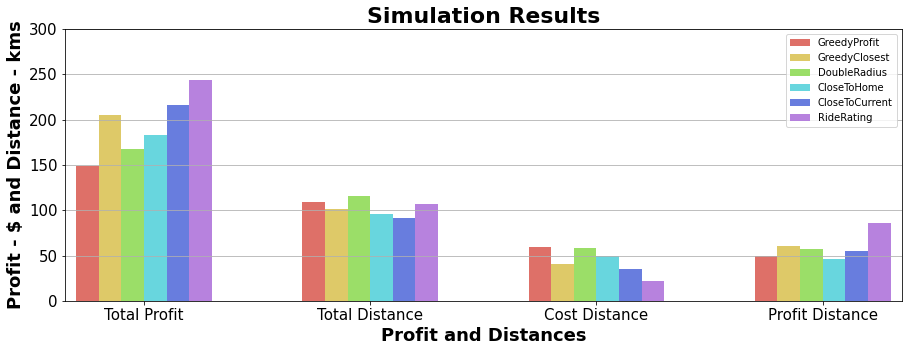

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------



[[148.67, 109.39, 59.93, 49.47],
 [205.21, 101.06, 40.98, 60.08],
 [168.02, 115.18, 57.97, 57.21],
 [183.32, 95.36, 49.03, 46.33],
 [215.81, 90.95, 35.63, 55.32],
 [243.88, 107.02, 21.47, 85.55]]

In [630]:
# compare simulations example
compareSimulations (df_monday, "2015-06-22 12:00:00 UTC", "2015-06-22 17:00:00 UTC", 3, 5, 2, 5, 0.1)

# Average Simulations

To run all algorithms on multiple datasets and times and then get the average results (what is used in reporting in the paper):

```python
averageSimulations(dataToUse, dates, times, speed, nextRideThreshold, minRadius, maxRadius,  minRating):
```

Where variables to choose from include:
```python
dataToUse = [] # list containing the dataframes/days you want to test (ex: [df_monday, df_wednesday, df_friday, df_sunday])
dates = [] # list of dates corresponding to the days you chose. Indexed date should correspond to index of dataToUse (ex: ['2015-06-22', '2015-06-24', '2015-06-26', '2015-06-28'] if using example dataToUse)
times = [] # list of start and end times you want to use (ex: ['00:00:00 03:00:00', '08:00:00 12:00:00', '12:00:00 16:00:00', '12:00:00 20:00:00', '16:00:00 22:00:00'])
speed = x # choose any positive value, speed is in mins/km (type = int)
nextRideThreshold = x # choose any positive value which will show x rides to the driver at a time (type = int)
minRadius = x # any positive value greater than 0 (type = int)
maxRadius = x # any positive value greater than minRadius (type = int)
minRating = x # any value for which you want ratings to be higher (to be competitive this should be above 0) (type = float)
```

901it [00:00, 8901.06it/s]

Simulating on 2015-06-22, starting at 00:00:00, and ending at 03:00:00


18365it [00:24, 756.31it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:04 - PickupDistance: 8.25 - DropoffDistance: 13.85 - TotalTime: 66.3 - Profit: 37.12
CurrentProgress: 36.86%
Current Radius: None kms
Ride Info -> StartTime: 01:06:55 - PickupDistance: 21.14 - DropoffDistance: 21.08 - TotalTime: 126.68 - Profit: 55.21

Simulation greedyProfit Results:
Ride Count: 2
Total Profit: 92.33
Total Distance: 64.33
Non-paid Distance: 29.39
Paid Distance: 34.93
Distance from Home: 3.1
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:08 - PickupDistance: 2.28 - DropoffDistance: 4.23 - TotalTime: 19.52 - Profit: 13.06
CurrentProgress: 10.92%
Current Radius: None kms
Ride Info -> StartTime: 00:20:02 - PickupDistance: 2.06 - DropoffDistance: 2.

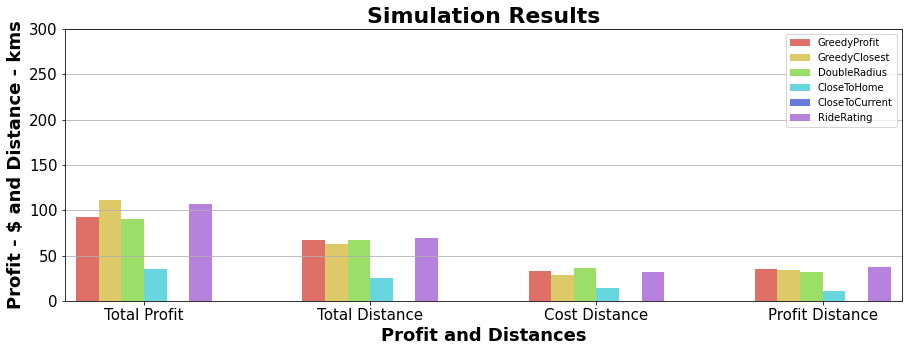

39it [00:00, 383.90it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 08:00:00, and ending at 12:00:00


18365it [00:21, 871.24it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:04 - PickupDistance: 20.16 - DropoffDistance: 21.65 - TotalTime: 125.43 - Profit: 56.62
CurrentProgress: 52.29%
Current Radius: None kms
Ride Info -> StartTime: 10:06:08 - PickupDistance: 3.13 - DropoffDistance: 7.89 - TotalTime: 33.04 - Profit: 22.22
CurrentProgress: 66.32%
Current Radius: None kms
Ride Info -> StartTime: 10:39:11 - PickupDistance: 5.41 - DropoffDistance: 1.41 - TotalTime: 20.43 - Profit: 6.01
CurrentProgress: 74.84%
Current Radius: None kms
Ride Info -> StartTime: 10:59:39 - PickupDistance: 9.14 - DropoffDistance: 10.93 - TotalTime: 60.23 - Profit: 29.83
CurrentProgress: 99.94%
Current Radius: None kms
Ride Info -> StartTime: 11:59:52 - PickupDistance: 1.61 - DropoffDistance: 1.28 - TotalTime: 8.68 - Profit: 5.7

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 120.39
Total Distance: 82.61
Non-paid Distance: 39.45
Paid Distance: 43.16
Distance 

CurrentProgress: 68.29%
Current Radius: 2 kms
Ride Info -> StartTime: 10:44:15 - PickupDistance: 0.84 - DropoffDistance: 0.72 - TotalTime: 4.66 - Profit: 4.3
CurrentProgress: 70.8%
Current Radius: 2 kms
Ride Info -> StartTime: 10:50:02 - PickupDistance: 0.99 - DropoffDistance: 1.13 - TotalTime: 6.38 - Profit: 5.34
CurrentProgress: 73.77%
Current Radius: 2 kms
Ride Info -> StartTime: 10:57:11 - PickupDistance: 1.13 - DropoffDistance: 1.17 - TotalTime: 6.88 - Profit: 5.42
CurrentProgress: 77.49%
Current Radius: 2 kms
Ride Info -> StartTime: 11:06:00 - PickupDistance: 1.18 - DropoffDistance: 0.99 - TotalTime: 6.5 - Profit: 4.98
CurrentProgress: 80.2%
Current Radius: 2 kms
Ride Info -> StartTime: 11:12:56 - PickupDistance: 0.83 - DropoffDistance: 0.97 - TotalTime: 5.39 - Profit: 4.92
CurrentProgress: 83.22%
Current Radius: 2 kms
Ride Info -> StartTime: 11:20:00 - PickupDistance: 1.27 - DropoffDistance: 0.56 - TotalTime: 5.5 - Profit: 3.9
CurrentProgress: 85.62%
Current Radius: 2 kms
Ride I

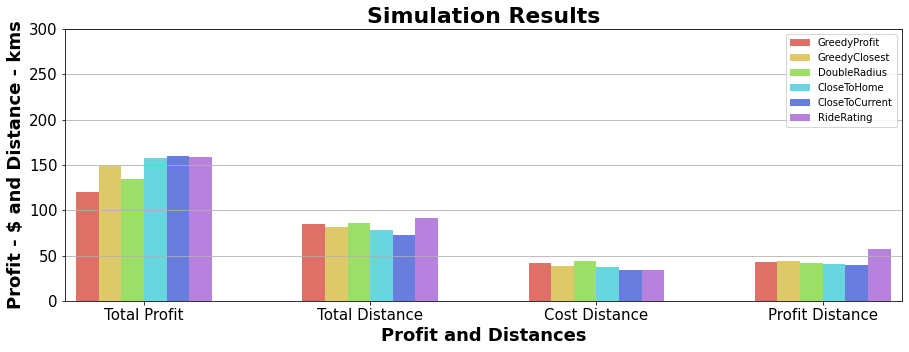

36it [00:00, 352.11it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 12:00:00, and ending at 16:00:00


18365it [00:21, 842.72it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:15 - PickupDistance: 1.77 - DropoffDistance: 2.73 - TotalTime: 13.48 - Profit: 9.32
CurrentProgress: 5.72%
Current Radius: None kms
Ride Info -> StartTime: 12:13:58 - PickupDistance: 11.28 - DropoffDistance: 8.91 - TotalTime: 60.59 - Profit: 24.78
CurrentProgress: 31.06%
Current Radius: None kms
Ride Info -> StartTime: 13:15:02 - PickupDistance: 9.43 - DropoffDistance: 3.74 - TotalTime: 39.52 - Profit: 11.86
CurrentProgress: 47.73%
Current Radius: None kms
Ride Info -> StartTime: 13:54:43 - PickupDistance: 5.78 - DropoffDistance: 4.4 - TotalTime: 30.56 - Profit: 13.5
CurrentProgress: 60.53%
Current Radius: None kms
Ride Info -> StartTime: 14:25:27 - PickupDistance: 2.61 - DropoffDistance: 3.96 - TotalTime: 19.69 - Profit: 12.4
CurrentProgress: 68.81%
Current Radius: None kms
Ride Info -> StartTime: 14:45:14 - PickupDistance: 3.63 - DropoffDistance: 3.81 - TotalTime: 22.33 - 

CurrentProgress: 20.19%
Current Radius: 3.9906249999999996 kms
Ride Info -> StartTime: 12:48:30 - PickupDistance: 1.93 - DropoffDistance: 2.05 - TotalTime: 11.93 - Profit: 7.62
CurrentProgress: 25.17%
Current Radius: 3.741319444444444 kms
Ride Info -> StartTime: 13:00:28 - PickupDistance: 2.98 - DropoffDistance: 1.59 - TotalTime: 13.71 - Profit: 6.48
CurrentProgress: 30.9%
Current Radius: 3.454861111111111 kms
Ride Info -> StartTime: 13:14:19 - PickupDistance: 1.55 - DropoffDistance: 2.34 - TotalTime: 11.68 - Profit: 8.36
CurrentProgress: 35.96%
Current Radius: 3.2020833333333334 kms
Ride Info -> StartTime: 13:26:22 - PickupDistance: 1.03 - DropoffDistance: 2.55 - TotalTime: 10.75 - Profit: 8.88
CurrentProgress: 40.63%
Current Radius: 2.9684027777777775 kms
Ride Info -> StartTime: 13:37:31 - PickupDistance: 2.7 - DropoffDistance: 1.55 - TotalTime: 12.75 - Profit: 6.37
CurrentProgress: 45.94%
Current Radius: 2.703125 kms
Ride Info -> StartTime: 13:50:23 - PickupDistance: 2.92 - DropoffD

CurrentProgress: 33.61%
Current Radius: None kms
Ride Info -> StartTime: 13:21:11 - PickupDistance: 2.37 - DropoffDistance: 8.42 - TotalTime: 32.39 - Profit: 23.56
CurrentProgress: 47.32%
Current Radius: None kms
Ride Info -> StartTime: 13:53:40 - PickupDistance: 1.04 - DropoffDistance: 9.13 - TotalTime: 30.52 - Profit: 25.33
CurrentProgress: 60.08%
Current Radius: None kms
Ride Info -> StartTime: 14:24:24 - PickupDistance: 2.65 - DropoffDistance: 19.23 - TotalTime: 65.64 - Profit: 50.58
CurrentProgress: 87.51%
Current Radius: None kms
Ride Info -> StartTime: 15:30:10 - PickupDistance: 0.66 - DropoffDistance: 20.89 - TotalTime: 64.65 - Profit: 54.73

Simulation rating Results:
Ride Count: 10
Total Profit: 216.45
Total Distance: 90.51
Non-paid Distance: 13.93
Paid Distance: 76.58
Distance from Home: 1.77
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
   

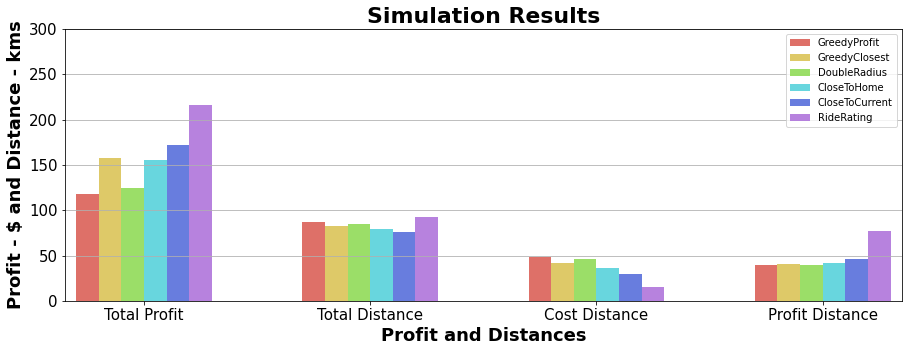

71it [00:00, 331.24it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 12:00:00, and ending at 20:00:00


18365it [00:17, 1044.29it/s]


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:15 - PickupDistance: 1.7 - DropoffDistance: 2.73 - TotalTime: 13.29 - Profit: 9.32
CurrentProgress: 2.82%
Current Radius: None kms
Ride Info -> StartTime: 12:13:58 - PickupDistance: 11.28 - DropoffDistance: 8.91 - TotalTime: 60.59 - Profit: 24.78
CurrentProgress: 15.53%
Current Radius: None kms
Ride Info -> StartTime: 13:15:02 - PickupDistance: 9.43 - DropoffDistance: 3.74 - TotalTime: 39.52 - Profit: 11.86
CurrentProgress: 23.86%
Current Radius: None kms
Ride Info -> StartTime: 13:54:43 - PickupDistance: 5.78 - DropoffDistance: 4.4 - TotalTime: 30.56 - Profit: 13.5
CurrentProgress: 30.26%
Current Radius: None kms
Ride Info -> StartTime: 14:25:27 - PickupDistance: 2.61 - DropoffDistance: 3.96 - TotalTime: 19.69 - Profit: 12.4
CurrentProgress: 34.4%
Current Radius: None kms
Ride Info -> StartTime: 14:45:14 - PickupDistance: 3.63 - DropoffDistance: 3.81 - TotalTime: 22.33 - Pr

CurrentProgress: 81.18%
Current Radius: None kms
Ride Info -> StartTime: 18:29:55 - PickupDistance: 0.75 - DropoffDistance: 7.16 - TotalTime: 23.74 - Profit: 20.41
CurrentProgress: 86.18%
Current Radius: None kms
Ride Info -> StartTime: 18:53:46 - PickupDistance: 0.29 - DropoffDistance: 6.06 - TotalTime: 19.03 - Profit: 17.64
CurrentProgress: 90.16%
Current Radius: None kms
Ride Info -> StartTime: 19:12:49 - PickupDistance: 6.94 - DropoffDistance: 2.65 - TotalTime: 28.77 - Profit: 9.12
CurrentProgress: 96.16%
Current Radius: None kms
Ride Info -> StartTime: 19:42:12 - PickupDistance: 5.51 - DropoffDistance: 2.7 - TotalTime: 24.64 - Profit: 9.25

Simulation greedyClosest Results:
Ride Count: 37
Total Profit: 303.7
Total Distance: 160.01
Non-paid Distance: 75.53
Paid Distance: 84.48
Distance from Home: 2.81
Finished Simulation greedyClosest.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation doubleRadius

CurrentProgress: 62.81%
Current Radius: 2 kms
Ride Info -> StartTime: 17:01:35 - PickupDistance: 0.42 - DropoffDistance: 2.66 - TotalTime: 9.25 - Profit: 9.16
CurrentProgress: 65.06%
Current Radius: 2 kms
Ride Info -> StartTime: 17:12:19 - PickupDistance: 0.9 - DropoffDistance: 1.37 - TotalTime: 6.81 - Profit: 5.92
CurrentProgress: 66.85%
Current Radius: 2 kms
Ride Info -> StartTime: 17:20:55 - PickupDistance: 0.97 - DropoffDistance: 1.85 - TotalTime: 8.45 - Profit: 7.12
CurrentProgress: 68.64%
Current Radius: 2 kms
Ride Info -> StartTime: 17:29:42 - PickupDistance: 0.93 - DropoffDistance: 2.4 - TotalTime: 10.0 - Profit: 8.51
CurrentProgress: 70.95%
Current Radius: 2 kms
Ride Info -> StartTime: 17:40:36 - PickupDistance: 1.8 - DropoffDistance: 2.23 - TotalTime: 12.09 - Profit: 8.08
CurrentProgress: 73.49%
Current Radius: 2 kms
Ride Info -> StartTime: 17:52:48 - PickupDistance: 2.91 - DropoffDistance: 1.9 - TotalTime: 14.42 - Profit: 7.25
CurrentProgress: 76.92%
Current Radius: 2 kms
Ri

CurrentProgress: 66.84%
Current Radius: None kms
Ride Info -> StartTime: 17:20:55 - PickupDistance: 1.85 - DropoffDistance: 1.85 - TotalTime: 11.08 - Profit: 7.12
CurrentProgress: 69.47%
Current Radius: None kms
Ride Info -> StartTime: 17:33:33 - PickupDistance: 2.0 - DropoffDistance: 1.56 - TotalTime: 10.68 - Profit: 6.41
CurrentProgress: 71.71%
Current Radius: None kms
Ride Info -> StartTime: 17:44:38 - PickupDistance: 1.79 - DropoffDistance: 1.67 - TotalTime: 10.4 - Profit: 6.68
CurrentProgress: 74.63%
Current Radius: None kms
Ride Info -> StartTime: 17:58:23 - PickupDistance: 1.35 - DropoffDistance: 3.38 - TotalTime: 14.16 - Profit: 10.94
CurrentProgress: 78.3%
Current Radius: None kms
Ride Info -> StartTime: 18:15:54 - PickupDistance: 1.96 - DropoffDistance: 2.01 - TotalTime: 11.92 - Profit: 7.53
CurrentProgress: 81.09%
Current Radius: None kms
Ride Info -> StartTime: 18:29:30 - PickupDistance: 1.31 - DropoffDistance: 4.01 - TotalTime: 15.95 - Profit: 12.53
CurrentProgress: 84.51%

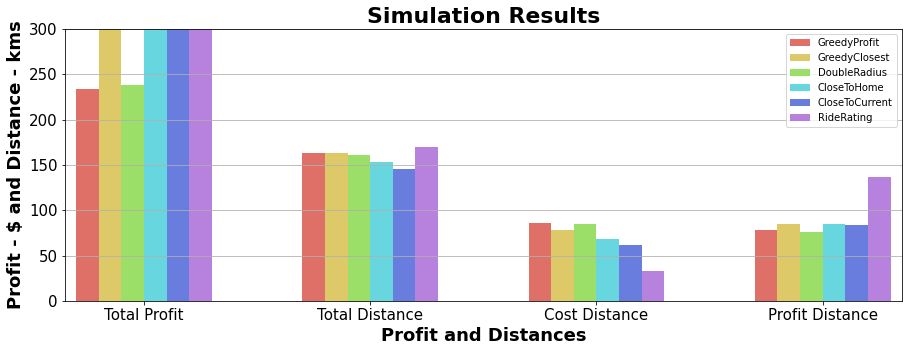

35it [00:00, 345.75it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 16:00:00, and ending at 22:00:00


18365it [00:19, 921.41it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:45 - PickupDistance: 0.18 - DropoffDistance: 18.26 - TotalTime: 55.32 - Profit: 48.14
CurrentProgress: 15.57%
Current Radius: None kms
Ride Info -> StartTime: 16:56:21 - PickupDistance: 17.84 - DropoffDistance: 7.2 - TotalTime: 75.12 - Profit: 20.5
CurrentProgress: 36.52%
Current Radius: None kms
Ride Info -> StartTime: 18:11:37 - PickupDistance: 7.88 - DropoffDistance: 9.2 - TotalTime: 51.25 - Profit: 25.51
CurrentProgress: 50.8%
Current Radius: None kms
Ride Info -> StartTime: 19:03:06 - PickupDistance: 12.76 - DropoffDistance: 4.38 - TotalTime: 51.42 - Profit: 13.44
CurrentProgress: 65.14%
Current Radius: None kms
Ride Info -> StartTime: 19:54:36 - PickupDistance: 21.68 - DropoffDistance: 21.04 - TotalTime: 128.15 - Profit: 55.1

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 162.69
Total Distance: 120.42
Non-paid Distance: 60.34
Paid Distance: 60.08
Distanc

CurrentProgress: 21.33%
Current Radius: 3.9335648148148152 kms
Ride Info -> StartTime: 17:16:56 - PickupDistance: 2.24 - DropoffDistance: 2.41 - TotalTime: 13.95 - Profit: 8.54
CurrentProgress: 25.31%
Current Radius: 3.734722222222222 kms
Ride Info -> StartTime: 17:31:28 - PickupDistance: 2.65 - DropoffDistance: 5.76 - TotalTime: 25.23 - Profit: 16.9
CurrentProgress: 32.41%
Current Radius: 3.379398148148148 kms
Ride Info -> StartTime: 17:56:42 - PickupDistance: 2.91 - DropoffDistance: 1.57 - TotalTime: 13.46 - Profit: 6.44
CurrentProgress: 36.15%
Current Radius: 3.192361111111111 kms
Ride Info -> StartTime: 18:10:15 - PickupDistance: 2.52 - DropoffDistance: 2.83 - TotalTime: 16.03 - Profit: 9.56
CurrentProgress: 40.75%
Current Radius: 2.9625000000000004 kms
Ride Info -> StartTime: 18:26:48 - PickupDistance: 2.79 - DropoffDistance: 3.84 - TotalTime: 19.88 - Profit: 12.1
CurrentProgress: 46.3%
Current Radius: 2.685185185185185 kms
Ride Info -> StartTime: 18:46:51 - PickupDistance: 0.01 -

CurrentProgress: 62.07%
Current Radius: None kms
Ride Info -> StartTime: 19:43:35 - PickupDistance: 1.92 - DropoffDistance: 1.74 - TotalTime: 10.96 - Profit: 6.84
CurrentProgress: 65.15%
Current Radius: None kms
Ride Info -> StartTime: 19:54:38 - PickupDistance: 1.8 - DropoffDistance: 2.52 - TotalTime: 12.98 - Profit: 8.8
CurrentProgress: 69.64%
Current Radius: None kms
Ride Info -> StartTime: 20:10:47 - PickupDistance: 1.47 - DropoffDistance: 0.6 - TotalTime: 6.23 - Profit: 4.01
CurrentProgress: 72.15%
Current Radius: None kms
Ride Info -> StartTime: 20:20:05 - PickupDistance: 0.25 - DropoffDistance: 1.27 - TotalTime: 4.58 - Profit: 5.68
CurrentProgress: 73.63%
Current Radius: None kms
Ride Info -> StartTime: 20:25:08 - PickupDistance: 0.67 - DropoffDistance: 0.98 - TotalTime: 4.93 - Profit: 4.94
CurrentProgress: 75.01%
Current Radius: None kms
Ride Info -> StartTime: 20:30:16 - PickupDistance: 1.53 - DropoffDistance: 3.72 - TotalTime: 15.75 - Profit: 11.81
CurrentProgress: 80.08%
Cur

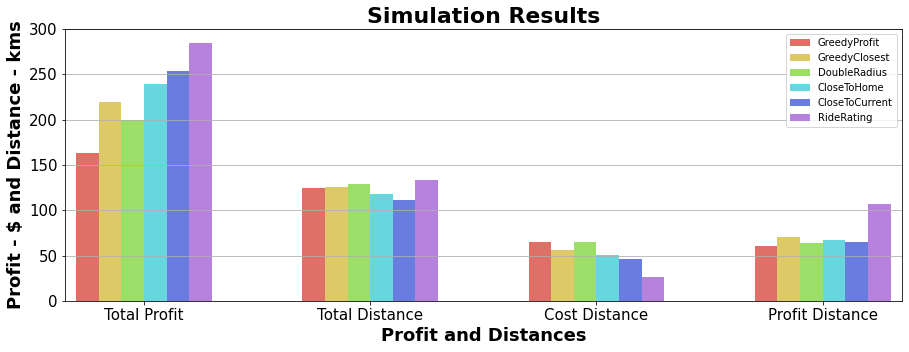

1197it [00:00, 11643.63it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 00:00:00, and ending at 03:00:00


19885it [00:30, 655.67it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:04 - PickupDistance: 1.69 - DropoffDistance: 9.72 - TotalTime: 34.25 - Profit: 26.81
CurrentProgress: 19.06%
Current Radius: None kms
Ride Info -> StartTime: 00:34:46 - PickupDistance: 10.56 - DropoffDistance: 10.18 - TotalTime: 62.23 - Profit: 27.95
CurrentProgress: 53.89%
Current Radius: None kms
Ride Info -> StartTime: 01:38:04 - PickupDistance: 26.2 - DropoffDistance: 21.17 - TotalTime: 142.11 - Profit: 55.43

Simulation greedyProfit Results:
Ride Count: 3
Total Profit: 110.18
Total Distance: 79.53
Non-paid Distance: 38.46
Paid Distance: 41.07
Distance from Home: 1.97
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:22 - PickupDistance: 1.54 - DropoffDistance:

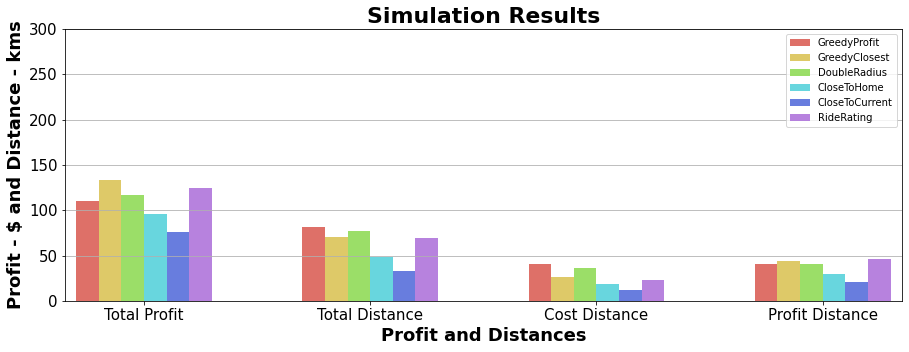

32it [00:00, 317.13it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 08:00:00, and ending at 12:00:00


19885it [00:27, 727.90it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:08 - PickupDistance: 2.87 - DropoffDistance: 22.12 - TotalTime: 74.97 - Profit: 57.8
CurrentProgress: 31.29%
Current Radius: None kms
Ride Info -> StartTime: 09:15:16 - PickupDistance: 20.65 - DropoffDistance: 4.19 - TotalTime: 74.53 - Profit: 12.97
CurrentProgress: 62.41%
Current Radius: None kms
Ride Info -> StartTime: 10:30:04 - PickupDistance: 0.63 - DropoffDistance: 20.4 - TotalTime: 63.09 - Profit: 53.49
CurrentProgress: 88.81%
Current Radius: None kms
Ride Info -> StartTime: 11:33:11 - PickupDistance: 21.12 - DropoffDistance: 1.7 - TotalTime: 68.46 - Profit: 6.76

Simulation greedyProfit Results:
Ride Count: 4
Total Profit: 131.02
Total Distance: 93.68
Non-paid Distance: 45.27
Paid Distance: 48.41
Distance from Home: 2.32
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

CurrentProgress: 42.97%
Current Radius: 2.8517361111111112 kms
Ride Info -> StartTime: 09:43:16 - PickupDistance: 2.33 - DropoffDistance: 2.3 - TotalTime: 13.89 - Profit: 8.26
CurrentProgress: 48.81%
Current Radius: 2.559375 kms
Ride Info -> StartTime: 09:57:39 - PickupDistance: 2.26 - DropoffDistance: 2.4 - TotalTime: 13.97 - Profit: 8.5
CurrentProgress: 55.1%
Current Radius: 2.245138888888889 kms
Ride Info -> StartTime: 10:12:37 - PickupDistance: 1.69 - DropoffDistance: 0.74 - TotalTime: 7.29 - Profit: 4.35
CurrentProgress: 58.29%
Current Radius: 2.0854166666666667 kms
Ride Info -> StartTime: 10:20:03 - PickupDistance: 1.85 - DropoffDistance: 2.15 - TotalTime: 12.01 - Profit: 7.88
CurrentProgress: 63.35%
Current Radius: 2 kms
Ride Info -> StartTime: 10:32:42 - PickupDistance: 2.26 - DropoffDistance: 1.69 - TotalTime: 11.85 - Profit: 6.72
CurrentProgress: 68.56%
Current Radius: 2 kms
Ride Info -> StartTime: 10:44:37 - PickupDistance: 2.09 - DropoffDistance: 0.54 - TotalTime: 7.91 - Pr

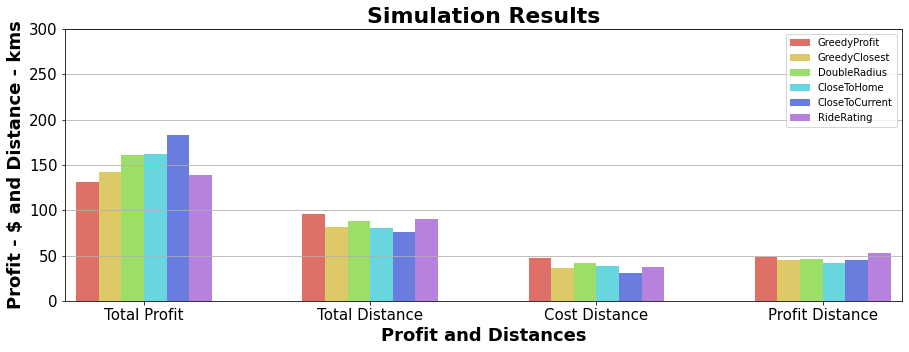

61it [00:00, 296.54it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 12:00:00, and ending at 16:00:00


19885it [00:29, 673.24it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:13 - PickupDistance: 3.98 - DropoffDistance: 2.92 - TotalTime: 20.69 - Profit: 9.8
CurrentProgress: 8.71%
Current Radius: None kms
Ride Info -> StartTime: 12:20:59 - PickupDistance: 4.11 - DropoffDistance: 4.31 - TotalTime: 25.27 - Profit: 13.28
CurrentProgress: 19.27%
Current Radius: None kms
Ride Info -> StartTime: 12:46:20 - PickupDistance: 1.65 - DropoffDistance: 5.42 - TotalTime: 21.22 - Profit: 16.05
CurrentProgress: 28.15%
Current Radius: None kms
Ride Info -> StartTime: 13:07:39 - PickupDistance: 21.08 - DropoffDistance: 15.31 - TotalTime: 109.18 - Profit: 40.78
CurrentProgress: 73.67%
Current Radius: None kms
Ride Info -> StartTime: 14:57:11 - PickupDistance: 11.19 - DropoffDistance: 18.56 - TotalTime: 89.24 - Profit: 48.89

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 128.81
Total Distance: 88.54
Non-paid Distance: 42.01
Paid Distance: 46.52
Distanc

CurrentProgress: 43.92%
Current Radius: 2.803819444444444 kms
Ride Info -> StartTime: 13:45:40 - PickupDistance: 1.79 - DropoffDistance: 1.04 - TotalTime: 8.5 - Profit: 5.09
CurrentProgress: 47.61%
Current Radius: 2.6194444444444445 kms
Ride Info -> StartTime: 13:54:35 - PickupDistance: 0.44 - DropoffDistance: 1.74 - TotalTime: 6.51 - Profit: 6.84
CurrentProgress: 50.75%
Current Radius: 2.4625000000000004 kms
Ride Info -> StartTime: 14:02:02 - PickupDistance: 2.0 - DropoffDistance: 2.89 - TotalTime: 14.67 - Profit: 9.74
CurrentProgress: 57.02%
Current Radius: 2.1489583333333333 kms
Ride Info -> StartTime: 14:17:12 - PickupDistance: 1.42 - DropoffDistance: 1.79 - TotalTime: 9.64 - Profit: 6.97
CurrentProgress: 61.18%
Current Radius: 2 kms
Ride Info -> StartTime: 14:26:53 - PickupDistance: 1.0 - DropoffDistance: 2.24 - TotalTime: 9.73 - Profit: 8.1
CurrentProgress: 65.35%
Current Radius: 2 kms
Ride Info -> StartTime: 14:36:59 - PickupDistance: 0.93 - DropoffDistance: 1.94 - TotalTime: 8.

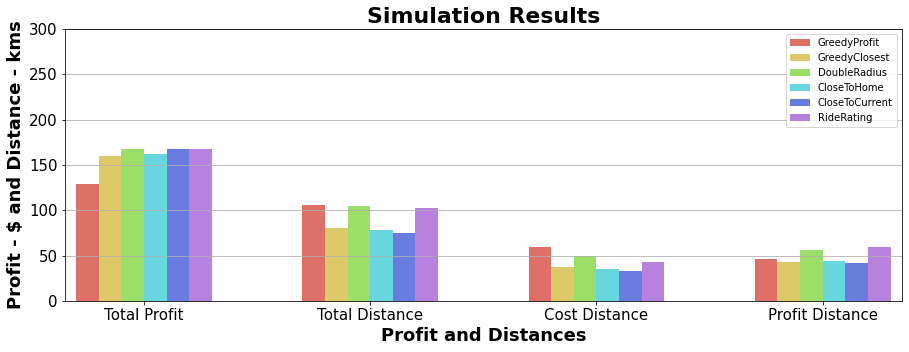

67it [00:00, 327.24it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 12:00:00, and ending at 20:00:00


19885it [00:27, 710.71it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:13 - PickupDistance: 3.92 - DropoffDistance: 2.92 - TotalTime: 20.52 - Profit: 9.8
CurrentProgress: 4.32%
Current Radius: None kms
Ride Info -> StartTime: 12:20:52 - PickupDistance: 1.66 - DropoffDistance: 2.11 - TotalTime: 11.31 - Profit: 7.78
CurrentProgress: 6.7%
Current Radius: None kms
Ride Info -> StartTime: 12:32:23 - PickupDistance: 2.73 - DropoffDistance: 2.78 - TotalTime: 16.54 - Profit: 9.46
CurrentProgress: 10.19%
Current Radius: None kms
Ride Info -> StartTime: 12:48:58 - PickupDistance: 1.08 - DropoffDistance: 5.88 - TotalTime: 20.87 - Profit: 17.19
CurrentProgress: 14.55%
Current Radius: None kms
Ride Info -> StartTime: 13:09:50 - PickupDistance: 0.51 - DropoffDistance: 3.92 - TotalTime: 13.3 - Profit: 12.31
CurrentProgress: 17.32%
Current Radius: None kms
Ride Info -> StartTime: 13:23:17 - PickupDistance: 1.59 - DropoffDistance: 19.78 - TotalTime: 64.12 - Pro

CurrentProgress: 90.55%
Current Radius: None kms
Ride Info -> StartTime: 19:14:42 - PickupDistance: 0.48 - DropoffDistance: 1.19 - TotalTime: 5.0 - Profit: 5.47
CurrentProgress: 91.6%
Current Radius: None kms
Ride Info -> StartTime: 19:19:42 - PickupDistance: 1.63 - DropoffDistance: 1.56 - TotalTime: 9.56 - Profit: 6.4
CurrentProgress: 93.59%
Current Radius: None kms
Ride Info -> StartTime: 19:29:27 - PickupDistance: 0.63 - DropoffDistance: 1.14 - TotalTime: 5.32 - Profit: 5.36
CurrentProgress: 94.74%
Current Radius: None kms
Ride Info -> StartTime: 19:35:01 - PickupDistance: 1.57 - DropoffDistance: 2.35 - TotalTime: 11.76 - Profit: 8.37
CurrentProgress: 97.24%
Current Radius: None kms
Ride Info -> StartTime: 19:46:47 - PickupDistance: 2.03 - DropoffDistance: 2.73 - TotalTime: 14.28 - Profit: 9.32

Simulation greedyClosest Results:
Ride Count: 41
Total Profit: 347.86
Total Distance: 157.83
Non-paid Distance: 59.69
Paid Distance: 98.14
Distance from Home: 3.92
Finished Simulation greedy

CurrentProgress: 68.6%
Current Radius: 2 kms
Ride Info -> StartTime: 17:29:32 - PickupDistance: 0.94 - DropoffDistance: 2.53 - TotalTime: 10.41 - Profit: 8.83
CurrentProgress: 70.82%
Current Radius: 2 kms
Ride Info -> StartTime: 17:40:02 - PickupDistance: 0.95 - DropoffDistance: 1.69 - TotalTime: 7.94 - Profit: 6.73
CurrentProgress: 72.49%
Current Radius: 2 kms
Ride Info -> StartTime: 17:48:44 - PickupDistance: 1.23 - DropoffDistance: 1.99 - TotalTime: 9.66 - Profit: 7.49
CurrentProgress: 74.91%
Current Radius: 2 kms
Ride Info -> StartTime: 17:59:44 - PickupDistance: 1.5 - DropoffDistance: 2.4 - TotalTime: 11.72 - Profit: 8.51
CurrentProgress: 77.6%
Current Radius: 2 kms
Ride Info -> StartTime: 18:12:33 - PickupDistance: 1.58 - DropoffDistance: 1.04 - TotalTime: 7.86 - Profit: 5.11
CurrentProgress: 79.32%
Current Radius: 2 kms
Ride Info -> StartTime: 18:20:55 - PickupDistance: 1.65 - DropoffDistance: 1.42 - TotalTime: 9.22 - Profit: 6.05
CurrentProgress: 81.28%
Current Radius: 2 kms
Ri

CurrentProgress: 63.02%
Current Radius: None kms
Ride Info -> StartTime: 17:03:38 - PickupDistance: 1.52 - DropoffDistance: 1.33 - TotalTime: 8.56 - Profit: 5.82
CurrentProgress: 66.23%
Current Radius: None kms
Ride Info -> StartTime: 17:18:00 - PickupDistance: 1.46 - DropoffDistance: 0.62 - TotalTime: 6.25 - Profit: 4.06
CurrentProgress: 67.55%
Current Radius: None kms
Ride Info -> StartTime: 17:24:25 - PickupDistance: 0.59 - DropoffDistance: 1.1 - TotalTime: 5.07 - Profit: 5.26
CurrentProgress: 68.67%
Current Radius: None kms
Ride Info -> StartTime: 17:30:04 - PickupDistance: 1.49 - DropoffDistance: 1.27 - TotalTime: 8.26 - Profit: 5.66
CurrentProgress: 70.53%
Current Radius: None kms
Ride Info -> StartTime: 17:38:56 - PickupDistance: 0.58 - DropoffDistance: 1.65 - TotalTime: 6.68 - Profit: 6.62
CurrentProgress: 72.0%
Current Radius: None kms
Ride Info -> StartTime: 17:45:39 - PickupDistance: 1.96 - DropoffDistance: 4.82 - TotalTime: 20.34 - Profit: 14.55
CurrentProgress: 76.66%
Curr

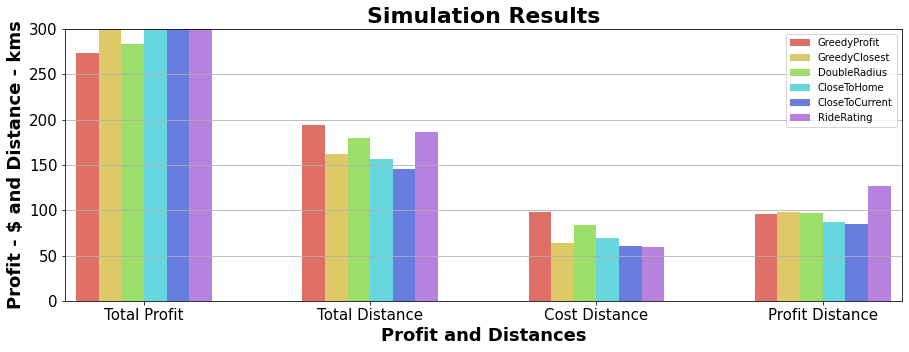

29it [00:00, 280.92it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 16:00:00, and ending at 22:00:00


19885it [00:28, 698.15it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:13 - PickupDistance: 1.99 - DropoffDistance: 2.71 - TotalTime: 14.09 - Profit: 9.28
CurrentProgress: 3.97%
Current Radius: None kms
Ride Info -> StartTime: 16:14:22 - PickupDistance: 1.69 - DropoffDistance: 15.4 - TotalTime: 51.27 - Profit: 41.0
CurrentProgress: 18.23%
Current Radius: None kms
Ride Info -> StartTime: 17:05:48 - PickupDistance: 19.89 - DropoffDistance: 5.27 - TotalTime: 75.5 - Profit: 15.68
CurrentProgress: 39.25%
Current Radius: None kms
Ride Info -> StartTime: 18:21:28 - PickupDistance: 1.62 - DropoffDistance: 4.45 - TotalTime: 18.22 - Profit: 13.63
CurrentProgress: 44.36%
Current Radius: None kms
Ride Info -> StartTime: 18:39:49 - PickupDistance: 4.4 - DropoffDistance: 5.62 - TotalTime: 30.06 - Profit: 16.55
CurrentProgress: 52.74%
Current Radius: None kms
Ride Info -> StartTime: 19:09:56 - PickupDistance: 4.91 - DropoffDistance: 2.83 - TotalTime: 23.22 - 

CurrentProgress: 5.69%
Current Radius: 16 kms
Ride Info -> StartTime: 16:20:36 - PickupDistance: 8.0 - DropoffDistance: 11.76 - TotalTime: 59.28 - Profit: 31.9
CurrentProgress: 22.19%
Current Radius: 16 kms
Ride Info -> StartTime: 17:19:56 - PickupDistance: 1.53 - DropoffDistance: 1.56 - TotalTime: 9.27 - Profit: 6.41
CurrentProgress: 24.78%
Current Radius: 16 kms
Ride Info -> StartTime: 17:29:27 - PickupDistance: 2.29 - DropoffDistance: 4.47 - TotalTime: 20.27 - Profit: 13.67
CurrentProgress: 30.48%
Current Radius: 16 kms
Ride Info -> StartTime: 17:49:44 - PickupDistance: 3.82 - DropoffDistance: 2.82 - TotalTime: 19.9 - Profit: 9.55
CurrentProgress: 36.01%
Current Radius: 16 kms
Ride Info -> StartTime: 18:09:48 - PickupDistance: 2.57 - DropoffDistance: 1.04 - TotalTime: 10.83 - Profit: 5.1
CurrentProgress: 39.06%
Current Radius: 16 kms
Ride Info -> StartTime: 18:20:54 - PickupDistance: 1.34 - DropoffDistance: 2.2 - TotalTime: 10.61 - Profit: 8.0
CurrentProgress: 42.08%
Current Radius:

CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:11 - PickupDistance: 0.46 - DropoffDistance: 1.33 - TotalTime: 5.36 - Profit: 5.82
CurrentProgress: 2.61%
Current Radius: None kms
Ride Info -> StartTime: 16:09:33 - PickupDistance: 1.08 - DropoffDistance: 0.93 - TotalTime: 6.03 - Profit: 4.84
CurrentProgress: 4.32%
Current Radius: None kms
Ride Info -> StartTime: 16:15:34 - PickupDistance: 1.51 - DropoffDistance: 1.33 - TotalTime: 8.5 - Profit: 5.81
CurrentProgress: 6.92%
Current Radius: None kms
Ride Info -> StartTime: 16:25:06 - PickupDistance: 0.71 - DropoffDistance: 1.27 - TotalTime: 5.94 - Profit: 5.68
CurrentProgress: 9.5%
Current Radius: None kms
Ride Info -> StartTime: 16:34:25 - PickupDistance: 0.8 - DropoffDistance: 0.94 - TotalTime: 5.22 - Profit: 4.85
CurrentProgress: 11.23%
Current Radius: None kms
Ride Info -> StartTime: 16:40:46 - PickupDistance: 0.71 - DropoffDistance: 2.51 - TotalTime: 9.66 - Profit: 8.77
CurrentProgress: 14.51%
Current Radiu

CurrentProgress: 84.82%
Current Radius: None kms
Ride Info -> StartTime: 21:05:32 - PickupDistance: 2.55 - DropoffDistance: 4.79 - TotalTime: 22.03 - Profit: 14.47
CurrentProgress: 90.99%
Current Radius: None kms
Ride Info -> StartTime: 21:27:43 - PickupDistance: 2.77 - DropoffDistance: 10.43 - TotalTime: 39.59 - Profit: 28.57

Simulation rating Results:
Ride Count: 16
Total Profit: 278.02
Total Distance: 120.87
Non-paid Distance: 25.66
Paid Distance: 95.21
Distance from Home: 11.74
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           221.21         260.31        192.81       238.50   
totalDistance         159.40         122.65        132.54       117.37   
costDistance           82.91          50.52         71.42        54.97   
profitDistance         76.49      

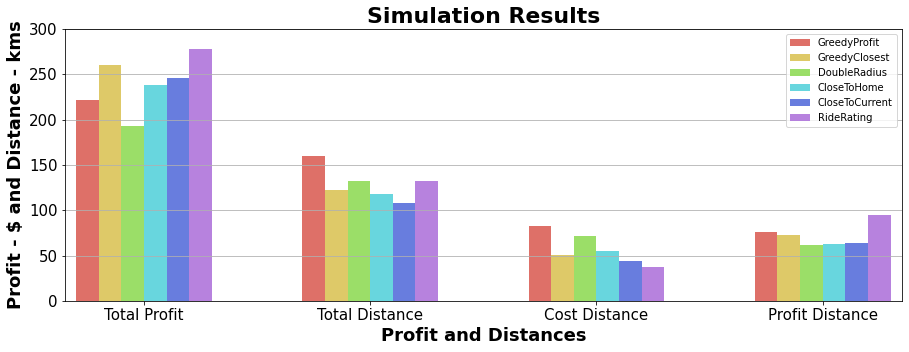

2076it [00:00, 10406.82it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 00:00:00, and ending at 03:00:00


21013it [00:33, 618.92it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:14 - PickupDistance: 2.49 - DropoffDistance: 5.88 - TotalTime: 25.12 - Profit: 17.2
CurrentProgress: 14.07%
Current Radius: None kms
Ride Info -> StartTime: 00:25:40 - PickupDistance: 6.42 - DropoffDistance: 7.44 - TotalTime: 41.57 - Profit: 21.1
CurrentProgress: 37.35%
Current Radius: None kms
Ride Info -> StartTime: 01:07:16 - PickupDistance: 8.16 - DropoffDistance: 11.65 - TotalTime: 59.41 - Profit: 31.62
CurrentProgress: 70.37%
Current Radius: None kms
Ride Info -> StartTime: 02:06:52 - PickupDistance: 10.25 - DropoffDistance: 4.64 - TotalTime: 44.67 - Profit: 14.09
CurrentProgress: 95.29%
Current Radius: None kms
Ride Info -> StartTime: 02:51:38 - PickupDistance: 2.81 - DropoffDistance: 6.01 - TotalTime: 26.46 - Profit: 17.53

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 101.53
Total Distance: 65.74
Non-paid Distance: 30.13
Paid Distance: 35.61
Distance 

CurrentProgress: 74.36%
Current Radius: None kms
Ride Info -> StartTime: 02:14:04 - PickupDistance: 0.69 - DropoffDistance: 1.51 - TotalTime: 6.6 - Profit: 6.27
CurrentProgress: 78.14%
Current Radius: None kms
Ride Info -> StartTime: 02:21:33 - PickupDistance: 0.39 - DropoffDistance: 2.74 - TotalTime: 9.37 - Profit: 9.34
CurrentProgress: 85.56%
Current Radius: None kms
Ride Info -> StartTime: 02:34:51 - PickupDistance: 1.54 - DropoffDistance: 2.85 - TotalTime: 13.16 - Profit: 9.63
CurrentProgress: 96.09%
Current Radius: None kms
Ride Info -> StartTime: 02:53:04 - PickupDistance: 0.68 - DropoffDistance: 3.65 - TotalTime: 13.01 - Profit: 11.63

Simulation closeToCurr Results:
Ride Count: 15
Total Profit: 127.59
Total Distance: 52.37
Non-paid Distance: 16.33
Paid Distance: 36.04
Distance from Home: 1.64
Finished Simulation closeToCurr.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation rating ->
CurrentPr

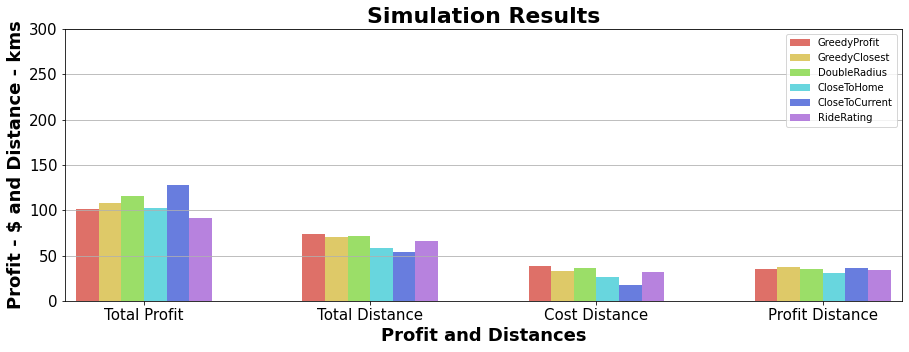

28it [00:00, 273.88it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 08:00:00, and ending at 12:00:00


21013it [00:34, 609.37it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:18 - PickupDistance: 3.71 - DropoffDistance: 10.2 - TotalTime: 41.73 - Profit: 28.01
CurrentProgress: 17.51%
Current Radius: None kms
Ride Info -> StartTime: 08:42:10 - PickupDistance: 4.76 - DropoffDistance: 2.12 - TotalTime: 20.66 - Profit: 7.81
CurrentProgress: 26.17%
Current Radius: None kms
Ride Info -> StartTime: 09:02:52 - PickupDistance: 1.93 - DropoffDistance: 4.81 - TotalTime: 20.25 - Profit: 14.54
CurrentProgress: 34.62%
Current Radius: None kms
Ride Info -> StartTime: 09:23:10 - PickupDistance: 20.44 - DropoffDistance: 21.17 - TotalTime: 124.81 - Profit: 55.42
CurrentProgress: 86.65%
Current Radius: None kms
Ride Info -> StartTime: 11:27:58 - PickupDistance: 0.58 - DropoffDistance: 2.01 - TotalTime: 7.76 - Profit: 7.52
CurrentProgress: 89.88%
Current Radius: None kms
Ride Info -> StartTime: 11:35:52 - PickupDistance: 2.53 - DropoffDistance: 2.63 - TotalTime: 15.4

CurrentProgress: 31.96%
Current Radius: 3.4020833333333336 kms
Ride Info -> StartTime: 09:16:53 - PickupDistance: 3.14 - DropoffDistance: 1.86 - TotalTime: 14.99 - Profit: 7.15
CurrentProgress: 38.28%
Current Radius: 3.0861111111111112 kms
Ride Info -> StartTime: 09:31:58 - PickupDistance: 2.93 - DropoffDistance: 2.78 - TotalTime: 17.13 - Profit: 9.46
CurrentProgress: 45.45%
Current Radius: 2.7274305555555554 kms
Ride Info -> StartTime: 09:49:10 - PickupDistance: 2.38 - DropoffDistance: 2.44 - TotalTime: 14.46 - Profit: 8.59
CurrentProgress: 52.27%
Current Radius: 2.3864583333333336 kms
Ride Info -> StartTime: 10:05:30 - PickupDistance: 1.31 - DropoffDistance: 1.23 - TotalTime: 7.62 - Profit: 5.58
CurrentProgress: 55.47%
Current Radius: 2.2267361111111112 kms
Ride Info -> StartTime: 10:13:19 - PickupDistance: 1.14 - DropoffDistance: 0.84 - TotalTime: 5.94 - Profit: 4.6
CurrentProgress: 58.09%
Current Radius: 2.095486111111111 kms
Ride Info -> StartTime: 10:20:03 - PickupDistance: 0.27 

CurrentProgress: 88.84%
Current Radius: None kms
Ride Info -> StartTime: 11:33:13 - PickupDistance: 0.73 - DropoffDistance: 1.43 - TotalTime: 6.48 - Profit: 6.08
CurrentProgress: 91.53%
Current Radius: None kms
Ride Info -> StartTime: 11:39:56 - PickupDistance: 1.34 - DropoffDistance: 2.26 - TotalTime: 10.81 - Profit: 8.15
CurrentProgress: 96.14%
Current Radius: None kms
Ride Info -> StartTime: 11:50:49 - PickupDistance: 4.6 - DropoffDistance: 10.2 - TotalTime: 44.4 - Profit: 27.99

Simulation rating Results:
Ride Count: 8
Total Profit: 202.56
Total Distance: 90.66
Non-paid Distance: 17.64
Paid Distance: 73.02
Distance from Home: 9.36
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           174.80         174.97        121.19       159.55   
totalDistance         118.5

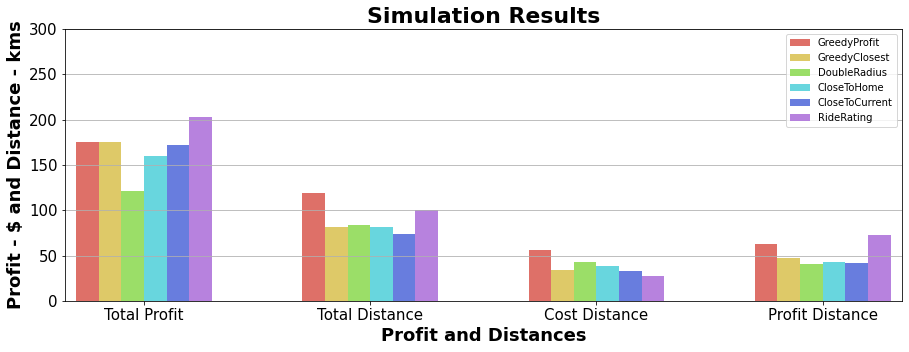

27it [00:00, 267.03it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 12:00:00, and ending at 16:00:00


21013it [00:34, 608.66it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:04 - PickupDistance: 1.18 - DropoffDistance: 9.96 - TotalTime: 33.42 - Profit: 27.4
CurrentProgress: 13.95%
Current Radius: None kms
Ride Info -> StartTime: 12:33:33 - PickupDistance: 9.4 - DropoffDistance: 3.71 - TotalTime: 39.33 - Profit: 11.76
CurrentProgress: 30.36%
Current Radius: None kms
Ride Info -> StartTime: 13:13:02 - PickupDistance: 4.93 - DropoffDistance: 5.86 - TotalTime: 32.35 - Profit: 17.14
CurrentProgress: 43.9%
Current Radius: None kms
Ride Info -> StartTime: 13:45:43 - PickupDistance: 4.89 - DropoffDistance: 5.11 - TotalTime: 30.0 - Profit: 15.27
CurrentProgress: 56.54%
Current Radius: None kms
Ride Info -> StartTime: 14:15:47 - PickupDistance: 11.78 - DropoffDistance: 9.64 - TotalTime: 64.26 - Profit: 26.61
CurrentProgress: 83.35%
Current Radius: None kms
Ride Info -> StartTime: 15:20:11 - PickupDistance: 1.96 - DropoffDistance: 2.45 - TotalTime: 13.22 -

CurrentProgress: 40.82%
Current Radius: 2.959027777777777 kms
Ride Info -> StartTime: 13:38:08 - PickupDistance: 3.26 - DropoffDistance: 0.93 - TotalTime: 12.55 - Profit: 4.82
CurrentProgress: 46.12%
Current Radius: 2.6940972222222226 kms
Ride Info -> StartTime: 13:50:50 - PickupDistance: 1.43 - DropoffDistance: 1.51 - TotalTime: 8.82 - Profit: 6.28
CurrentProgress: 49.85%
Current Radius: 2.5072916666666667 kms
Ride Info -> StartTime: 13:59:43 - PickupDistance: 1.53 - DropoffDistance: 1.63 - TotalTime: 9.49 - Profit: 6.58
CurrentProgress: 54.25%
Current Radius: 2.2875 kms
Ride Info -> StartTime: 14:10:22 - PickupDistance: 1.98 - DropoffDistance: 1.93 - TotalTime: 11.73 - Profit: 7.33
CurrentProgress: 59.53%
Current Radius: 2.0236111111111112 kms
Ride Info -> StartTime: 14:22:53 - PickupDistance: 1.1 - DropoffDistance: 1.89 - TotalTime: 8.95 - Profit: 7.22
CurrentProgress: 63.76%
Current Radius: 2 kms
Ride Info -> StartTime: 14:33:33 - PickupDistance: 0.25 - DropoffDistance: 2.36 - Tota

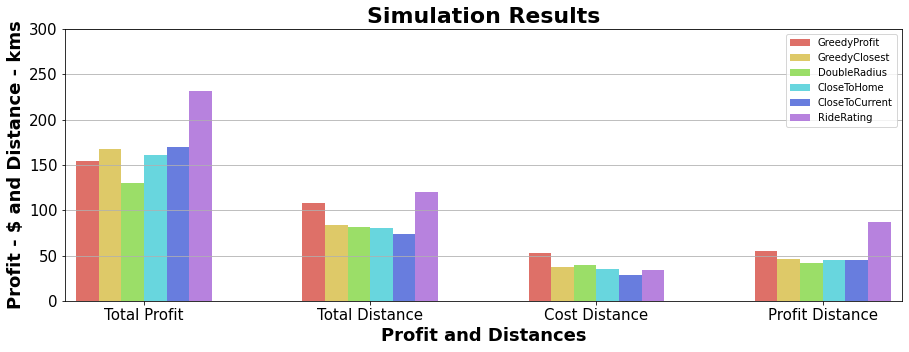

27it [00:00, 265.98it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 12:00:00, and ending at 20:00:00


21013it [00:31, 677.53it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:04 - PickupDistance: 1.18 - DropoffDistance: 9.96 - TotalTime: 33.41 - Profit: 27.4
CurrentProgress: 6.97%
Current Radius: None kms
Ride Info -> StartTime: 12:33:33 - PickupDistance: 9.4 - DropoffDistance: 3.71 - TotalTime: 39.33 - Profit: 11.76
CurrentProgress: 15.18%
Current Radius: None kms
Ride Info -> StartTime: 13:13:02 - PickupDistance: 4.93 - DropoffDistance: 5.86 - TotalTime: 32.35 - Profit: 17.14
CurrentProgress: 21.95%
Current Radius: None kms
Ride Info -> StartTime: 13:45:43 - PickupDistance: 4.89 - DropoffDistance: 5.11 - TotalTime: 30.0 - Profit: 15.27
CurrentProgress: 28.27%
Current Radius: None kms
Ride Info -> StartTime: 14:15:47 - PickupDistance: 11.78 - DropoffDistance: 9.64 - TotalTime: 64.26 - Profit: 26.61
CurrentProgress: 41.67%
Current Radius: None kms
Ride Info -> StartTime: 15:20:11 - PickupDistance: 1.96 - DropoffDistance: 2.45 - TotalTime: 13.22 -

CurrentProgress: 1.67%
Current Radius: 8 kms
Ride Info -> StartTime: 12:08:23 - PickupDistance: 2.16 - DropoffDistance: 0.86 - TotalTime: 9.07 - Profit: 4.66
CurrentProgress: 3.64%
Current Radius: 8 kms
Ride Info -> StartTime: 12:17:33 - PickupDistance: 0.7 - DropoffDistance: 1.2 - TotalTime: 5.72 - Profit: 5.51
CurrentProgress: 4.85%
Current Radius: 8 kms
Ride Info -> StartTime: 12:23:43 - PickupDistance: 1.49 - DropoffDistance: 3.45 - TotalTime: 14.8 - Profit: 11.12
CurrentProgress: 8.02%
Current Radius: 16 kms
Ride Info -> StartTime: 12:38:47 - PickupDistance: 8.39 - DropoffDistance: 6.98 - TotalTime: 46.13 - Profit: 19.96
CurrentProgress: 17.69%
Current Radius: 16 kms
Ride Info -> StartTime: 13:25:03 - PickupDistance: 8.81 - DropoffDistance: 6.63 - TotalTime: 46.34 - Profit: 19.08
CurrentProgress: 27.37%
Current Radius: 16 kms
Ride Info -> StartTime: 14:11:23 - PickupDistance: 4.76 - DropoffDistance: 1.94 - TotalTime: 20.11 - Profit: 7.36
CurrentProgress: 31.56%
Current Radius: 16 

CurrentProgress: 83.19%
Current Radius: 2 kms
Ride Info -> StartTime: 18:39:28 - PickupDistance: 3.42 - DropoffDistance: 3.26 - TotalTime: 20.04 - Profit: 10.65
CurrentProgress: 87.47%
Current Radius: 2 kms
Ride Info -> StartTime: 18:59:55 - PickupDistance: 1.42 - DropoffDistance: 0.64 - TotalTime: 6.18 - Profit: 4.11
CurrentProgress: 88.77%
Current Radius: 2 kms
Ride Info -> StartTime: 19:06:15 - PickupDistance: 0.51 - DropoffDistance: 2.7 - TotalTime: 9.62 - Profit: 9.25
CurrentProgress: 90.81%
Current Radius: 2 kms
Ride Info -> StartTime: 19:16:06 - PickupDistance: 0.69 - DropoffDistance: 2.72 - TotalTime: 10.25 - Profit: 9.31
CurrentProgress: 93.01%
Current Radius: 2 kms
Ride Info -> StartTime: 19:26:36 - PickupDistance: 1.11 - DropoffDistance: 1.42 - TotalTime: 7.6 - Profit: 6.05
CurrentProgress: 94.67%
Current Radius: 2 kms
Ride Info -> StartTime: 19:34:39 - PickupDistance: 1.4 - DropoffDistance: 1.53 - TotalTime: 8.79 - Profit: 6.34
CurrentProgress: 96.69%
Current Radius: 2 kms


CurrentProgress: 92.01%
Current Radius: None kms
Ride Info -> StartTime: 19:21:40 - PickupDistance: 1.04 - DropoffDistance: 0.66 - TotalTime: 5.1 - Profit: 4.15
CurrentProgress: 93.16%
Current Radius: None kms
Ride Info -> StartTime: 19:27:12 - PickupDistance: 1.37 - DropoffDistance: 2.12 - TotalTime: 10.45 - Profit: 7.8
CurrentProgress: 95.46%
Current Radius: None kms
Ride Info -> StartTime: 19:38:16 - PickupDistance: 0.61 - DropoffDistance: 1.62 - TotalTime: 6.68 - Profit: 6.55
CurrentProgress: 96.99%
Current Radius: None kms
Ride Info -> StartTime: 19:45:44 - PickupDistance: 1.4 - DropoffDistance: 1.68 - TotalTime: 9.24 - Profit: 6.7
CurrentProgress: 99.6%
Current Radius: None kms
Ride Info -> StartTime: 19:58:14 - PickupDistance: 1.87 - DropoffDistance: 1.99 - TotalTime: 11.6 - Profit: 7.48

Simulation closeToCurr Results:
Ride Count: 46
Total Profit: 339.49
Total Distance: 148.66
Non-paid Distance: 58.86
Paid Distance: 89.8
Distance from Home: 1.6
Finished Simulation closeToCurr.


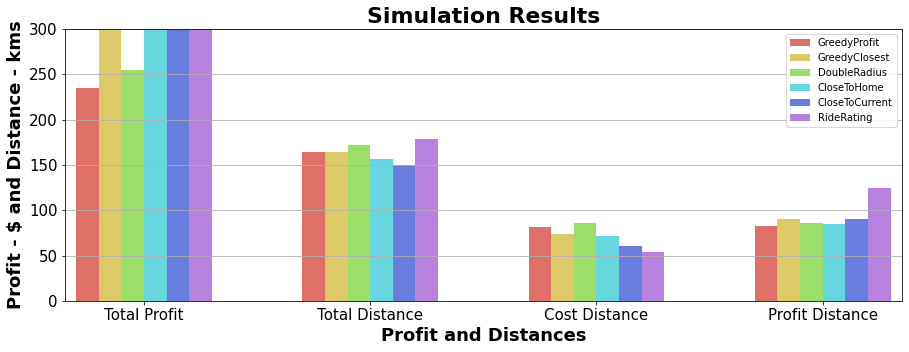

29it [00:00, 287.84it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 16:00:00, and ending at 22:00:00


21013it [00:32, 645.19it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:03 - PickupDistance: 5.39 - DropoffDistance: 5.26 - TotalTime: 31.96 - Profit: 15.66
CurrentProgress: 8.89%
Current Radius: None kms
Ride Info -> StartTime: 16:32:18 - PickupDistance: 1.44 - DropoffDistance: 1.88 - TotalTime: 9.98 - Profit: 7.21
CurrentProgress: 11.74%
Current Radius: None kms
Ride Info -> StartTime: 16:42:16 - PickupDistance: 1.73 - DropoffDistance: 17.09 - TotalTime: 56.47 - Profit: 45.22
CurrentProgress: 27.43%
Current Radius: None kms
Ride Info -> StartTime: 17:38:54 - PickupDistance: 20.9 - DropoffDistance: 2.89 - TotalTime: 71.37 - Profit: 9.72
CurrentProgress: 47.3%
Current Radius: None kms
Ride Info -> StartTime: 18:50:21 - PickupDistance: 6.23 - DropoffDistance: 4.74 - TotalTime: 32.91 - Profit: 14.35
CurrentProgress: 56.46%
Current Radius: None kms
Ride Info -> StartTime: 19:23:29 - PickupDistance: 5.53 - DropoffDistance: 2.54 - TotalTime: 24.23 - 

CurrentProgress: 61.6%
Current Radius: 32 kms
Ride Info -> StartTime: 19:41:48 - PickupDistance: 5.4 - DropoffDistance: 5.52 - TotalTime: 32.76 - Profit: 16.29
CurrentProgress: 70.71%
Current Radius: 32 kms
Ride Info -> StartTime: 20:14:37 - PickupDistance: 4.27 - DropoffDistance: 1.33 - TotalTime: 16.81 - Profit: 5.82
CurrentProgress: 75.39%
Current Radius: 32 kms
Ride Info -> StartTime: 20:31:33 - PickupDistance: 3.36 - DropoffDistance: 5.23 - TotalTime: 25.79 - Profit: 15.58
CurrentProgress: 82.65%
Current Radius: 64 kms
Ride Info -> StartTime: 20:57:39 - PickupDistance: 4.53 - DropoffDistance: 5.09 - TotalTime: 28.87 - Profit: 15.23
CurrentProgress: 90.7%
Current Radius: 64 kms
Ride Info -> StartTime: 21:26:45 - PickupDistance: 2.13 - DropoffDistance: 6.62 - TotalTime: 26.24 - Profit: 19.05
CurrentProgress: 98.05%
Current Radius: 64 kms
Ride Info -> StartTime: 21:53:23 - PickupDistance: 6.12 - DropoffDistance: 2.2 - TotalTime: 24.97 - Profit: 8.01

Simulation doubleRadius Results:


CurrentProgress: 32.36%
Current Radius: None kms
Ride Info -> StartTime: 17:56:38 - PickupDistance: 1.86 - DropoffDistance: 1.3 - TotalTime: 9.48 - Profit: 5.76
CurrentProgress: 35.03%
Current Radius: None kms
Ride Info -> StartTime: 18:06:07 - PickupDistance: 1.57 - DropoffDistance: 1.27 - TotalTime: 8.52 - Profit: 5.68
CurrentProgress: 38.14%
Current Radius: None kms
Ride Info -> StartTime: 18:17:38 - PickupDistance: 1.59 - DropoffDistance: 1.8 - TotalTime: 10.15 - Profit: 6.99
CurrentProgress: 41.17%
Current Radius: None kms
Ride Info -> StartTime: 18:28:12 - PickupDistance: 1.81 - DropoffDistance: 1.72 - TotalTime: 10.61 - Profit: 6.81
CurrentProgress: 44.35%
Current Radius: None kms
Ride Info -> StartTime: 18:39:56 - PickupDistance: 1.64 - DropoffDistance: 2.27 - TotalTime: 11.74 - Profit: 8.18
CurrentProgress: 48.0%
Current Radius: None kms
Ride Info -> StartTime: 18:53:16 - PickupDistance: 1.03 - DropoffDistance: 1.03 - TotalTime: 6.18 - Profit: 5.08
CurrentProgress: 49.96%
Curr

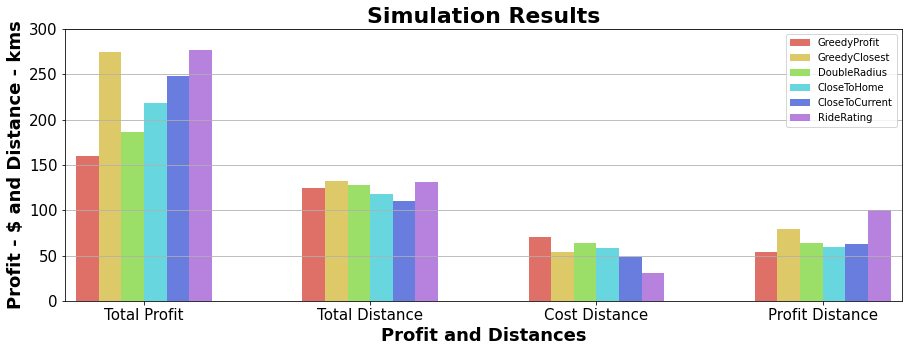

2281it [00:00, 11262.98it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 00:00:00, and ending at 03:00:00


16993it [00:21, 792.24it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:09 - PickupDistance: 2.36 - DropoffDistance: 10.03 - TotalTime: 37.16 - Profit: 27.58
CurrentProgress: 20.72%
Current Radius: None kms
Ride Info -> StartTime: 00:37:25 - PickupDistance: 24.25 - DropoffDistance: 19.35 - TotalTime: 130.81 - Profit: 50.87
CurrentProgress: 93.45%
Current Radius: None kms
Ride Info -> StartTime: 02:48:47 - PickupDistance: 0.49 - DropoffDistance: 15.29 - TotalTime: 47.36 - Profit: 40.74

Simulation greedyProfit Results:
Ride Count: 3
Total Profit: 119.19
Total Distance: 71.78
Non-paid Distance: 27.1
Paid Distance: 44.68
Distance from Home: 14.86
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:08 - PickupDistance: 2.2 - DropoffDistance:

CurrentProgress: 7.1%
Current Radius: None kms
Ride Info -> StartTime: 00:13:04 - PickupDistance: 1.07 - DropoffDistance: 1.33 - TotalTime: 7.21 - Profit: 5.83
CurrentProgress: 11.26%
Current Radius: None kms
Ride Info -> StartTime: 00:20:30 - PickupDistance: 1.8 - DropoffDistance: 2.84 - TotalTime: 13.93 - Profit: 9.6
CurrentProgress: 19.52%
Current Radius: None kms
Ride Info -> StartTime: 00:35:25 - PickupDistance: 0.68 - DropoffDistance: 1.66 - TotalTime: 7.02 - Profit: 6.65
CurrentProgress: 23.86%
Current Radius: None kms
Ride Info -> StartTime: 00:43:03 - PickupDistance: 1.84 - DropoffDistance: 2.22 - TotalTime: 12.17 - Profit: 8.04
CurrentProgress: 32.05%
Current Radius: None kms
Ride Info -> StartTime: 00:57:41 - PickupDistance: 1.13 - DropoffDistance: 1.75 - TotalTime: 8.63 - Profit: 6.87
CurrentProgress: 37.4%
Current Radius: None kms
Ride Info -> StartTime: 01:07:28 - PickupDistance: 1.39 - DropoffDistance: 3.31 - TotalTime: 14.12 - Profit: 10.79
CurrentProgress: 45.88%
Curre

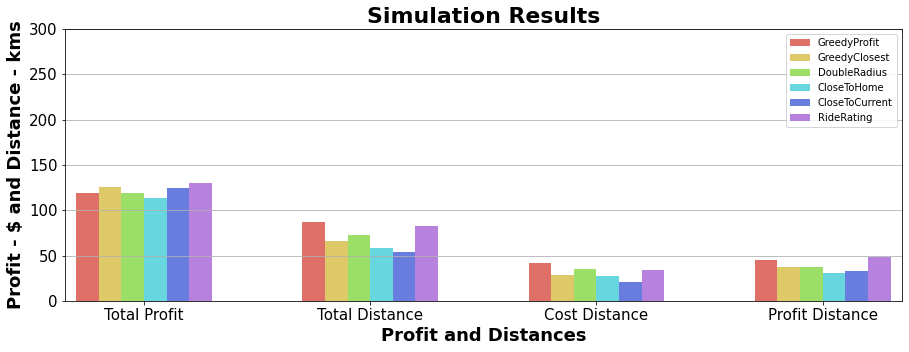

38it [00:00, 370.98it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 08:00:00, and ending at 12:00:00


16993it [00:25, 666.82it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:00 - PickupDistance: 0.79 - DropoffDistance: 10.22 - TotalTime: 33.03 - Profit: 28.05
CurrentProgress: 13.76%
Current Radius: None kms
Ride Info -> StartTime: 08:33:22 - PickupDistance: 11.47 - DropoffDistance: 3.13 - TotalTime: 43.81 - Profit: 10.33
CurrentProgress: 32.15%
Current Radius: None kms
Ride Info -> StartTime: 09:17:18 - PickupDistance: 6.99 - DropoffDistance: 4.44 - TotalTime: 34.29 - Profit: 13.59
CurrentProgress: 46.49%
Current Radius: None kms
Ride Info -> StartTime: 09:51:38 - PickupDistance: 5.59 - DropoffDistance: 7.89 - TotalTime: 40.45 - Profit: 22.24
CurrentProgress: 63.36%
Current Radius: None kms
Ride Info -> StartTime: 10:32:20 - PickupDistance: 3.39 - DropoffDistance: 3.2 - TotalTime: 19.76 - Profit: 10.5
CurrentProgress: 71.7%
Current Radius: None kms
Ride Info -> StartTime: 10:52:13 - PickupDistance: 6.79 - DropoffDistance: 6.33 - TotalTime: 39.37

CurrentProgress: 42.8%
Current Radius: 2.860069444444444 kms
Ride Info -> StartTime: 09:42:43 - PickupDistance: 1.93 - DropoffDistance: 1.4 - TotalTime: 9.98 - Profit: 5.99
CurrentProgress: 47.15%
Current Radius: 2.642708333333333 kms
Ride Info -> StartTime: 09:53:29 - PickupDistance: 0.84 - DropoffDistance: 1.39 - TotalTime: 6.71 - Profit: 5.98
CurrentProgress: 50.08%
Current Radius: 2.4961805555555556 kms
Ride Info -> StartTime: 10:00:16 - PickupDistance: 1.64 - DropoffDistance: 2.28 - TotalTime: 11.77 - Profit: 8.21
CurrentProgress: 55.48%
Current Radius: 2.2260416666666667 kms
Ride Info -> StartTime: 10:13:14 - PickupDistance: 0.26 - DropoffDistance: 2.21 - TotalTime: 7.4 - Profit: 8.02
CurrentProgress: 59.37%
Current Radius: 2.0315972222222225 kms
Ride Info -> StartTime: 10:22:44 - PickupDistance: 0.92 - DropoffDistance: 1.1 - TotalTime: 6.06 - Profit: 5.26
CurrentProgress: 61.99%
Current Radius: 2 kms
Ride Info -> StartTime: 10:28:54 - PickupDistance: 0.64 - DropoffDistance: 1.08

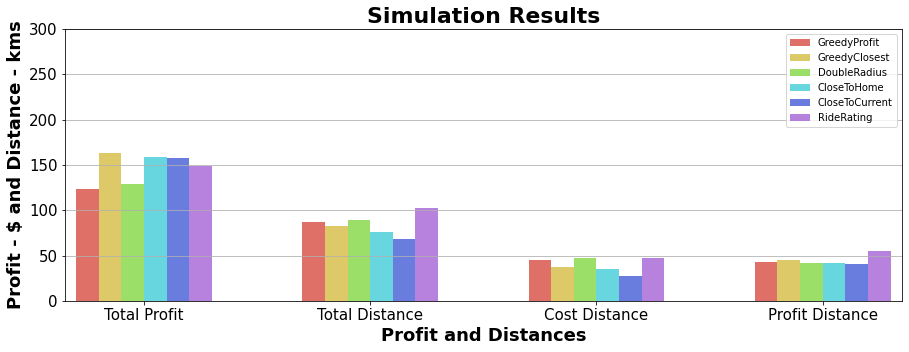

35it [00:00, 347.65it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 12:00:00, and ending at 16:00:00


16993it [00:22, 749.49it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:15 - PickupDistance: 3.52 - DropoffDistance: 2.34 - TotalTime: 17.59 - Profit: 8.35
CurrentProgress: 7.43%
Current Radius: None kms
Ride Info -> StartTime: 12:17:51 - PickupDistance: 0.97 - DropoffDistance: 1.76 - TotalTime: 8.19 - Profit: 6.91
CurrentProgress: 10.85%
Current Radius: None kms
Ride Info -> StartTime: 12:26:19 - PickupDistance: 6.11 - DropoffDistance: 7.14 - TotalTime: 39.76 - Profit: 20.35
CurrentProgress: 27.53%
Current Radius: None kms
Ride Info -> StartTime: 13:06:04 - PickupDistance: 22.54 - DropoffDistance: 9.86 - TotalTime: 97.19 - Profit: 27.15
CurrentProgress: 68.02%
Current Radius: None kms
Ride Info -> StartTime: 14:43:26 - PickupDistance: 13.44 - DropoffDistance: 8.66 - TotalTime: 66.33 - Profit: 24.16
CurrentProgress: 95.73%
Current Radius: None kms
Ride Info -> StartTime: 15:49:53 - PickupDistance: 10.61 - DropoffDistance: 4.21 - TotalTime: 44.47

CurrentProgress: 28.54%
Current Radius: 3.572916666666667 kms
Ride Info -> StartTime: 13:08:55 - PickupDistance: 2.31 - DropoffDistance: 2.71 - TotalTime: 15.06 - Profit: 9.28
CurrentProgress: 34.99%
Current Radius: 3.250694444444444 kms
Ride Info -> StartTime: 13:24:18 - PickupDistance: 1.7 - DropoffDistance: 6.13 - TotalTime: 23.48 - Profit: 17.82
CurrentProgress: 44.9%
Current Radius: 2.754861111111111 kms
Ride Info -> StartTime: 13:48:10 - PickupDistance: 3.11 - DropoffDistance: 2.41 - TotalTime: 16.56 - Profit: 8.52
CurrentProgress: 51.97%
Current Radius: 2.401736111111111 kms
Ride Info -> StartTime: 14:04:56 - PickupDistance: 1.3 - DropoffDistance: 2.61 - TotalTime: 11.73 - Profit: 9.01
CurrentProgress: 57.45%
Current Radius: 2.1274305555555557 kms
Ride Info -> StartTime: 14:17:53 - PickupDistance: 0.31 - DropoffDistance: 2.04 - TotalTime: 7.04 - Profit: 7.61
CurrentProgress: 60.38%
Current Radius: 2 kms
Ride Info -> StartTime: 14:25:03 - PickupDistance: 1.02 - DropoffDistance: 1

CurrentProgress: 94.33%
Current Radius: None kms
Ride Info -> StartTime: 15:46:32 - PickupDistance: 1.38 - DropoffDistance: 11.16 - TotalTime: 37.63 - Profit: 30.4

Simulation rating Results:
Ride Count: 11
Total Profit: 168.05
Total Distance: 86.8
Non-paid Distance: 30.58
Paid Distance: 56.22
Distance from Home: 11.21
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit            99.94         181.96        141.93       153.98   
totalDistance          93.91          81.86         90.72        76.93   
costDistance           59.94          32.08         43.94        33.34   
profitDistance         33.98          49.79         46.77        43.59   

                closeToCurr  rating  
totalProfit          163.73  168.05  
totalDistance         70.34   98.01  
costDistance

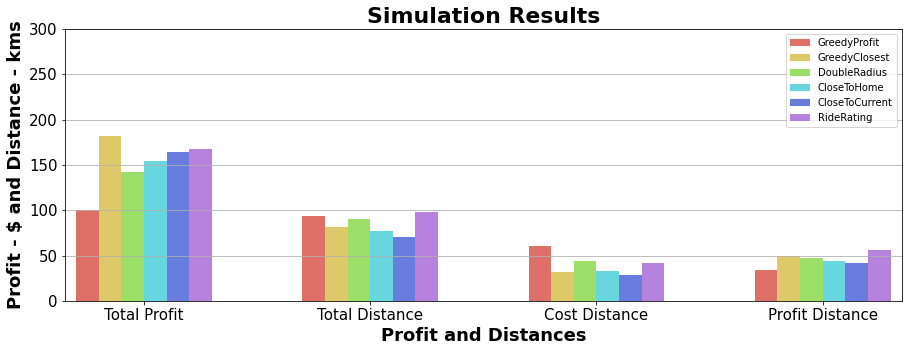

34it [00:00, 335.70it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 12:00:00, and ending at 20:00:00


16993it [00:18, 902.30it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:15 - PickupDistance: 3.66 - DropoffDistance: 2.34 - TotalTime: 17.98 - Profit: 8.35
CurrentProgress: 3.8%
Current Radius: None kms
Ride Info -> StartTime: 12:18:20 - PickupDistance: 3.79 - DropoffDistance: 2.84 - TotalTime: 19.88 - Profit: 9.6
CurrentProgress: 7.96%
Current Radius: None kms
Ride Info -> StartTime: 12:38:20 - PickupDistance: 12.25 - DropoffDistance: 9.08 - TotalTime: 63.99 - Profit: 25.2
CurrentProgress: 21.32%
Current Radius: None kms
Ride Info -> StartTime: 13:42:35 - PickupDistance: 6.08 - DropoffDistance: 3.64 - TotalTime: 29.16 - Profit: 11.6
CurrentProgress: 27.44%
Current Radius: None kms
Ride Info -> StartTime: 14:11:52 - PickupDistance: 11.37 - DropoffDistance: 9.28 - TotalTime: 61.95 - Profit: 25.71
CurrentProgress: 40.38%
Current Radius: None kms
Ride Info -> StartTime: 15:13:57 - PickupDistance: 4.07 - DropoffDistance: 2.84 - TotalTime: 20.71 - Pr

CurrentProgress: 0.12%
Current Radius: 8 kms
Ride Info -> StartTime: 12:00:58 - PickupDistance: 1.52 - DropoffDistance: 2.69 - TotalTime: 12.62 - Profit: 9.23
CurrentProgress: 2.83%
Current Radius: 8 kms
Ride Info -> StartTime: 12:13:45 - PickupDistance: 1.84 - DropoffDistance: 0.79 - TotalTime: 7.91 - Profit: 4.48
CurrentProgress: 4.51%
Current Radius: 8 kms
Ride Info -> StartTime: 12:21:50 - PickupDistance: 5.46 - DropoffDistance: 9.0 - TotalTime: 43.36 - Profit: 25.0
CurrentProgress: 13.63%
Current Radius: 16 kms
Ride Info -> StartTime: 13:05:47 - PickupDistance: 2.04 - DropoffDistance: 9.01 - TotalTime: 33.13 - Profit: 25.02
CurrentProgress: 20.6%
Current Radius: 16 kms
Ride Info -> StartTime: 13:38:56 - PickupDistance: 8.68 - DropoffDistance: 3.48 - TotalTime: 36.5 - Profit: 11.21
CurrentProgress: 28.21%
Current Radius: 16 kms
Ride Info -> StartTime: 14:15:26 - PickupDistance: 6.16 - DropoffDistance: 5.16 - TotalTime: 33.96 - Profit: 15.41
CurrentProgress: 35.29%
Current Radius: 1

CurrentProgress: 84.53%
Current Radius: 2 kms
Ride Info -> StartTime: 18:45:57 - PickupDistance: 1.47 - DropoffDistance: 1.21 - TotalTime: 8.06 - Profit: 5.54
CurrentProgress: 86.39%
Current Radius: 2 kms
Ride Info -> StartTime: 18:54:53 - PickupDistance: 2.71 - DropoffDistance: 2.31 - TotalTime: 15.07 - Profit: 8.28
CurrentProgress: 90.62%
Current Radius: 2 kms
Ride Info -> StartTime: 19:15:04 - PickupDistance: 2.32 - DropoffDistance: 2.46 - TotalTime: 14.33 - Profit: 8.65
CurrentProgress: 93.84%
Current Radius: 2 kms
Ride Info -> StartTime: 19:30:27 - PickupDistance: 0.66 - DropoffDistance: 1.61 - TotalTime: 6.81 - Profit: 6.52
CurrentProgress: 95.26%
Current Radius: 2 kms
Ride Info -> StartTime: 19:37:25 - PickupDistance: 0.48 - DropoffDistance: 2.72 - TotalTime: 9.59 - Profit: 9.29
CurrentProgress: 97.29%
Current Radius: 2 kms
Ride Info -> StartTime: 19:47:06 - PickupDistance: 2.64 - DropoffDistance: 2.26 - TotalTime: 14.72 - Profit: 8.16

Simulation closeToHome Results:
Ride Count

CurrentProgress: 98.9%
Current Radius: None kms
Ride Info -> StartTime: 19:54:56 - PickupDistance: 1.61 - DropoffDistance: 1.42 - TotalTime: 9.1 - Profit: 6.05

Simulation closeToCurr Results:
Ride Count: 44
Total Profit: 298.3
Total Distance: 131.34
Non-paid Distance: 56.02
Paid Distance: 75.32
Distance from Home: 1.23
Finished Simulation closeToCurr.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation rating ->
CurrentProgress: 0.07%
Current Radius: None kms
Ride Info -> StartTime: 12:00:30 - PickupDistance: 9.14 - DropoffDistance: 11.7 - TotalTime: 62.52 - Profit: 31.75
CurrentProgress: 13.17%
Current Radius: None kms
Ride Info -> StartTime: 13:03:20 - PickupDistance: 1.22 - DropoffDistance: 3.61 - TotalTime: 14.5 - Profit: 11.53
CurrentProgress: 16.44%
Current Radius: None kms
Ride Info -> StartTime: 13:19:11 - PickupDistance: 6.87 - DropoffDistance: 11.92 - TotalTime: 56.37 - Profit: 32.31
CurrentP

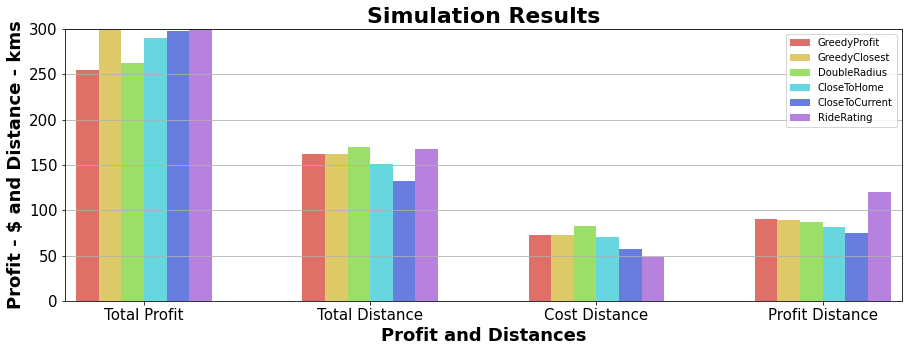

35it [00:00, 345.46it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 16:00:00, and ending at 22:00:00


16993it [00:20, 814.69it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:24 - PickupDistance: 4.07 - DropoffDistance: 3.98 - TotalTime: 24.14 - Profit: 12.44
CurrentProgress: 6.81%
Current Radius: None kms
Ride Info -> StartTime: 16:25:01 - PickupDistance: 1.03 - DropoffDistance: 10.21 - TotalTime: 33.72 - Profit: 28.02
CurrentProgress: 16.31%
Current Radius: None kms
Ride Info -> StartTime: 16:58:46 - PickupDistance: 10.45 - DropoffDistance: 2.98 - TotalTime: 40.29 - Profit: 9.96
CurrentProgress: 27.51%
Current Radius: None kms
Ride Info -> StartTime: 17:39:12 - PickupDistance: 8.34 - DropoffDistance: 16.48 - TotalTime: 74.49 - Profit: 43.71
CurrentProgress: 48.25%
Current Radius: None kms
Ride Info -> StartTime: 18:53:58 - PickupDistance: 22.29 - DropoffDistance: 8.83 - TotalTime: 93.37 - Profit: 24.58
CurrentProgress: 74.25%
Current Radius: None kms
Ride Info -> StartTime: 20:27:37 - PickupDistance: 15.1 - DropoffDistance: 13.86 - TotalTime: 8

CurrentProgress: 76.81%
Current Radius: 32 kms
Ride Info -> StartTime: 20:36:38 - PickupDistance: 2.69 - DropoffDistance: 2.14 - TotalTime: 14.49 - Profit: 7.84
CurrentProgress: 80.87%
Current Radius: 32 kms
Ride Info -> StartTime: 20:51:27 - PickupDistance: 8.65 - DropoffDistance: 19.52 - TotalTime: 84.51 - Profit: 51.29

Simulation doubleRadius Results:
Ride Count: 15
Total Profit: 210.7
Total Distance: 123.98
Non-paid Distance: 54.7
Paid Distance: 69.28
Distance from Home: 13.69
Finished Simulation doubleRadius.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation closeToHome ->
CurrentProgress: 0.12%
Current Radius: 4.994212962962963 kms
Ride Info -> StartTime: 16:00:59 - PickupDistance: 0.81 - DropoffDistance: 1.33 - TotalTime: 6.44 - Profit: 5.84
CurrentProgress: 2.06%
Current Radius: 4.8969907407407405 kms
Ride Info -> StartTime: 16:07:26 - PickupDistance: 1.92 - DropoffDistance: 4.85 - TotalTime:

CurrentProgress: 55.32%
Current Radius: None kms
Ride Info -> StartTime: 19:19:18 - PickupDistance: 1.66 - DropoffDistance: 3.94 - TotalTime: 16.79 - Profit: 12.35
CurrentProgress: 60.12%
Current Radius: None kms
Ride Info -> StartTime: 19:36:26 - PickupDistance: 1.63 - DropoffDistance: 4.46 - TotalTime: 18.27 - Profit: 13.66
CurrentProgress: 65.19%
Current Radius: None kms
Ride Info -> StartTime: 19:54:56 - PickupDistance: 1.61 - DropoffDistance: 1.42 - TotalTime: 9.1 - Profit: 6.05
CurrentProgress: 69.36%
Current Radius: None kms
Ride Info -> StartTime: 20:10:07 - PickupDistance: 1.25 - DropoffDistance: 1.85 - TotalTime: 9.31 - Profit: 7.13
CurrentProgress: 72.18%
Current Radius: None kms
Ride Info -> StartTime: 20:20:15 - PickupDistance: 0.48 - DropoffDistance: 2.0 - TotalTime: 7.44 - Profit: 7.49
CurrentProgress: 75.61%
Current Radius: None kms
Ride Info -> StartTime: 20:32:37 - PickupDistance: 1.25 - DropoffDistance: 2.13 - TotalTime: 10.14 - Profit: 7.83
CurrentProgress: 79.62%
C

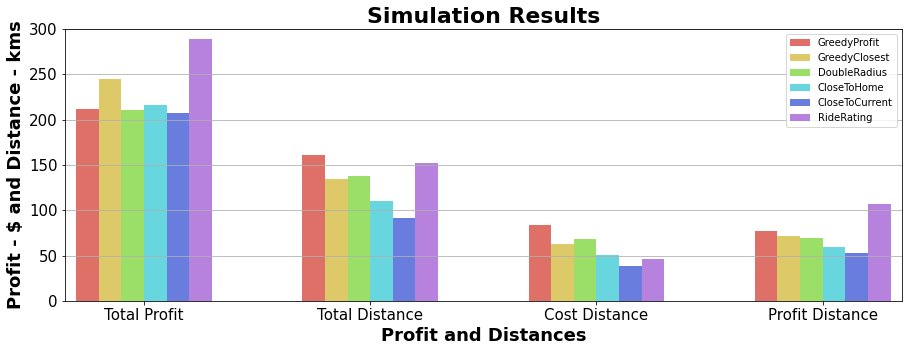

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------


End of All Simulations
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Averaged Results
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit         161.2990       202.1945      169.0570     188.0620   
totalDistance       117.2305       104.4230      110.3245      94.9645   
costDistance         60.1120        46.0940       55.1520      43.4900   
profitDistance       57.1200        58.3285       55.1730      51.4750   

                

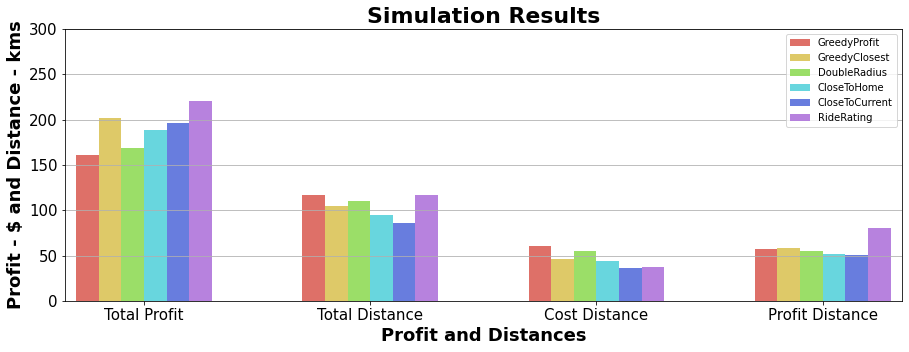

In [632]:
# average comparison example
# this function call can take a while as there are many simulations running. This example takes ~30 mins and performs 120 total simulations (20 days/times * 6 algs)
averageComparison([df_monday, df_wednesday, df_friday, df_sunday], ['2015-06-22', '2015-06-24', '2015-06-26', '2015-06-28'], ['00:00:00 03:00:00', '08:00:00 12:00:00', '12:00:00 16:00:00', '12:00:00 20:00:00', '16:00:00 22:00:00'],  3, 5, 2, 5, 0.1)

901it [00:00, 8889.46it/s]

Simulating on 2015-06-22, starting at 00:00:00, and ending at 03:00:00


18365it [00:27, 667.67it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:04 - PickupDistance: 8.25 - DropoffDistance: 13.85 - TotalTime: 66.3 - Profit: 37.12
CurrentProgress: 36.86%
Current Radius: None kms
Ride Info -> StartTime: 01:06:55 - PickupDistance: 21.14 - DropoffDistance: 21.08 - TotalTime: 126.68 - Profit: 55.21

Simulation greedyProfit Results:
Ride Count: 2
Total Profit: 92.33
Total Distance: 64.33
Non-paid Distance: 29.39
Paid Distance: 34.93
Distance from Home: 3.1
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:08 - PickupDistance: 2.28 - DropoffDistance: 4.23 - TotalTime: 19.52 - Profit: 13.06
CurrentProgress: 10.92%
Current Radius: None kms
Ride Info -> StartTime: 00:21:03 - PickupDistance: 1.67 - DropoffDistance: 1.

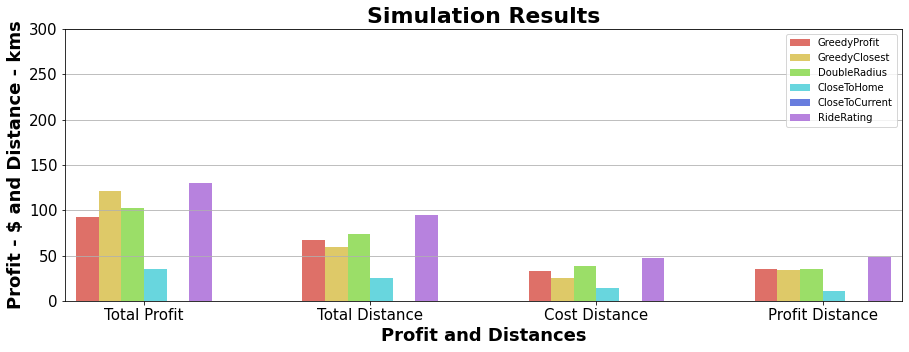

40it [00:00, 398.47it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 08:00:00, and ending at 12:00:00


18365it [00:24, 738.05it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:04 - PickupDistance: 20.16 - DropoffDistance: 21.65 - TotalTime: 125.43 - Profit: 56.62
CurrentProgress: 52.29%
Current Radius: None kms
Ride Info -> StartTime: 10:06:20 - PickupDistance: 0.96 - DropoffDistance: 34.25 - TotalTime: 105.62 - Profit: 88.12
CurrentProgress: 96.64%
Current Radius: None kms
Ride Info -> StartTime: 11:52:29 - PickupDistance: 33.66 - DropoffDistance: 21.35 - TotalTime: 165.02 - Profit: 55.87

Simulation greedyProfit Results:
Ride Count: 3
Total Profit: 200.62
Total Distance: 132.02
Non-paid Distance: 54.78
Paid Distance: 77.25
Distance from Home: 20.01
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:54 - PickupDistance: 1.65 - DropoffDis

CurrentProgress: 31.41%
Current Radius: 3.4295138888888888 kms
Ride Info -> StartTime: 09:15:59 - PickupDistance: 1.3 - DropoffDistance: 1.2 - TotalTime: 7.52 - Profit: 5.5
CurrentProgress: 34.78%
Current Radius: 3.260763888888889 kms
Ride Info -> StartTime: 09:23:50 - PickupDistance: 2.11 - DropoffDistance: 1.05 - TotalTime: 9.46 - Profit: 5.12
CurrentProgress: 39.02%
Current Radius: 3.0489583333333337 kms
Ride Info -> StartTime: 09:34:17 - PickupDistance: 0.92 - DropoffDistance: 1.31 - TotalTime: 6.67 - Profit: 5.77
CurrentProgress: 42.06%
Current Radius: 2.8968749999999996 kms
Ride Info -> StartTime: 09:41:41 - PickupDistance: 1.65 - DropoffDistance: 1.75 - TotalTime: 10.2 - Profit: 6.87
CurrentProgress: 46.62%
Current Radius: 2.669097222222222 kms
Ride Info -> StartTime: 09:52:58 - PickupDistance: 1.33 - DropoffDistance: 2.11 - TotalTime: 10.32 - Profit: 7.77
CurrentProgress: 51.37%
Current Radius: 2.431597222222222 kms
Ride Info -> StartTime: 10:03:55 - PickupDistance: 2.24 - Drop

CurrentProgress: 27.95%
Current Radius: None kms
Ride Info -> StartTime: 09:07:33 - PickupDistance: 0.17 - DropoffDistance: 8.89 - TotalTime: 27.19 - Profit: 24.73
CurrentProgress: 39.47%
Current Radius: None kms
Ride Info -> StartTime: 09:35:01 - PickupDistance: 6.79 - DropoffDistance: 14.55 - TotalTime: 64.01 - Profit: 38.88
CurrentProgress: 67.15%
Current Radius: None kms
Ride Info -> StartTime: 10:41:20 - PickupDistance: 13.07 - DropoffDistance: 19.26 - TotalTime: 96.97 - Profit: 50.64

Simulation rating Results:
Ride Count: 5
Total Profit: 158.04
Total Distance: 84.59
Non-paid Distance: 26.37
Paid Distance: 58.22
Distance from Home: 20.38
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           200.62         185.05        147.48       150.01   
totalDistance     

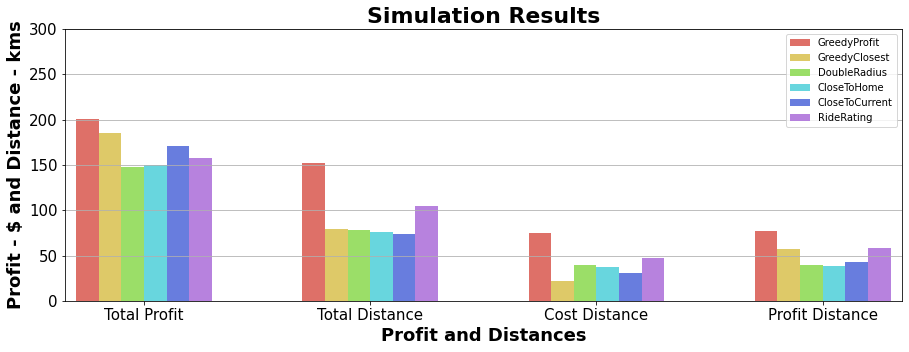

39it [00:00, 381.01it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 12:00:00, and ending at 16:00:00


18365it [00:23, 769.25it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:34 - PickupDistance: 6.33 - DropoffDistance: 4.99 - TotalTime: 33.95 - Profit: 14.97
CurrentProgress: 14.38%
Current Radius: None kms
Ride Info -> StartTime: 12:35:03 - PickupDistance: 3.05 - DropoffDistance: 10.1 - TotalTime: 39.45 - Profit: 27.74
CurrentProgress: 31.04%
Current Radius: None kms
Ride Info -> StartTime: 13:15:10 - PickupDistance: 12.64 - DropoffDistance: 12.08 - TotalTime: 74.18 - Profit: 32.7
CurrentProgress: 62.22%
Current Radius: None kms
Ride Info -> StartTime: 14:29:34 - PickupDistance: 7.65 - DropoffDistance: 8.36 - TotalTime: 48.01 - Profit: 23.39
CurrentProgress: 82.32%
Current Radius: None kms
Ride Info -> StartTime: 15:17:53 - PickupDistance: 20.73 - DropoffDistance: 22.41 - TotalTime: 129.4 - Profit: 58.52

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 157.33
Total Distance: 108.33
Non-paid Distance: 50.4
Paid Distance: 57.93
Distan

CurrentProgress: 0.0%
Current Radius: 5.0 kms
Ride Info -> StartTime: 12:00:17 - PickupDistance: 1.25 - DropoffDistance: 2.05 - TotalTime: 9.9 - Profit: 7.62
CurrentProgress: 4.24%
Current Radius: 4.787847222222222 kms
Ride Info -> StartTime: 12:11:02 - PickupDistance: 1.44 - DropoffDistance: 2.05 - TotalTime: 10.47 - Profit: 7.61
CurrentProgress: 8.96%
Current Radius: 4.552083333333333 kms
Ride Info -> StartTime: 12:21:45 - PickupDistance: 1.79 - DropoffDistance: 1.86 - TotalTime: 10.95 - Profit: 7.16
CurrentProgress: 13.62%
Current Radius: 4.319097222222222 kms
Ride Info -> StartTime: 12:32:44 - PickupDistance: 1.28 - DropoffDistance: 2.42 - TotalTime: 11.12 - Profit: 8.56
CurrentProgress: 18.27%
Current Radius: 4.086458333333333 kms
Ride Info -> StartTime: 12:43:54 - PickupDistance: 2.31 - DropoffDistance: 2.33 - TotalTime: 13.92 - Profit: 8.34
CurrentProgress: 24.09%
Current Radius: 3.795486111111111 kms
Ride Info -> StartTime: 12:58:04 - PickupDistance: 3.2 - DropoffDistance: 3.13

CurrentProgress: 27.86%
Current Radius: None kms
Ride Info -> StartTime: 13:07:27 - PickupDistance: 1.07 - DropoffDistance: 5.52 - TotalTime: 19.78 - Profit: 16.31
CurrentProgress: 36.34%
Current Radius: None kms
Ride Info -> StartTime: 13:27:16 - PickupDistance: 5.4 - DropoffDistance: 10.32 - TotalTime: 47.15 - Profit: 28.29
CurrentProgress: 56.0%
Current Radius: None kms
Ride Info -> StartTime: 14:14:37 - PickupDistance: 16.22 - DropoffDistance: 20.34 - TotalTime: 109.66 - Profit: 53.34

Simulation rating Results:
Ride Count: 8
Total Profit: 150.22
Total Distance: 80.66
Non-paid Distance: 28.57
Paid Distance: 52.09
Distance from Home: 1.51
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           157.33         179.25        132.56       149.83   
totalDistance       

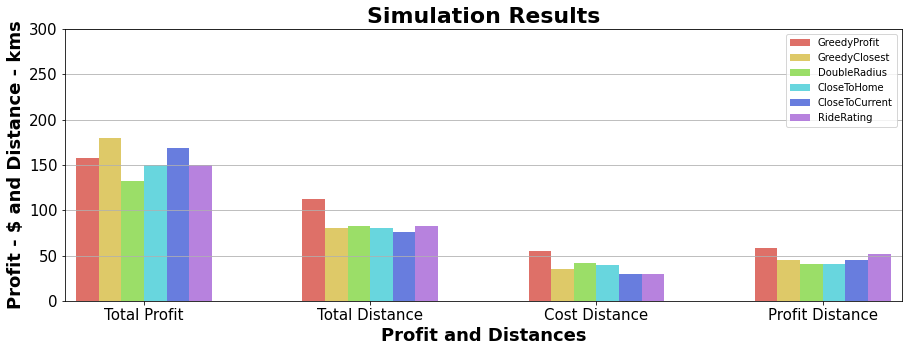

40it [00:00, 395.61it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 12:00:00, and ending at 20:00:00


18365it [00:20, 915.27it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:34 - PickupDistance: 6.31 - DropoffDistance: 4.99 - TotalTime: 33.89 - Profit: 14.97
CurrentProgress: 7.18%
Current Radius: None kms
Ride Info -> StartTime: 12:35:03 - PickupDistance: 3.05 - DropoffDistance: 10.1 - TotalTime: 39.45 - Profit: 27.74
CurrentProgress: 15.52%
Current Radius: None kms
Ride Info -> StartTime: 13:15:10 - PickupDistance: 12.64 - DropoffDistance: 12.08 - TotalTime: 74.18 - Profit: 32.7
CurrentProgress: 31.11%
Current Radius: None kms
Ride Info -> StartTime: 14:29:34 - PickupDistance: 7.65 - DropoffDistance: 8.36 - TotalTime: 48.01 - Profit: 23.39
CurrentProgress: 41.16%
Current Radius: None kms
Ride Info -> StartTime: 15:17:53 - PickupDistance: 20.73 - DropoffDistance: 22.41 - TotalTime: 129.4 - Profit: 58.52
CurrentProgress: 68.18%
Current Radius: None kms
Ride Info -> StartTime: 17:27:42 - PickupDistance: 5.86 - DropoffDistance: 4.28 - TotalTime: 30

CurrentProgress: 42.46%
Current Radius: 8 kms
Ride Info -> StartTime: 15:24:02 - PickupDistance: 3.54 - DropoffDistance: 4.93 - TotalTime: 25.39 - Profit: 14.82
CurrentProgress: 47.8%
Current Radius: 8 kms
Ride Info -> StartTime: 15:49:57 - PickupDistance: 8.73 - DropoffDistance: 6.03 - TotalTime: 44.28 - Profit: 17.57
CurrentProgress: 57.13%
Current Radius: 8 kms
Ride Info -> StartTime: 16:34:52 - PickupDistance: 2.19 - DropoffDistance: 2.16 - TotalTime: 13.08 - Profit: 7.91
CurrentProgress: 59.99%
Current Radius: 8 kms
Ride Info -> StartTime: 16:48:10 - PickupDistance: 0.6 - DropoffDistance: 9.72 - TotalTime: 30.97 - Profit: 26.81
CurrentProgress: 66.49%
Current Radius: 8 kms
Ride Info -> StartTime: 17:19:27 - PickupDistance: 5.47 - DropoffDistance: 4.37 - TotalTime: 29.53 - Profit: 13.42
CurrentProgress: 72.7%
Current Radius: 8 kms
Ride Info -> StartTime: 17:49:23 - PickupDistance: 5.48 - DropoffDistance: 3.88 - TotalTime: 28.08 - Profit: 12.19
CurrentProgress: 78.64%
Current Radius


Simulation closeToHome Results:
Ride Count: 36
Total Profit: 284.43
Total Distance: 152.28
Non-paid Distance: 74.51
Paid Distance: 77.77
Distance from Home: 1.39
Finished Simulation closeToHome.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation closeToCurr ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:17 - PickupDistance: 1.25 - DropoffDistance: 2.05 - TotalTime: 9.9 - Profit: 7.62
CurrentProgress: 2.12%
Current Radius: None kms
Ride Info -> StartTime: 12:11:02 - PickupDistance: 1.44 - DropoffDistance: 2.05 - TotalTime: 10.47 - Profit: 7.61
CurrentProgress: 4.76%
Current Radius: None kms
Ride Info -> StartTime: 12:23:30 - PickupDistance: 1.34 - DropoffDistance: 1.17 - TotalTime: 7.55 - Profit: 5.44
CurrentProgress: 6.92%
Current Radius: None kms
Ride Info -> StartTime: 12:33:29 - PickupDistance: 1.89 - DropoffDistance: 1.85 - TotalTime: 11.21 - Profit: 7.11
CurrentPr

CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:17 - PickupDistance: 1.25 - DropoffDistance: 2.05 - TotalTime: 9.9 - Profit: 7.62
CurrentProgress: 2.12%
Current Radius: None kms
Ride Info -> StartTime: 12:10:43 - PickupDistance: 0.92 - DropoffDistance: 2.69 - TotalTime: 10.84 - Profit: 9.23
CurrentProgress: 4.49%
Current Radius: None kms
Ride Info -> StartTime: 12:21:54 - PickupDistance: 1.05 - DropoffDistance: 2.41 - TotalTime: 10.4 - Profit: 8.53
CurrentProgress: 6.73%
Current Radius: None kms
Ride Info -> StartTime: 12:32:32 - PickupDistance: 1.67 - DropoffDistance: 4.77 - TotalTime: 19.31 - Profit: 14.43
CurrentProgress: 10.8%
Current Radius: None kms
Ride Info -> StartTime: 12:51:56 - PickupDistance: 0.99 - DropoffDistance: 3.99 - TotalTime: 14.93 - Profit: 12.47
CurrentProgress: 13.93%
Current Radius: None kms
Ride Info -> StartTime: 13:07:27 - PickupDistance: 1.07 - DropoffDistance: 5.52 - TotalTime: 19.78 - Profit: 16.31
CurrentProgress: 18.17%
Curr

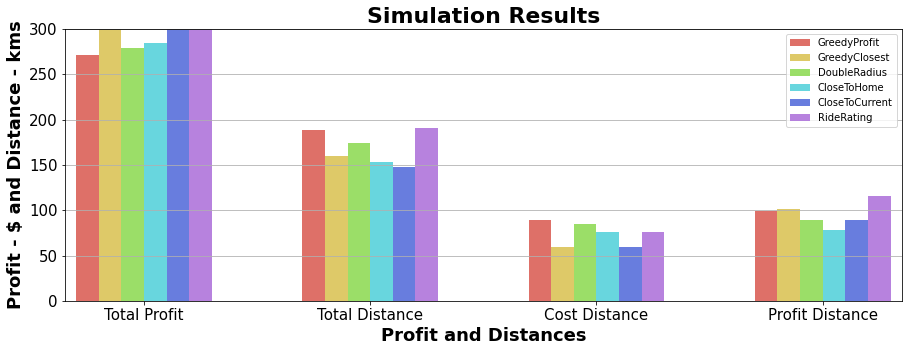

68it [00:00, 338.41it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-22, starting at 16:00:00, and ending at 22:00:00


18365it [00:19, 936.46it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:45 - PickupDistance: 0.18 - DropoffDistance: 18.26 - TotalTime: 55.32 - Profit: 48.14
CurrentProgress: 15.57%
Current Radius: None kms
Ride Info -> StartTime: 16:56:21 - PickupDistance: 17.84 - DropoffDistance: 7.2 - TotalTime: 75.12 - Profit: 20.5
CurrentProgress: 36.52%
Current Radius: None kms
Ride Info -> StartTime: 18:11:55 - PickupDistance: 15.69 - DropoffDistance: 20.13 - TotalTime: 107.45 - Profit: 52.82
CurrentProgress: 66.49%
Current Radius: None kms
Ride Info -> StartTime: 19:59:38 - PickupDistance: 0.97 - DropoffDistance: 4.14 - TotalTime: 15.33 - Profit: 12.86
CurrentProgress: 70.82%
Current Radius: None kms
Ride Info -> StartTime: 20:15:01 - PickupDistance: 2.14 - DropoffDistance: 5.76 - TotalTime: 23.69 - Profit: 16.91
CurrentProgress: 77.42%
Current Radius: None kms
Ride Info -> StartTime: 20:38:49 - PickupDistance: 4.36 - DropoffDistance: 6.47 - TotalTime: 3

CurrentProgress: 43.31%
Current Radius: 8 kms
Ride Info -> StartTime: 18:36:21 - PickupDistance: 2.08 - DropoffDistance: 1.57 - TotalTime: 10.95 - Profit: 6.41
CurrentProgress: 46.47%
Current Radius: 8 kms
Ride Info -> StartTime: 18:47:51 - PickupDistance: 1.71 - DropoffDistance: 2.01 - TotalTime: 11.15 - Profit: 7.52
CurrentProgress: 49.72%
Current Radius: 8 kms
Ride Info -> StartTime: 18:59:35 - PickupDistance: 2.09 - DropoffDistance: 2.75 - TotalTime: 14.51 - Profit: 9.36
CurrentProgress: 53.91%
Current Radius: 8 kms
Ride Info -> StartTime: 19:14:24 - PickupDistance: 2.26 - DropoffDistance: 2.22 - TotalTime: 13.43 - Profit: 8.04
CurrentProgress: 57.73%
Current Radius: 8 kms
Ride Info -> StartTime: 19:27:55 - PickupDistance: 2.86 - DropoffDistance: 1.81 - TotalTime: 14.01 - Profit: 7.02
CurrentProgress: 61.64%
Current Radius: 8 kms
Ride Info -> StartTime: 19:42:26 - PickupDistance: 1.31 - DropoffDistance: 1.89 - TotalTime: 9.58 - Profit: 7.22
CurrentProgress: 64.44%
Current Radius: 8

CurrentProgress: 18.55%
Current Radius: None kms
Ride Info -> StartTime: 17:07:14 - PickupDistance: 1.84 - DropoffDistance: 1.04 - TotalTime: 8.64 - Profit: 5.1
CurrentProgress: 21.07%
Current Radius: None kms
Ride Info -> StartTime: 17:15:53 - PickupDistance: 1.13 - DropoffDistance: 1.61 - TotalTime: 8.23 - Profit: 6.53
CurrentProgress: 23.36%
Current Radius: None kms
Ride Info -> StartTime: 17:24:58 - PickupDistance: 0.93 - DropoffDistance: 1.52 - TotalTime: 7.37 - Profit: 6.31
CurrentProgress: 25.65%
Current Radius: None kms
Ride Info -> StartTime: 17:33:24 - PickupDistance: 0.99 - DropoffDistance: 1.13 - TotalTime: 6.36 - Profit: 5.31
CurrentProgress: 27.85%
Current Radius: None kms
Ride Info -> StartTime: 17:40:36 - PickupDistance: 0.38 - DropoffDistance: 2.23 - TotalTime: 7.85 - Profit: 8.08
CurrentProgress: 30.32%
Current Radius: None kms
Ride Info -> StartTime: 17:49:31 - PickupDistance: 1.96 - DropoffDistance: 2.2 - TotalTime: 12.48 - Profit: 7.99
CurrentProgress: 33.88%
Curre

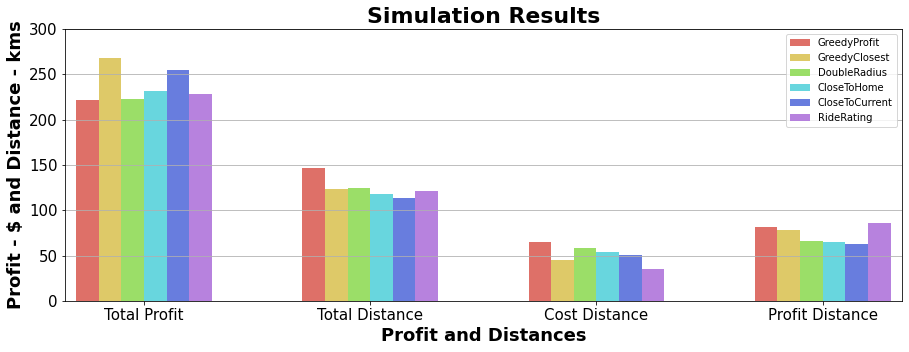

1198it [00:00, 11746.33it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 00:00:00, and ending at 03:00:00


19885it [00:26, 743.11it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:04 - PickupDistance: 1.69 - DropoffDistance: 9.72 - TotalTime: 34.25 - Profit: 26.81
CurrentProgress: 19.06%
Current Radius: None kms
Ride Info -> StartTime: 00:34:46 - PickupDistance: 10.56 - DropoffDistance: 10.18 - TotalTime: 62.23 - Profit: 27.95
CurrentProgress: 53.89%
Current Radius: None kms
Ride Info -> StartTime: 01:38:04 - PickupDistance: 26.2 - DropoffDistance: 21.17 - TotalTime: 142.11 - Profit: 55.43

Simulation greedyProfit Results:
Ride Count: 3
Total Profit: 110.18
Total Distance: 79.53
Non-paid Distance: 38.46
Paid Distance: 41.07
Distance from Home: 1.97
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:52 - PickupDistance: 1.41 - DropoffDistance:

CurrentProgress: 19.54%
Current Radius: None kms
Ride Info -> StartTime: 00:35:19 - PickupDistance: 10.49 - DropoffDistance: 20.03 - TotalTime: 91.55 - Profit: 52.57
CurrentProgress: 70.47%
Current Radius: None kms
Ride Info -> StartTime: 02:07:15 - PickupDistance: 0.13 - DropoffDistance: 5.89 - TotalTime: 18.06 - Profit: 17.22
CurrentProgress: 80.72%
Current Radius: None kms
Ride Info -> StartTime: 02:26:35 - PickupDistance: 1.96 - DropoffDistance: 10.25 - TotalTime: 36.63 - Profit: 28.12

Simulation rating Results:
Ride Count: 4
Total Profit: 124.72
Total Distance: 60.16
Non-paid Distance: 14.28
Paid Distance: 45.89
Distance from Home: 9.05
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           110.18         130.04        129.27        96.10   
totalDistance      

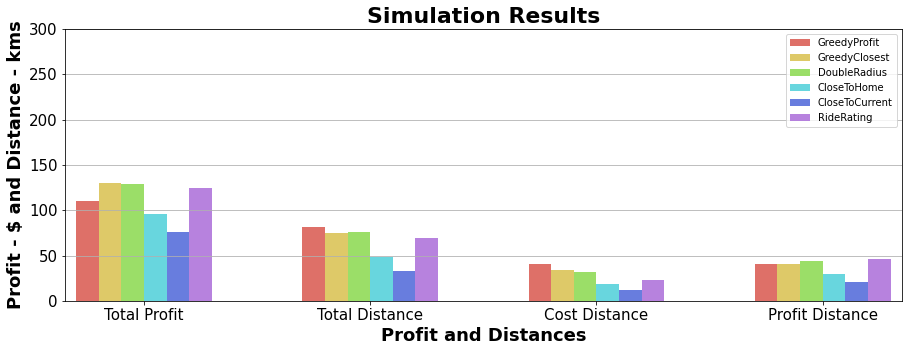

71it [00:00, 343.90it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 08:00:00, and ending at 12:00:00


19885it [00:24, 810.63it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:08 - PickupDistance: 2.87 - DropoffDistance: 22.12 - TotalTime: 74.97 - Profit: 57.8
CurrentProgress: 31.29%
Current Radius: None kms
Ride Info -> StartTime: 09:15:19 - PickupDistance: 22.24 - DropoffDistance: 4.43 - TotalTime: 80.02 - Profit: 13.58
CurrentProgress: 64.72%
Current Radius: None kms
Ride Info -> StartTime: 10:35:31 - PickupDistance: 4.32 - DropoffDistance: 22.66 - TotalTime: 80.92 - Profit: 59.15
CurrentProgress: 98.51%
Current Radius: None kms
Ride Info -> StartTime: 11:56:33 - PickupDistance: 0.05 - DropoffDistance: 15.55 - TotalTime: 46.8 - Profit: 41.38

Simulation greedyProfit Results:
Ride Count: 4
Total Profit: 171.91
Total Distance: 94.24
Non-paid Distance: 29.47
Paid Distance: 64.76
Distance from Home: 17.13
Finished Simulation greedyProfit.

--------------------------------------------------------------------------------------------------------------

CurrentProgress: 0.0%
Current Radius: 5.0 kms
Ride Info -> StartTime: 08:00:36 - PickupDistance: 0.33 - DropoffDistance: 1.8 - TotalTime: 6.4 - Profit: 7.01
CurrentProgress: 2.92%
Current Radius: 4.854166666666667 kms
Ride Info -> StartTime: 08:07:20 - PickupDistance: 1.63 - DropoffDistance: 0.92 - TotalTime: 7.64 - Profit: 4.8
CurrentProgress: 6.24%
Current Radius: 4.688194444444445 kms
Ride Info -> StartTime: 08:15:24 - PickupDistance: 0.96 - DropoffDistance: 1.31 - TotalTime: 6.81 - Profit: 5.78
CurrentProgress: 9.25%
Current Radius: 4.5375 kms
Ride Info -> StartTime: 08:22:31 - PickupDistance: 0.93 - DropoffDistance: 3.28 - TotalTime: 12.62 - Profit: 10.71
CurrentProgress: 14.64%
Current Radius: 4.268055555555556 kms
Ride Info -> StartTime: 08:35:23 - PickupDistance: 2.72 - DropoffDistance: 1.11 - TotalTime: 11.48 - Profit: 5.27
CurrentProgress: 19.67%
Current Radius: 4.016319444444444 kms
Ride Info -> StartTime: 08:47:48 - PickupDistance: 1.81 - DropoffDistance: 2.2 - TotalTime: 1

CurrentProgress: 86.54%
Current Radius: None kms
Ride Info -> StartTime: 11:27:44 - PickupDistance: 1.35 - DropoffDistance: 2.19 - TotalTime: 10.63 - Profit: 7.98
CurrentProgress: 91.92%
Current Radius: None kms
Ride Info -> StartTime: 11:40:51 - PickupDistance: 1.04 - DropoffDistance: 2.76 - TotalTime: 11.4 - Profit: 9.39
CurrentProgress: 96.76%
Current Radius: None kms
Ride Info -> StartTime: 11:52:42 - PickupDistance: 0.86 - DropoffDistance: 2.21 - TotalTime: 9.19 - Profit: 8.02

Simulation closeToCurr Results:
Ride Count: 28
Total Profit: 183.08
Total Distance: 75.28
Non-paid Distance: 30.05
Paid Distance: 45.23
Distance from Home: 1.57
Finished Simulation closeToCurr.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation rating ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:08 - PickupDistance: 2.87 - DropoffDistance: 22.12 - TotalTime: 74.97 - Profit: 57.8
CurrentPro

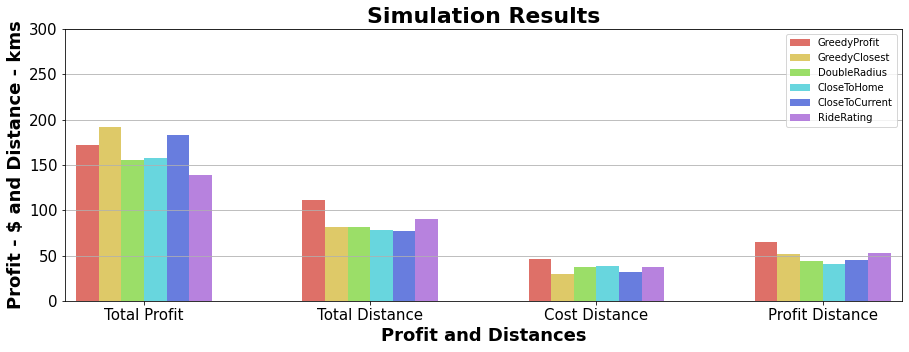

74it [00:00, 361.18it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 12:00:00, and ending at 16:00:00


19885it [00:24, 797.36it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:13 - PickupDistance: 3.98 - DropoffDistance: 2.92 - TotalTime: 20.69 - Profit: 9.8
CurrentProgress: 8.71%
Current Radius: None kms
Ride Info -> StartTime: 12:21:05 - PickupDistance: 1.55 - DropoffDistance: 7.58 - TotalTime: 27.41 - Profit: 21.45
CurrentProgress: 20.2%
Current Radius: None kms
Ride Info -> StartTime: 12:48:47 - PickupDistance: 13.81 - DropoffDistance: 21.8 - TotalTime: 106.84 - Profit: 57.0
CurrentProgress: 64.84%
Current Radius: None kms
Ride Info -> StartTime: 14:35:39 - PickupDistance: 4.72 - DropoffDistance: 21.5 - TotalTime: 78.65 - Profit: 56.25
CurrentProgress: 97.62%
Current Radius: None kms
Ride Info -> StartTime: 15:54:59 - PickupDistance: 21.16 - DropoffDistance: 5.09 - TotalTime: 78.77 - Profit: 15.23

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 159.74
Total Distance: 104.12
Non-paid Distance: 45.23
Paid Distance: 58.89
Distance f

CurrentProgress: 64.1%
Current Radius: 2 kms
Ride Info -> StartTime: 14:34:16 - PickupDistance: 1.61 - DropoffDistance: 0.76 - TotalTime: 7.11 - Profit: 4.39
CurrentProgress: 67.62%
Current Radius: 2 kms
Ride Info -> StartTime: 14:42:27 - PickupDistance: 1.71 - DropoffDistance: 1.11 - TotalTime: 8.45 - Profit: 5.26
CurrentProgress: 71.2%
Current Radius: 2 kms
Ride Info -> StartTime: 14:50:59 - PickupDistance: 1.31 - DropoffDistance: 0.75 - TotalTime: 6.21 - Profit: 4.39
CurrentProgress: 74.02%
Current Radius: 2 kms
Ride Info -> StartTime: 14:58:16 - PickupDistance: 0.86 - DropoffDistance: 1.25 - TotalTime: 6.32 - Profit: 5.62
CurrentProgress: 76.91%
Current Radius: 2 kms
Ride Info -> StartTime: 15:04:43 - PickupDistance: 0.78 - DropoffDistance: 1.68 - TotalTime: 7.4 - Profit: 6.7
CurrentProgress: 80.04%
Current Radius: 2 kms
Ride Info -> StartTime: 15:12:17 - PickupDistance: 1.37 - DropoffDistance: 1.0 - TotalTime: 7.1 - Profit: 4.99
CurrentProgress: 83.24%
Current Radius: 2 kms
Ride I

CurrentProgress: 89.87%
Current Radius: None kms
Ride Info -> StartTime: 15:36:14 - PickupDistance: 3.25 - DropoffDistance: 5.87 - TotalTime: 27.35 - Profit: 17.18

Simulation rating Results:
Ride Count: 9
Total Profit: 180.14
Total Distance: 79.72
Non-paid Distance: 16.66
Paid Distance: 63.05
Distance from Home: 5.58
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           159.74         148.41        152.54       161.96   
totalDistance         108.35          93.52         81.84        78.00   
costDistance           49.46          43.15         38.83        36.22   
profitDistance         58.89          50.36         43.02        41.79   

                closeToCurr  rating  
totalProfit          171.75  180.14  
totalDistance         77.46   85.30  
costDistance 

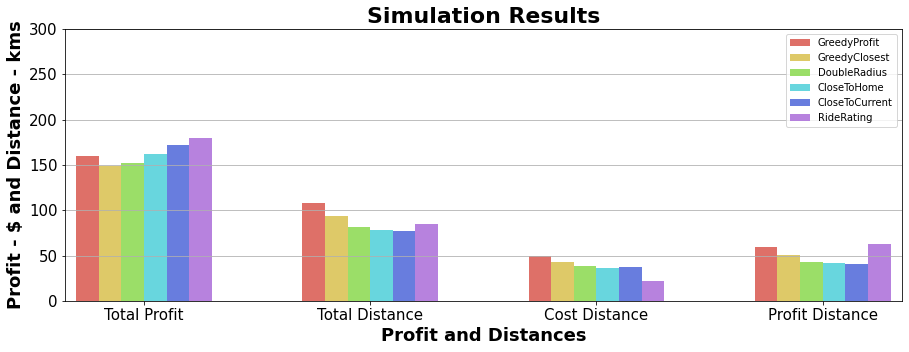

38it [00:00, 377.20it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 12:00:00, and ending at 20:00:00


19885it [00:22, 870.59it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:13 - PickupDistance: 3.92 - DropoffDistance: 2.92 - TotalTime: 20.52 - Profit: 9.8
CurrentProgress: 4.32%
Current Radius: None kms
Ride Info -> StartTime: 12:20:59 - PickupDistance: 4.11 - DropoffDistance: 4.31 - TotalTime: 25.27 - Profit: 13.28
CurrentProgress: 9.64%
Current Radius: None kms
Ride Info -> StartTime: 12:46:27 - PickupDistance: 11.06 - DropoffDistance: 12.55 - TotalTime: 70.83 - Profit: 33.88
CurrentProgress: 24.43%
Current Radius: None kms
Ride Info -> StartTime: 13:57:18 - PickupDistance: 1.82 - DropoffDistance: 6.51 - TotalTime: 24.99 - Profit: 18.77
CurrentProgress: 29.64%
Current Radius: None kms
Ride Info -> StartTime: 14:22:33 - PickupDistance: 6.08 - DropoffDistance: 18.91 - TotalTime: 75.0 - Profit: 49.79
CurrentProgress: 45.32%
Current Radius: None kms
Ride Info -> StartTime: 15:37:43 - PickupDistance: 7.34 - DropoffDistance: 9.92 - TotalTime: 51.8 -

CurrentProgress: 45.8%
Current Radius: 4 kms
Ride Info -> StartTime: 15:40:03 - PickupDistance: 3.18 - DropoffDistance: 1.3 - TotalTime: 13.45 - Profit: 5.76
CurrentProgress: 48.64%
Current Radius: 4 kms
Ride Info -> StartTime: 15:53:59 - PickupDistance: 0.86 - DropoffDistance: 0.99 - TotalTime: 5.55 - Profit: 4.97
CurrentProgress: 49.9%
Current Radius: 4 kms
Ride Info -> StartTime: 16:00:11 - PickupDistance: 0.89 - DropoffDistance: 1.33 - TotalTime: 6.65 - Profit: 5.82
CurrentProgress: 51.42%
Current Radius: 8 kms
Ride Info -> StartTime: 16:07:38 - PickupDistance: 0.85 - DropoffDistance: 3.8 - TotalTime: 13.94 - Profit: 12.0
CurrentProgress: 54.49%
Current Radius: 8 kms
Ride Info -> StartTime: 16:22:15 - PickupDistance: 3.68 - DropoffDistance: 1.5 - TotalTime: 15.52 - Profit: 6.24
CurrentProgress: 57.87%
Current Radius: 8 kms
Ride Info -> StartTime: 16:37:57 - PickupDistance: 1.02 - DropoffDistance: 4.63 - TotalTime: 16.93 - Profit: 14.07
CurrentProgress: 61.43%
Current Radius: 8 kms


CurrentProgress: 94.38%
Current Radius: 2 kms
Ride Info -> StartTime: 19:33:23 - PickupDistance: 1.83 - DropoffDistance: 2.11 - TotalTime: 11.82 - Profit: 7.77
CurrentProgress: 97.01%
Current Radius: 2 kms
Ride Info -> StartTime: 19:45:41 - PickupDistance: 2.85 - DropoffDistance: 2.43 - TotalTime: 15.84 - Profit: 8.58

Simulation closeToHome Results:
Ride Count: 38
Total Profit: 296.59
Total Distance: 151.96
Non-paid Distance: 71.32
Paid Distance: 80.64
Distance from Home: 1.77
Finished Simulation closeToHome.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation closeToCurr ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:03 - PickupDistance: 0.37 - DropoffDistance: 1.52 - TotalTime: 5.68 - Profit: 6.3
CurrentProgress: 1.47%
Current Radius: None kms
Ride Info -> StartTime: 12:07:14 - PickupDistance: 1.52 - DropoffDistance: 3.67 - TotalTime: 15.55 - Profit: 11.66
CurrentProg

CurrentProgress: 92.78%
Current Radius: None kms
Ride Info -> StartTime: 19:25:25 - PickupDistance: 0.66 - DropoffDistance: 2.76 - TotalTime: 10.28 - Profit: 9.4
CurrentProgress: 94.93%
Current Radius: None kms
Ride Info -> StartTime: 19:36:06 - PickupDistance: 1.7 - DropoffDistance: 1.12 - TotalTime: 8.46 - Profit: 5.29
CurrentProgress: 96.78%
Current Radius: None kms
Ride Info -> StartTime: 19:44:38 - PickupDistance: 1.9 - DropoffDistance: 1.27 - TotalTime: 9.53 - Profit: 5.68
CurrentProgress: 98.78%
Current Radius: None kms
Ride Info -> StartTime: 19:54:09 - PickupDistance: 1.28 - DropoffDistance: 0.8 - TotalTime: 6.24 - Profit: 4.49

Simulation closeToCurr Results:
Ride Count: 51
Total Profit: 323.27
Total Distance: 144.23
Non-paid Distance: 65.92
Paid Distance: 78.31
Distance from Home: 0.9
Finished Simulation closeToCurr.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation rating ->
CurrentProgres

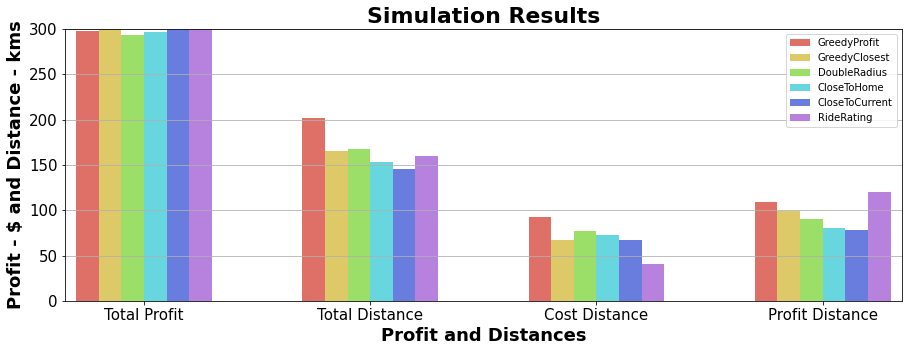

31it [00:00, 306.14it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-24, starting at 16:00:00, and ending at 22:00:00


19885it [00:27, 713.23it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:33 - PickupDistance: 1.27 - DropoffDistance: 10.16 - TotalTime: 34.29 - Profit: 27.89
CurrentProgress: 9.68%
Current Radius: None kms
Ride Info -> StartTime: 16:34:52 - PickupDistance: 9.27 - DropoffDistance: 2.81 - TotalTime: 36.25 - Profit: 9.52
CurrentProgress: 19.75%
Current Radius: None kms
Ride Info -> StartTime: 17:12:10 - PickupDistance: 22.16 - DropoffDistance: 22.43 - TotalTime: 133.76 - Profit: 58.57
CurrentProgress: 57.2%
Current Radius: None kms
Ride Info -> StartTime: 19:26:09 - PickupDistance: 22.8 - DropoffDistance: 19.99 - TotalTime: 128.37 - Profit: 52.49
CurrentProgress: 92.92%
Current Radius: None kms
Ride Info -> StartTime: 21:34:50 - PickupDistance: 3.58 - DropoffDistance: 20.23 - TotalTime: 71.44 - Profit: 53.07

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 201.54
Total Distance: 134.7
Non-paid Distance: 59.08
Paid Distance: 75.61
Dista

CurrentProgress: 45.98%
Current Radius: 8 kms
Ride Info -> StartTime: 18:45:31 - PickupDistance: 2.66 - DropoffDistance: 1.79 - TotalTime: 13.37 - Profit: 6.98
CurrentProgress: 49.69%
Current Radius: 8 kms
Ride Info -> StartTime: 18:59:08 - PickupDistance: 0.68 - DropoffDistance: 5.21 - TotalTime: 17.66 - Profit: 15.52
CurrentProgress: 54.66%
Current Radius: 8 kms
Ride Info -> StartTime: 19:17:24 - PickupDistance: 3.28 - DropoffDistance: 4.34 - TotalTime: 22.87 - Profit: 13.36
CurrentProgress: 61.19%
Current Radius: 8 kms
Ride Info -> StartTime: 19:40:22 - PickupDistance: 3.22 - DropoffDistance: 1.8 - TotalTime: 15.03 - Profit: 6.99
CurrentProgress: 65.39%
Current Radius: 8 kms
Ride Info -> StartTime: 19:55:48 - PickupDistance: 3.22 - DropoffDistance: 5.27 - TotalTime: 25.44 - Profit: 15.66
CurrentProgress: 72.56%
Current Radius: 8 kms
Ride Info -> StartTime: 20:21:30 - PickupDistance: 3.39 - DropoffDistance: 3.69 - TotalTime: 21.24 - Profit: 11.73
CurrentProgress: 78.54%
Current Radiu

CurrentProgress: 23.4%
Current Radius: None kms
Ride Info -> StartTime: 17:24:30 - PickupDistance: 0.27 - DropoffDistance: 1.44 - TotalTime: 5.14 - Profit: 6.1
CurrentProgress: 24.9%
Current Radius: None kms
Ride Info -> StartTime: 17:30:04 - PickupDistance: 1.34 - DropoffDistance: 1.27 - TotalTime: 7.81 - Profit: 5.66
CurrentProgress: 27.31%
Current Radius: None kms
Ride Info -> StartTime: 17:38:32 - PickupDistance: 0.9 - DropoffDistance: 2.0 - TotalTime: 8.71 - Profit: 7.5
CurrentProgress: 29.79%
Current Radius: None kms
Ride Info -> StartTime: 17:47:40 - PickupDistance: 1.49 - DropoffDistance: 1.69 - TotalTime: 9.55 - Profit: 6.74
CurrentProgress: 32.56%
Current Radius: None kms
Ride Info -> StartTime: 17:57:32 - PickupDistance: 1.16 - DropoffDistance: 1.14 - TotalTime: 6.9 - Profit: 5.36
CurrentProgress: 34.7%
Current Radius: None kms
Ride Info -> StartTime: 18:05:26 - PickupDistance: 1.39 - DropoffDistance: 3.58 - TotalTime: 14.91 - Profit: 11.46
CurrentProgress: 38.98%
Current Ra

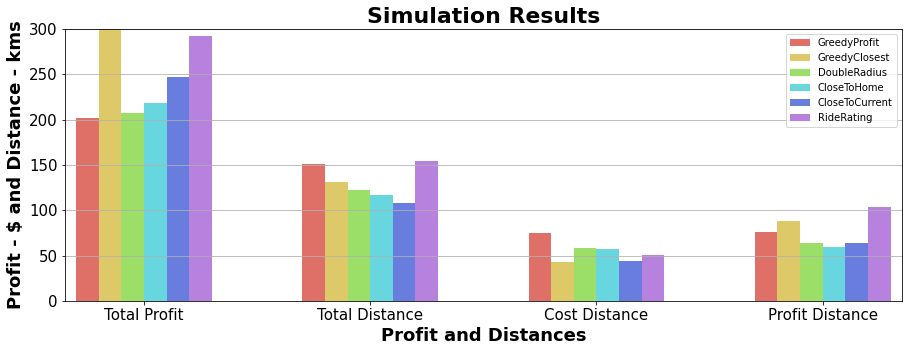

2084it [00:00, 10782.23it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 00:00:00, and ending at 03:00:00


21013it [00:39, 525.83it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:14 - PickupDistance: 2.49 - DropoffDistance: 5.88 - TotalTime: 25.12 - Profit: 17.2
CurrentProgress: 14.07%
Current Radius: None kms
Ride Info -> StartTime: 00:25:40 - PickupDistance: 6.42 - DropoffDistance: 7.44 - TotalTime: 41.57 - Profit: 21.1
CurrentProgress: 37.35%
Current Radius: None kms
Ride Info -> StartTime: 01:07:57 - PickupDistance: 5.7 - DropoffDistance: 13.16 - TotalTime: 56.59 - Profit: 35.4
CurrentProgress: 69.19%
Current Radius: None kms
Ride Info -> StartTime: 02:05:18 - PickupDistance: 20.6 - DropoffDistance: 20.32 - TotalTime: 122.75 - Profit: 53.29

Simulation greedyProfit Results:
Ride Count: 4
Total Profit: 126.99
Total Distance: 82.01
Non-paid Distance: 35.21
Paid Distance: 46.79
Distance from Home: 14.89
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

CurrentProgress: 27.3%
Current Radius: None kms
Ride Info -> StartTime: 00:49:32 - PickupDistance: 1.29 - DropoffDistance: 1.83 - TotalTime: 9.37 - Profit: 7.08
CurrentProgress: 35.35%
Current Radius: None kms
Ride Info -> StartTime: 01:03:59 - PickupDistance: 1.13 - DropoffDistance: 1.04 - TotalTime: 6.51 - Profit: 5.1
CurrentProgress: 39.16%
Current Radius: None kms
Ride Info -> StartTime: 01:10:57 - PickupDistance: 1.85 - DropoffDistance: 4.28 - TotalTime: 18.36 - Profit: 13.19
CurrentProgress: 49.61%
Current Radius: None kms
Ride Info -> StartTime: 01:30:29 - PickupDistance: 1.54 - DropoffDistance: 0.7 - TotalTime: 6.71 - Profit: 4.25
CurrentProgress: 55.55%
Current Radius: None kms
Ride Info -> StartTime: 01:40:11 - PickupDistance: 1.57 - DropoffDistance: 3.47 - TotalTime: 15.14 - Profit: 11.18
CurrentProgress: 64.06%
Current Radius: None kms
Ride Info -> StartTime: 01:56:27 - PickupDistance: 1.0 - DropoffDistance: 1.12 - TotalTime: 6.38 - Profit: 5.3
CurrentProgress: 68.23%
Curre

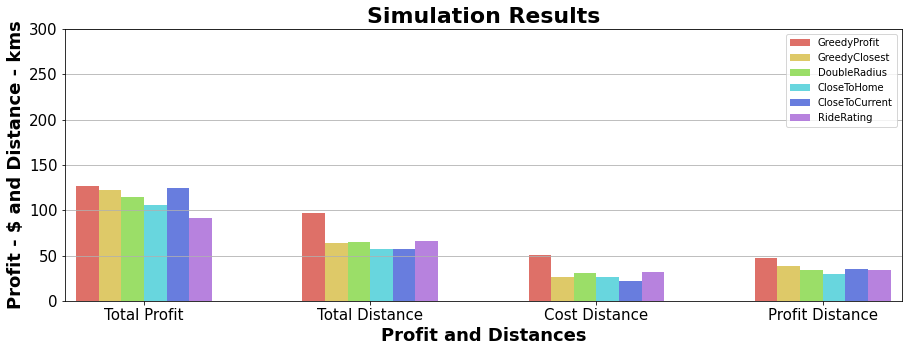

28it [00:00, 273.25it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 08:00:00, and ending at 12:00:00


21013it [00:38, 541.11it/s]


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:18 - PickupDistance: 3.71 - DropoffDistance: 10.2 - TotalTime: 41.73 - Profit: 28.01
CurrentProgress: 17.51%
Current Radius: None kms
Ride Info -> StartTime: 08:42:25 - PickupDistance: 8.39 - DropoffDistance: 4.65 - TotalTime: 39.1 - Profit: 14.12
CurrentProgress: 33.96%
Current Radius: None kms
Ride Info -> StartTime: 09:21:52 - PickupDistance: 5.33 - DropoffDistance: 19.26 - TotalTime: 73.77 - Profit: 50.64
CurrentProgress: 64.85%
Current Radius: None kms
Ride Info -> StartTime: 10:35:41 - PickupDistance: 17.02 - DropoffDistance: 10.63 - TotalTime: 82.97 - Profit: 29.08
CurrentProgress: 99.44%
Current Radius: None kms
Ride Info -> StartTime: 11:58:39 - PickupDistance: 11.56 - DropoffDistance: 8.53 - TotalTime: 60.27 - Profit: 23.82

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 145.68
Total Distance: 99.28
Non-paid Distance: 46.01
Paid Distance: 53.27
Distan

CurrentProgress: 56.48%
Current Radius: 2.1760416666666664 kms
Ride Info -> StartTime: 10:16:07 - PickupDistance: 1.04 - DropoffDistance: 1.84 - TotalTime: 8.65 - Profit: 7.1
CurrentProgress: 60.75%
Current Radius: 2 kms
Ride Info -> StartTime: 10:25:50 - PickupDistance: 1.56 - DropoffDistance: 2.02 - TotalTime: 10.73 - Profit: 7.55
CurrentProgress: 65.23%
Current Radius: 2 kms
Ride Info -> StartTime: 10:36:58 - PickupDistance: 1.13 - DropoffDistance: 1.92 - TotalTime: 9.14 - Profit: 7.29
CurrentProgress: 69.21%
Current Radius: 2 kms
Ride Info -> StartTime: 10:46:43 - PickupDistance: 3.27 - DropoffDistance: 3.01 - TotalTime: 18.86 - Profit: 10.04
CurrentProgress: 77.95%
Current Radius: 2 kms
Ride Info -> StartTime: 11:07:22 - PickupDistance: 1.0 - DropoffDistance: 0.78 - TotalTime: 5.34 - Profit: 4.44
CurrentProgress: 80.29%
Current Radius: 2 kms
Ride Info -> StartTime: 11:13:03 - PickupDistance: 1.88 - DropoffDistance: 2.05 - TotalTime: 11.79 - Profit: 7.62
CurrentProgress: 85.35%
Cur

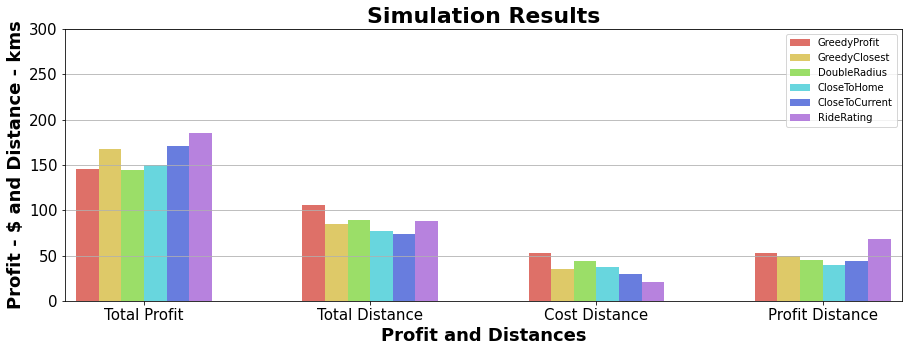

28it [00:00, 273.73it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 12:00:00, and ending at 16:00:00


21013it [00:40, 520.54it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:21 - PickupDistance: 1.05 - DropoffDistance: 10.27 - TotalTime: 33.97 - Profit: 28.17
CurrentProgress: 14.29%
Current Radius: None kms
Ride Info -> StartTime: 12:34:55 - PickupDistance: 12.2 - DropoffDistance: 20.21 - TotalTime: 97.23 - Profit: 53.02
CurrentProgress: 55.06%
Current Radius: None kms
Ride Info -> StartTime: 14:12:29 - PickupDistance: 16.39 - DropoffDistance: 8.45 - TotalTime: 74.54 - Profit: 23.64
CurrentProgress: 86.26%
Current Radius: None kms
Ride Info -> StartTime: 15:27:46 - PickupDistance: 1.1 - DropoffDistance: 20.63 - TotalTime: 65.2 - Profit: 54.07

Simulation greedyProfit Results:
Ride Count: 4
Total Profit: 158.9
Total Distance: 90.31
Non-paid Distance: 30.75
Paid Distance: 59.56
Distance from Home: 19.48
Finished Simulation greedyProfit.

---------------------------------------------------------------------------------------------------------------

CurrentProgress: 28.03%
Current Radius: 3.5982638888888885 kms
Ride Info -> StartTime: 13:08:10 - PickupDistance: 1.49 - DropoffDistance: 2.17 - TotalTime: 10.99 - Profit: 7.92
CurrentProgress: 32.98%
Current Radius: 3.3510416666666663 kms
Ride Info -> StartTime: 13:19:45 - PickupDistance: 0.83 - DropoffDistance: 1.02 - TotalTime: 5.55 - Profit: 5.06
CurrentProgress: 35.53%
Current Radius: 3.223263888888889 kms
Ride Info -> StartTime: 13:25:57 - PickupDistance: 1.16 - DropoffDistance: 2.87 - TotalTime: 12.12 - Profit: 9.68
CurrentProgress: 40.85%
Current Radius: 2.9572916666666664 kms
Ride Info -> StartTime: 13:38:08 - PickupDistance: 2.28 - DropoffDistance: 0.93 - TotalTime: 9.63 - Profit: 4.82
CurrentProgress: 44.9%
Current Radius: 2.755208333333333 kms
Ride Info -> StartTime: 13:48:23 - PickupDistance: 0.78 - DropoffDistance: 2.18 - TotalTime: 8.9 - Profit: 7.96
CurrentProgress: 48.87%
Current Radius: 2.556597222222222 kms
Ride Info -> StartTime: 13:57:17 - PickupDistance: 2.1 - Dro

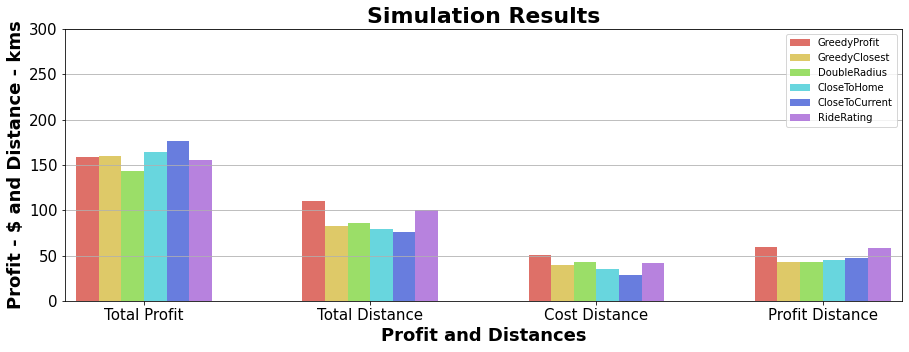

22it [00:00, 215.45it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 12:00:00, and ending at 20:00:00


21013it [00:38, 549.76it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:21 - PickupDistance: 1.06 - DropoffDistance: 10.27 - TotalTime: 33.97 - Profit: 28.17
CurrentProgress: 7.15%
Current Radius: None kms
Ride Info -> StartTime: 12:34:55 - PickupDistance: 12.2 - DropoffDistance: 20.21 - TotalTime: 97.23 - Profit: 53.02
CurrentProgress: 27.53%
Current Radius: None kms
Ride Info -> StartTime: 14:12:29 - PickupDistance: 16.39 - DropoffDistance: 8.45 - TotalTime: 74.54 - Profit: 23.64
CurrentProgress: 43.13%
Current Radius: None kms
Ride Info -> StartTime: 15:27:46 - PickupDistance: 1.1 - DropoffDistance: 20.63 - TotalTime: 65.2 - Profit: 54.07
CurrentProgress: 56.87%
Current Radius: None kms
Ride Info -> StartTime: 16:34:24 - PickupDistance: 0.73 - DropoffDistance: 19.87 - TotalTime: 61.8 - Profit: 52.18
CurrentProgress: 70.04%
Current Radius: None kms
Ride Info -> StartTime: 17:36:46 - PickupDistance: 1.43 - DropoffDistance: 11.07 - TotalTime: 37

CurrentProgress: 92.79%
Current Radius: None kms
Ride Info -> StartTime: 19:25:31 - PickupDistance: 0.92 - DropoffDistance: 4.27 - TotalTime: 15.58 - Profit: 13.18
CurrentProgress: 96.06%
Current Radius: None kms
Ride Info -> StartTime: 19:41:34 - PickupDistance: 0.27 - DropoffDistance: 2.69 - TotalTime: 8.89 - Profit: 9.22
CurrentProgress: 98.01%
Current Radius: None kms
Ride Info -> StartTime: 19:51:02 - PickupDistance: 0.29 - DropoffDistance: 2.36 - TotalTime: 7.94 - Profit: 8.39
CurrentProgress: 99.78%
Current Radius: None kms
Ride Info -> StartTime: 19:59:14 - PickupDistance: 0.35 - DropoffDistance: 2.3 - TotalTime: 7.95 - Profit: 8.24

Simulation greedyClosest Results:
Ride Count: 45
Total Profit: 353.47
Total Distance: 156.68
Non-paid Distance: 60.29
Paid Distance: 96.39
Distance from Home: 1.89
Finished Simulation greedyClosest.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation doubleRadius ->

CurrentProgress: 37.48%
Current Radius: 3.125868055555556 kms
Ride Info -> StartTime: 15:00:42 - PickupDistance: 2.17 - DropoffDistance: 3.42 - TotalTime: 16.77 - Profit: 11.06
CurrentProgress: 41.14%
Current Radius: 2.943229166666667 kms
Ride Info -> StartTime: 15:17:37 - PickupDistance: 3.19 - DropoffDistance: 2.11 - TotalTime: 15.9 - Profit: 7.77
CurrentProgress: 44.48%
Current Radius: 2.7758680555555557 kms
Ride Info -> StartTime: 15:33:38 - PickupDistance: 0.94 - DropoffDistance: 1.51 - TotalTime: 7.34 - Profit: 6.26
CurrentProgress: 46.03%
Current Radius: 2.6982638888888886 kms
Ride Info -> StartTime: 15:41:02 - PickupDistance: 0.71 - DropoffDistance: 1.24 - TotalTime: 5.84 - Profit: 5.59
CurrentProgress: 47.26%
Current Radius: 2.636805555555556 kms
Ride Info -> StartTime: 15:47:51 - PickupDistance: 3.27 - DropoffDistance: 2.22 - TotalTime: 16.45 - Profit: 8.04
CurrentProgress: 50.89%
Current Radius: 2.4553819444444445 kms
Ride Info -> StartTime: 16:04:50 - PickupDistance: 1.6 - 

CurrentProgress: 50.59%
Current Radius: None kms
Ride Info -> StartTime: 16:03:52 - PickupDistance: 1.46 - DropoffDistance: 0.82 - TotalTime: 6.83 - Profit: 4.54
CurrentProgress: 52.23%
Current Radius: None kms
Ride Info -> StartTime: 16:11:53 - PickupDistance: 0.48 - DropoffDistance: 1.41 - TotalTime: 5.68 - Profit: 6.02
CurrentProgress: 53.66%
Current Radius: None kms
Ride Info -> StartTime: 16:18:20 - PickupDistance: 1.65 - DropoffDistance: 2.0 - TotalTime: 10.98 - Profit: 7.51
CurrentProgress: 56.48%
Current Radius: None kms
Ride Info -> StartTime: 16:31:27 - PickupDistance: 1.59 - DropoffDistance: 1.4 - TotalTime: 8.97 - Profit: 6.01
CurrentProgress: 59.56%
Current Radius: None kms
Ride Info -> StartTime: 16:46:31 - PickupDistance: 1.8 - DropoffDistance: 1.01 - TotalTime: 8.42 - Profit: 5.02
CurrentProgress: 61.66%
Current Radius: None kms
Ride Info -> StartTime: 16:56:13 - PickupDistance: 1.81 - DropoffDistance: 1.53 - TotalTime: 10.0 - Profit: 6.32
CurrentProgress: 63.8%
Current

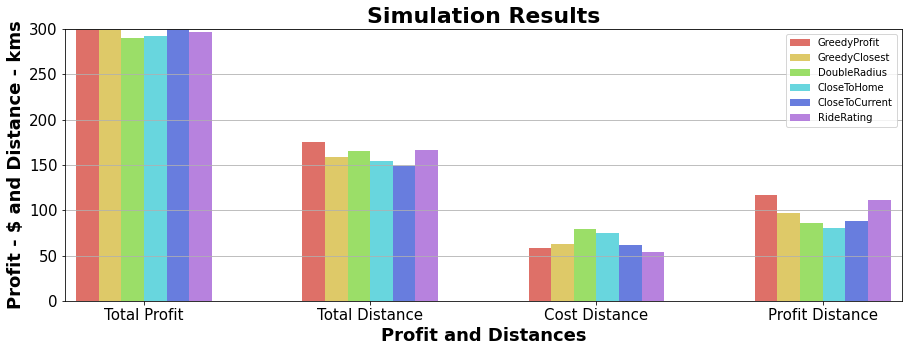

24it [00:00, 231.64it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-26, starting at 16:00:00, and ending at 22:00:00


21013it [00:39, 525.45it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:03 - PickupDistance: 5.39 - DropoffDistance: 5.26 - TotalTime: 31.96 - Profit: 15.66
CurrentProgress: 8.89%
Current Radius: None kms
Ride Info -> StartTime: 16:32:30 - PickupDistance: 21.0 - DropoffDistance: 21.48 - TotalTime: 127.45 - Profit: 56.2
CurrentProgress: 44.43%
Current Radius: None kms
Ride Info -> StartTime: 18:40:03 - PickupDistance: 3.85 - DropoffDistance: 7.81 - TotalTime: 35.0 - Profit: 22.03
CurrentProgress: 54.18%
Current Radius: None kms
Ride Info -> StartTime: 19:15:13 - PickupDistance: 11.45 - DropoffDistance: 7.29 - TotalTime: 56.21 - Profit: 20.73
CurrentProgress: 69.84%
Current Radius: None kms
Ride Info -> StartTime: 20:11:49 - PickupDistance: 6.81 - DropoffDistance: 6.22 - TotalTime: 39.09 - Profit: 18.05
CurrentProgress: 80.81%
Current Radius: None kms
Ride Info -> StartTime: 20:51:08 - PickupDistance: 6.87 - DropoffDistance: 13.06 - TotalTime: 59.

CurrentProgress: 43.47%
Current Radius: 16 kms
Ride Info -> StartTime: 18:36:58 - PickupDistance: 2.95 - DropoffDistance: 3.15 - TotalTime: 18.3 - Profit: 10.38
CurrentProgress: 48.68%
Current Radius: 16 kms
Ride Info -> StartTime: 18:55:55 - PickupDistance: 0.95 - DropoffDistance: 12.18 - TotalTime: 39.4 - Profit: 32.96
CurrentProgress: 59.81%
Current Radius: 16 kms
Ride Info -> StartTime: 19:35:38 - PickupDistance: 10.97 - DropoffDistance: 7.26 - TotalTime: 54.68 - Profit: 20.65
CurrentProgress: 75.08%
Current Radius: 16 kms
Ride Info -> StartTime: 20:30:26 - PickupDistance: 5.95 - DropoffDistance: 1.28 - TotalTime: 21.7 - Profit: 5.7
CurrentProgress: 81.14%
Current Radius: 16 kms
Ride Info -> StartTime: 20:52:38 - PickupDistance: 0.9 - DropoffDistance: 9.45 - TotalTime: 31.06 - Profit: 26.12
CurrentProgress: 89.91%
Current Radius: 16 kms
Ride Info -> StartTime: 21:24:01 - PickupDistance: 10.86 - DropoffDistance: 2.88 - TotalTime: 41.23 - Profit: 9.7

Simulation doubleRadius Results:

CurrentProgress: 34.46%
Current Radius: None kms
Ride Info -> StartTime: 18:04:07 - PickupDistance: 0.86 - DropoffDistance: 0.57 - TotalTime: 4.3 - Profit: 3.94
CurrentProgress: 35.67%
Current Radius: None kms
Ride Info -> StartTime: 18:08:49 - PickupDistance: 1.07 - DropoffDistance: 1.16 - TotalTime: 6.67 - Profit: 5.39
CurrentProgress: 37.78%
Current Radius: None kms
Ride Info -> StartTime: 18:16:22 - PickupDistance: 0.85 - DropoffDistance: 1.81 - TotalTime: 7.97 - Profit: 7.03
CurrentProgress: 40.09%
Current Radius: None kms
Ride Info -> StartTime: 18:24:46 - PickupDistance: 0.19 - DropoffDistance: 1.45 - TotalTime: 4.92 - Profit: 6.13
CurrentProgress: 41.58%
Current Radius: None kms
Ride Info -> StartTime: 18:29:43 - PickupDistance: 0.95 - DropoffDistance: 1.5 - TotalTime: 7.35 - Profit: 6.24
CurrentProgress: 43.92%
Current Radius: None kms
Ride Info -> StartTime: 18:38:15 - PickupDistance: 2.0 - DropoffDistance: 1.21 - TotalTime: 9.62 - Profit: 5.53
CurrentProgress: 46.63%
Current

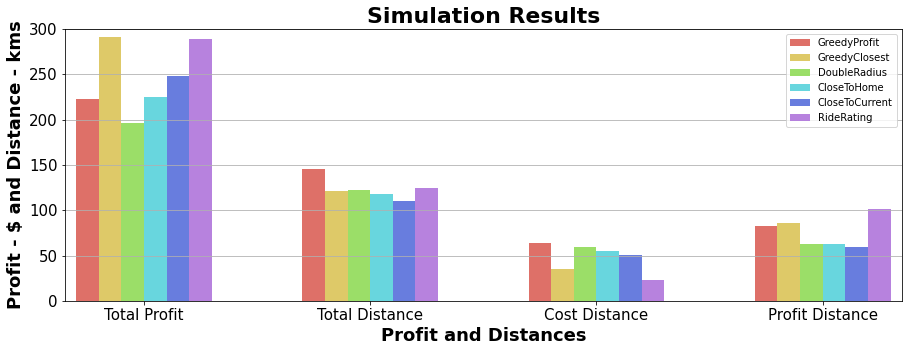

890it [00:00, 8894.75it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 00:00:00, and ending at 03:00:00


16993it [00:28, 590.99it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:09 - PickupDistance: 2.36 - DropoffDistance: 10.03 - TotalTime: 37.16 - Profit: 27.58
CurrentProgress: 20.72%
Current Radius: None kms
Ride Info -> StartTime: 00:37:25 - PickupDistance: 24.25 - DropoffDistance: 19.35 - TotalTime: 130.81 - Profit: 50.87
CurrentProgress: 93.45%
Current Radius: None kms
Ride Info -> StartTime: 02:48:47 - PickupDistance: 0.49 - DropoffDistance: 15.29 - TotalTime: 47.36 - Profit: 40.74

Simulation greedyProfit Results:
Ride Count: 3
Total Profit: 119.19
Total Distance: 71.78
Non-paid Distance: 27.1
Paid Distance: 44.68
Distance from Home: 14.86
Finished Simulation greedyProfit.

-----------------------------------------------------------------------------------------------------------------

Starting Simulation greedyClosest ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 00:00:17 - PickupDistance: 1.61 - DropoffDistance

CurrentProgress: 51.83%
Current Radius: None kms
Ride Info -> StartTime: 01:33:30 - PickupDistance: 0.94 - DropoffDistance: 1.67 - TotalTime: 7.82 - Profit: 6.67
CurrentProgress: 58.06%
Current Radius: None kms
Ride Info -> StartTime: 01:44:31 - PickupDistance: 1.42 - DropoffDistance: 1.31 - TotalTime: 8.19 - Profit: 5.78
CurrentProgress: 64.45%
Current Radius: None kms
Ride Info -> StartTime: 01:56:13 - PickupDistance: 1.45 - DropoffDistance: 2.72 - TotalTime: 12.52 - Profit: 9.3
CurrentProgress: 73.08%
Current Radius: None kms
Ride Info -> StartTime: 02:12:04 - PickupDistance: 0.8 - DropoffDistance: 2.41 - TotalTime: 9.63 - Profit: 8.52
CurrentProgress: 78.71%
Current Radius: None kms
Ride Info -> StartTime: 02:22:26 - PickupDistance: 1.54 - DropoffDistance: 2.24 - TotalTime: 11.35 - Profit: 8.09
CurrentProgress: 87.11%
Current Radius: None kms
Ride Info -> StartTime: 02:37:22 - PickupDistance: 1.34 - DropoffDistance: 0.97 - TotalTime: 6.93 - Profit: 4.92
CurrentProgress: 92.29%
Curr

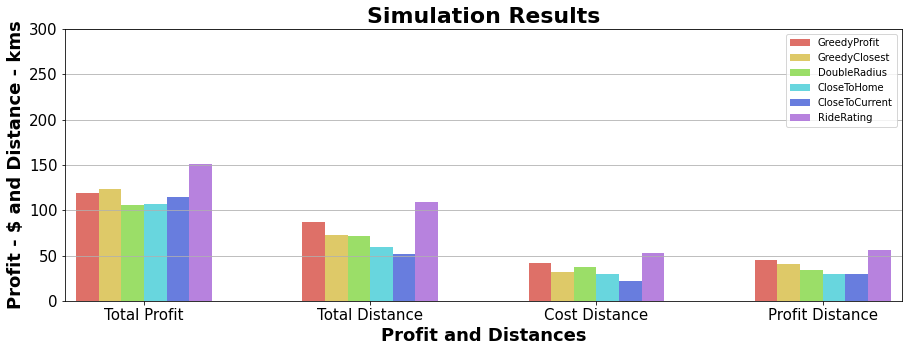

30it [00:00, 299.82it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 08:00:00, and ending at 12:00:00


16993it [00:28, 603.61it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 08:00:00 - PickupDistance: 0.79 - DropoffDistance: 10.22 - TotalTime: 33.03 - Profit: 28.05
CurrentProgress: 13.76%
Current Radius: None kms
Ride Info -> StartTime: 08:33:55 - PickupDistance: 10.79 - DropoffDistance: 10.79 - TotalTime: 64.74 - Profit: 29.47
CurrentProgress: 41.1%
Current Radius: None kms
Ride Info -> StartTime: 09:39:14 - PickupDistance: 14.76 - DropoffDistance: 21.5 - TotalTime: 108.8 - Profit: 56.26
CurrentProgress: 86.67%
Current Radius: None kms
Ride Info -> StartTime: 11:28:35 - PickupDistance: 21.77 - DropoffDistance: 15.59 - TotalTime: 112.1 - Profit: 41.48

Simulation greedyProfit Results:
Ride Count: 4
Total Profit: 155.25
Total Distance: 106.22
Non-paid Distance: 48.12
Paid Distance: 58.1
Distance from Home: 4.78
Finished Simulation greedyProfit.

------------------------------------------------------------------------------------------------------------

CurrentProgress: 49.15%
Current Radius: 2.5427083333333336 kms
Ride Info -> StartTime: 09:58:28 - PickupDistance: 1.22 - DropoffDistance: 1.72 - TotalTime: 8.81 - Profit: 6.81
CurrentProgress: 53.03%
Current Radius: 2.3486111111111114 kms
Ride Info -> StartTime: 10:07:48 - PickupDistance: 2.18 - DropoffDistance: 0.88 - TotalTime: 9.18 - Profit: 4.71
CurrentProgress: 57.47%
Current Radius: 2.126736111111111 kms
Ride Info -> StartTime: 10:17:59 - PickupDistance: 0.88 - DropoffDistance: 0.98 - TotalTime: 5.58 - Profit: 4.95
CurrentProgress: 60.31%
Current Radius: 2 kms
Ride Info -> StartTime: 10:24:51 - PickupDistance: 1.2 - DropoffDistance: 0.92 - TotalTime: 6.35 - Profit: 4.81
CurrentProgress: 64.27%
Current Radius: 2 kms
Ride Info -> StartTime: 10:34:27 - PickupDistance: 0.95 - DropoffDistance: 2.04 - TotalTime: 9.0 - Profit: 7.61
CurrentProgress: 68.85%
Current Radius: 2 kms
Ride Info -> StartTime: 10:45:58 - PickupDistance: 1.04 - DropoffDistance: 1.14 - TotalTime: 6.54 - Profit: 5.3

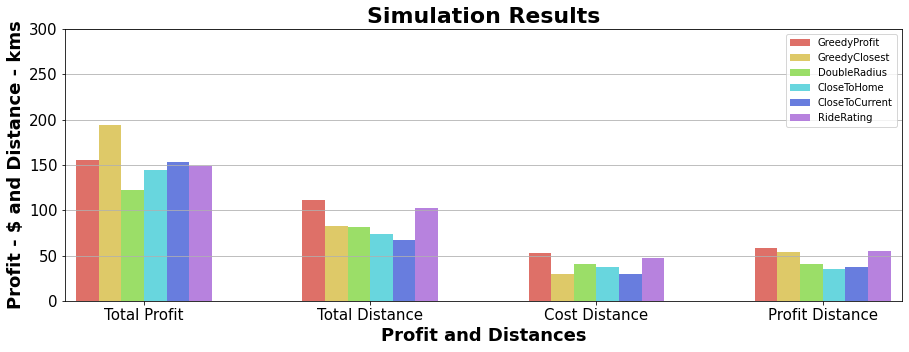

28it [00:00, 271.49it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 12:00:00, and ending at 16:00:00


16993it [00:27, 628.84it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:30 - PickupDistance: 9.29 - DropoffDistance: 11.7 - TotalTime: 62.97 - Profit: 31.75
CurrentProgress: 26.44%
Current Radius: None kms
Ride Info -> StartTime: 13:03:54 - PickupDistance: 4.84 - DropoffDistance: 5.53 - TotalTime: 31.12 - Profit: 16.32
CurrentProgress: 39.59%
Current Radius: None kms
Ride Info -> StartTime: 13:35:10 - PickupDistance: 4.55 - DropoffDistance: 6.5 - TotalTime: 33.14 - Profit: 18.75
CurrentProgress: 53.46%
Current Radius: None kms
Ride Info -> StartTime: 14:08:37 - PickupDistance: 3.32 - DropoffDistance: 20.9 - TotalTime: 72.67 - Profit: 54.76
CurrentProgress: 83.87%
Current Radius: None kms
Ride Info -> StartTime: 15:21:21 - PickupDistance: 20.46 - DropoffDistance: 14.48 - TotalTime: 104.83 - Profit: 38.71

Simulation greedyProfit Results:
Ride Count: 5
Total Profit: 160.29
Total Distance: 101.58
Non-paid Distance: 42.46
Paid Distance: 59.12
Distan

CurrentProgress: 12.36%
Current Radius: 4.381944444444445 kms
Ride Info -> StartTime: 12:30:10 - PickupDistance: 1.68 - DropoffDistance: 1.01 - TotalTime: 8.09 - Profit: 5.04
CurrentProgress: 15.94%
Current Radius: 4.203125 kms
Ride Info -> StartTime: 12:38:42 - PickupDistance: 2.72 - DropoffDistance: 3.88 - TotalTime: 19.8 - Profit: 12.2
CurrentProgress: 24.38%
Current Radius: 3.78125 kms
Ride Info -> StartTime: 12:58:31 - PickupDistance: 0.79 - DropoffDistance: 4.47 - TotalTime: 15.79 - Profit: 13.68
CurrentProgress: 30.96%
Current Radius: 3.4520833333333334 kms
Ride Info -> StartTime: 13:15:01 - PickupDistance: 3.21 - DropoffDistance: 2.62 - TotalTime: 17.48 - Profit: 9.04
CurrentProgress: 38.53%
Current Radius: 3.0732638888888886 kms
Ride Info -> StartTime: 13:32:50 - PickupDistance: 3.9 - DropoffDistance: 2.9 - TotalTime: 20.4 - Profit: 9.74
CurrentProgress: 47.17%
Current Radius: 2.641319444444444 kms
Ride Info -> StartTime: 13:53:27 - PickupDistance: 1.94 - DropoffDistance: 2.38

CurrentProgress: 69.03%
Current Radius: None kms
Ride Info -> StartTime: 14:46:12 - PickupDistance: 0.16 - DropoffDistance: 10.25 - TotalTime: 31.22 - Profit: 28.12
CurrentProgress: 82.26%
Current Radius: None kms
Ride Info -> StartTime: 15:17:43 - PickupDistance: 1.41 - DropoffDistance: 13.49 - TotalTime: 44.68 - Profit: 36.22

Simulation rating Results:
Ride Count: 7
Total Profit: 173.0
Total Distance: 79.64
Non-paid Distance: 17.44
Paid Distance: 62.2
Distance from Home: 15.0
Finished Simulation rating.

-----------------------------------------------------------------------------------------------------------------


End of Comparing Algorithms
Overview
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit           160.29         180.07        144.51       143.71   
totalDistance         120.37          82.02         81.40        76.92   
costDistance           61.25          28.99         40.59        38.43   
profitDistance         59.12          

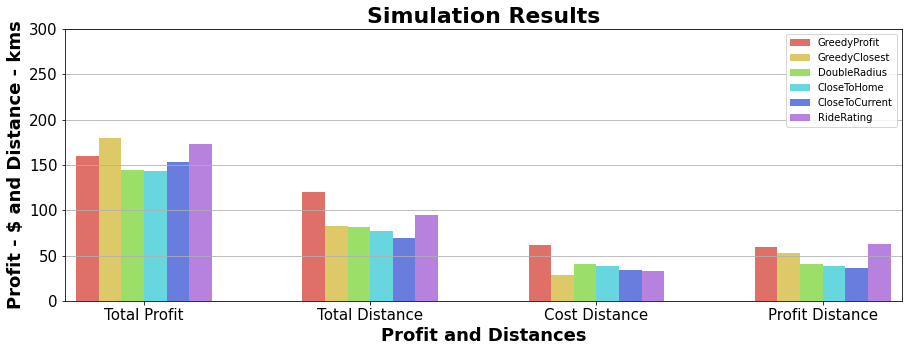

37it [00:00, 366.20it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 12:00:00, and ending at 20:00:00


16993it [00:23, 721.54it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 12:00:30 - PickupDistance: 9.14 - DropoffDistance: 11.7 - TotalTime: 62.52 - Profit: 31.75
CurrentProgress: 13.13%
Current Radius: None kms
Ride Info -> StartTime: 13:03:17 - PickupDistance: 11.11 - DropoffDistance: 8.7 - TotalTime: 59.41 - Profit: 24.24
CurrentProgress: 25.56%
Current Radius: None kms
Ride Info -> StartTime: 14:02:46 - PickupDistance: 8.69 - DropoffDistance: 9.91 - TotalTime: 55.82 - Profit: 27.28
CurrentProgress: 37.2%
Current Radius: None kms
Ride Info -> StartTime: 14:59:10 - PickupDistance: 2.89 - DropoffDistance: 20.74 - TotalTime: 70.88 - Profit: 54.34
CurrentProgress: 52.09%
Current Radius: None kms
Ride Info -> StartTime: 16:10:59 - PickupDistance: 0.44 - DropoffDistance: 11.3 - TotalTime: 35.23 - Profit: 30.75
CurrentProgress: 59.62%
Current Radius: None kms
Ride Info -> StartTime: 16:46:12 - PickupDistance: 31.28 - DropoffDistance: 7.47 - TotalTime: 116

CurrentProgress: 29.49%
Current Radius: 4 kms
Ride Info -> StartTime: 14:22:10 - PickupDistance: 2.03 - DropoffDistance: 3.93 - TotalTime: 17.89 - Profit: 12.32
CurrentProgress: 33.34%
Current Radius: 4 kms
Ride Info -> StartTime: 14:41:00 - PickupDistance: 1.14 - DropoffDistance: 1.54 - TotalTime: 8.06 - Profit: 6.35
CurrentProgress: 35.22%
Current Radius: 4 kms
Ride Info -> StartTime: 14:49:27 - PickupDistance: 2.28 - DropoffDistance: 1.97 - TotalTime: 12.76 - Profit: 7.42
CurrentProgress: 37.96%
Current Radius: 4 kms
Ride Info -> StartTime: 15:02:45 - PickupDistance: 1.47 - DropoffDistance: 4.05 - TotalTime: 16.55 - Profit: 12.62
CurrentProgress: 41.52%
Current Radius: 4 kms
Ride Info -> StartTime: 15:19:54 - PickupDistance: 2.94 - DropoffDistance: 2.49 - TotalTime: 16.3 - Profit: 8.72
CurrentProgress: 45.04%
Current Radius: 4 kms
Ride Info -> StartTime: 15:36:43 - PickupDistance: 2.69 - DropoffDistance: 2.94 - TotalTime: 16.9 - Profit: 9.84
CurrentProgress: 48.89%
Current Radius: 8

CurrentProgress: 86.96%
Current Radius: 2 kms
Ride Info -> StartTime: 18:57:42 - PickupDistance: 1.08 - DropoffDistance: 1.94 - TotalTime: 9.06 - Profit: 7.35
CurrentProgress: 88.91%
Current Radius: 2 kms
Ride Info -> StartTime: 19:06:51 - PickupDistance: 1.29 - DropoffDistance: 0.87 - TotalTime: 6.49 - Profit: 4.67
CurrentProgress: 90.62%
Current Radius: 2 kms
Ride Info -> StartTime: 19:15:57 - PickupDistance: 0.61 - DropoffDistance: 1.74 - TotalTime: 7.07 - Profit: 6.85
CurrentProgress: 92.62%
Current Radius: 2 kms
Ride Info -> StartTime: 19:25:11 - PickupDistance: 1.72 - DropoffDistance: 2.05 - TotalTime: 11.31 - Profit: 7.62
CurrentProgress: 95.1%
Current Radius: 2 kms
Ride Info -> StartTime: 19:37:25 - PickupDistance: 0.17 - DropoffDistance: 2.72 - TotalTime: 8.66 - Profit: 9.29
CurrentProgress: 97.2%
Current Radius: 2 kms
Ride Info -> StartTime: 19:47:06 - PickupDistance: 2.64 - DropoffDistance: 2.26 - TotalTime: 14.72 - Profit: 8.16

Simulation closeToHome Results:
Ride Count: 3

CurrentProgress: 90.62%
Current Radius: None kms
Ride Info -> StartTime: 19:15:57 - PickupDistance: 0.61 - DropoffDistance: 1.74 - TotalTime: 7.07 - Profit: 6.85
CurrentProgress: 92.62%
Current Radius: None kms
Ride Info -> StartTime: 19:25:11 - PickupDistance: 1.72 - DropoffDistance: 2.05 - TotalTime: 11.31 - Profit: 7.62
CurrentProgress: 95.1%
Current Radius: None kms
Ride Info -> StartTime: 19:37:25 - PickupDistance: 0.17 - DropoffDistance: 2.72 - TotalTime: 8.66 - Profit: 9.29
CurrentProgress: 97.32%
Current Radius: None kms
Ride Info -> StartTime: 19:48:00 - PickupDistance: 1.83 - DropoffDistance: 0.98 - TotalTime: 8.44 - Profit: 4.95
CurrentProgress: 99.26%
Current Radius: None kms
Ride Info -> StartTime: 19:56:40 - PickupDistance: 0.91 - DropoffDistance: 1.05 - TotalTime: 5.87 - Profit: 5.11

Simulation closeToCurr Results:
Ride Count: 48
Total Profit: 324.48
Total Distance: 133.8
Non-paid Distance: 52.01
Paid Distance: 81.79
Distance from Home: 1.1
Finished Simulation closeToCu

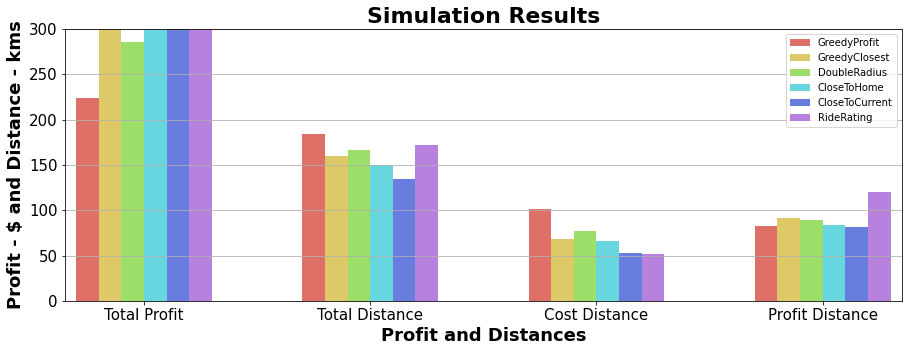

31it [00:00, 305.72it/s]

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Simulating on 2015-06-28, starting at 16:00:00, and ending at 22:00:00


16993it [00:26, 633.48it/s] 


Starting Simulation greedyProfit ->
CurrentProgress: 0.0%
Current Radius: None kms
Ride Info -> StartTime: 16:00:58 - PickupDistance: 8.99 - DropoffDistance: 8.3 - TotalTime: 51.88 - Profit: 23.26
CurrentProgress: 14.68%
Current Radius: None kms
Ride Info -> StartTime: 16:53:27 - PickupDistance: 11.41 - DropoffDistance: 20.44 - TotalTime: 95.52 - Profit: 53.59
CurrentProgress: 41.38%
Current Radius: None kms
Ride Info -> StartTime: 18:29:06 - PickupDistance: 3.93 - DropoffDistance: 5.8 - TotalTime: 29.2 - Profit: 17.01
CurrentProgress: 49.52%
Current Radius: None kms
Ride Info -> StartTime: 18:58:49 - PickupDistance: 19.59 - DropoffDistance: 20.66 - TotalTime: 120.75 - Profit: 54.14
CurrentProgress: 83.21%
Current Radius: None kms
Ride Info -> StartTime: 20:59:54 - PickupDistance: 3.01 - DropoffDistance: 5.9 - TotalTime: 26.73 - Profit: 17.26
CurrentProgress: 90.73%
Current Radius: None kms
Ride Info -> StartTime: 21:26:45 - PickupDistance: 8.39 - DropoffDistance: 11.34 - TotalTime: 59

CurrentProgress: 36.84%
Current Radius: 4 kms
Ride Info -> StartTime: 18:13:05 - PickupDistance: 4.03 - DropoffDistance: 4.05 - TotalTime: 24.25 - Profit: 12.63
CurrentProgress: 43.7%
Current Radius: 4 kms
Ride Info -> StartTime: 18:37:56 - PickupDistance: 3.53 - DropoffDistance: 4.15 - TotalTime: 23.02 - Profit: 12.87
CurrentProgress: 50.26%
Current Radius: 4 kms
Ride Info -> StartTime: 19:01:28 - PickupDistance: 4.23 - DropoffDistance: 3.6 - TotalTime: 23.47 - Profit: 11.49
CurrentProgress: 56.93%
Current Radius: 4 kms
Ride Info -> StartTime: 19:24:56 - PickupDistance: 2.62 - DropoffDistance: 1.99 - TotalTime: 13.82 - Profit: 7.46
CurrentProgress: 60.76%
Current Radius: 4 kms
Ride Info -> StartTime: 19:39:04 - PickupDistance: 1.87 - DropoffDistance: 1.44 - TotalTime: 9.92 - Profit: 6.1
CurrentProgress: 63.61%
Current Radius: 4 kms
Ride Info -> StartTime: 19:49:01 - PickupDistance: 1.66 - DropoffDistance: 4.18 - TotalTime: 17.52 - Profit: 12.94
CurrentProgress: 68.48%
Current Radius: 

CurrentProgress: 30.32%
Current Radius: None kms
Ride Info -> StartTime: 17:49:22 - PickupDistance: 0.93 - DropoffDistance: 1.47 - TotalTime: 7.22 - Profit: 6.18
CurrentProgress: 32.85%
Current Radius: None kms
Ride Info -> StartTime: 17:58:45 - PickupDistance: 0.84 - DropoffDistance: 1.63 - TotalTime: 7.4 - Profit: 6.57
CurrentProgress: 35.28%
Current Radius: None kms
Ride Info -> StartTime: 18:07:08 - PickupDistance: 0.61 - DropoffDistance: 2.1 - TotalTime: 8.13 - Profit: 7.75
CurrentProgress: 37.57%
Current Radius: None kms
Ride Info -> StartTime: 18:15:32 - PickupDistance: 0.32 - DropoffDistance: 2.04 - TotalTime: 7.1 - Profit: 7.61
CurrentProgress: 39.62%
Current Radius: None kms
Ride Info -> StartTime: 18:22:42 - PickupDistance: 0.68 - DropoffDistance: 1.15 - TotalTime: 5.48 - Profit: 5.38
CurrentProgress: 41.36%
Current Radius: None kms
Ride Info -> StartTime: 18:29:07 - PickupDistance: 1.38 - DropoffDistance: 1.96 - TotalTime: 10.01 - Profit: 7.41
CurrentProgress: 44.58%
Curren

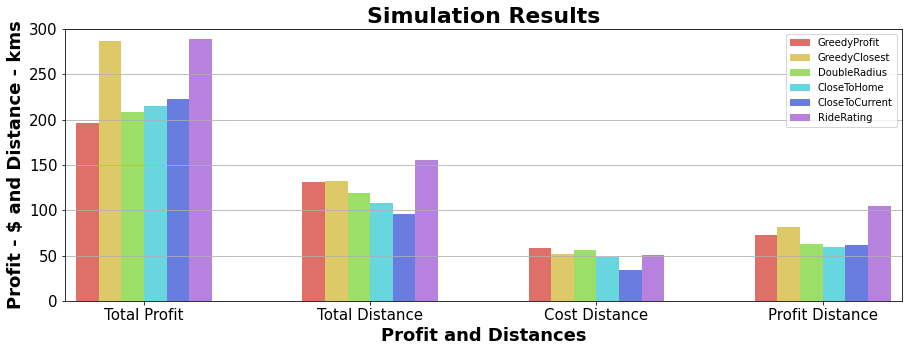

-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------


End of All Simulations
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------

Averaged Results
                greedyProfit  greedyClosest  doubleRadius  closeToHome  \
totalProfit         185.2815       216.4995      178.8310     181.7775   
totalDistance       129.4675       104.4470      105.4260      94.0240   
costDistance         60.6555        40.5450       50.7435      44.6110   
profitDistance       68.8115        63.8990       54.6815      49.4125   

                

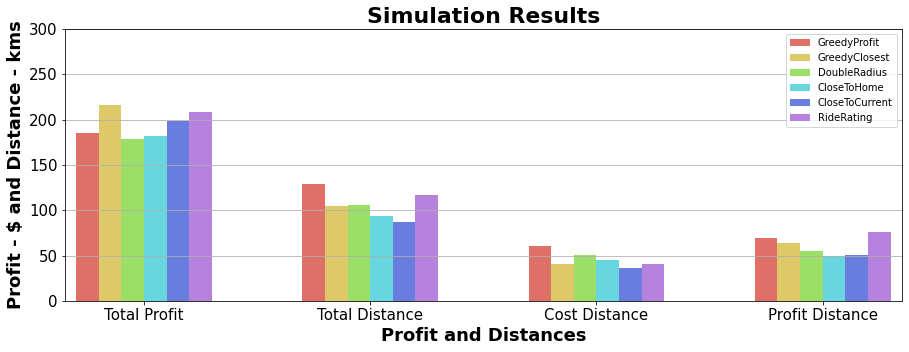

In [633]:
averageComparison([df_monday, df_wednesday, df_friday, df_sunday], ['2015-06-22', '2015-06-24', '2015-06-26', '2015-06-28'], ['00:00:00 03:00:00', '08:00:00 12:00:00', '12:00:00 16:00:00', '12:00:00 20:00:00', '16:00:00 22:00:00'],  3, 10, 2, 5, 0.1)